<p style="color:navy; font-weight:bold; font-family:newtimesroman; font-size:200%; text-align:center">Segmentación de clientes de crédito</p>
<br>

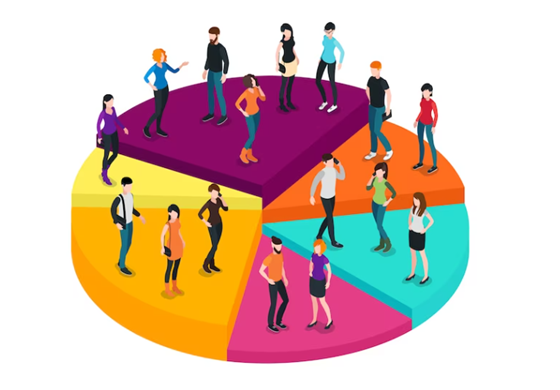

# Introducción <a class="tocSkip">

Este proyecto consiste, principalmente, en hacer una segmentación de clientes bancarios. La base es tomada del sitio de [kaggle](https://www.kaggle.com/datasets/uciml/german-credit). Prácticamente, todos los bancos realizan este tipo de análisis debido a que es de suma importancia tener bien identificados y segmentados a sus clientes con el objetivo de poder personalizarles ofertas, promociones y, en general, campañas de marketing. Es por ello que se decidió hacer este tipo de trabajo el cual consta de las siguientes fases:

1. Configuración inicial del entorno de trabajo.
2. Carga de datos.
3. Descripción general de los datos.
4. Análisis exploratorio de los datos.
5. Ingeniería de variables.
6. Tratamiento de valores faltantes.
7. Tratamiento de valores atípicos.
8. Transformación de los datos.
9. Modelo de segmentación (KMeans).
10. Caracterización de los clústeres.
11. Generación de insights.
12. Caso de negocio.

El objetivo principal de este trabajo es el de hacer una segmentación de clientes para indentificar aquellos que tendrán altas probabilidades de contratar un segundo crédito para auto, ya que ese será el caso de negocio propuesto.

# Set up

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

%matplotlib inline
plt.style.use('ggplot')
pd.options.display.min_rows = 6
pd.options.display.max_columns = None

# Carga de datos

In [2]:
df = pd.read_csv('data/german_credit_data.csv')
df.head()

Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car

# Panorama general

En esta sección sólo se mostrarán aspectos básicos de cualquier base de datos como su tamaño y los tipos de las variables.

In [3]:
print('Total de registros:', df.shape[0])
print('Total de variables:', df.shape[1])

Total de registros: 1000
Total de variables: 10


En esta base cada registro corresponde a una persona que obtuvo un crédito bancario. Para entender un poco más cada variable se detallan como sigue:

1. `Age`: edad
2. `Sex`: género
3. `Job`: tipo de trabajo (0 - no calificado y no residente, 1 - no calificado y residente, 2 - calificado, 3 - altamente calificado)
4. `Housing`: tipo de casa (propio, alquilado o gratuito)
5. `Saving accounts`: cuentas de ahorro (poco, moderado, rico, bastante rico)
6. `Checking account`: cuenta de cheques (poco, moderado, rico)
7. `Credit amount`: monto del crédito
8. `Duration`: duración del crédito (en meses)
9. `Purpose`: propósito del crédito (automóvil, muebles/equipos, radio/TV, electrodomésticos, reparaciones, educación, negocios, vacaciones/otros)

La variable `Unnamed: 0` es un consecutivo que no tiene utilidad para el análisis, por lo que, se eliminará del dataset.

In [4]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [5]:
df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 320.8 KB


De las variables no numéricas veamos sus cardinalidades.

In [6]:
df.select_dtypes(include = 'O').nunique()

Sex                 2
Housing             3
Saving accounts     4
Checking account    3
Purpose             8
dtype: int64

In [7]:
for col in df.select_dtypes(include = ['object']).columns:
    
    print(f"{col}: {df[col].unique()}")

Sex: ['male' 'female']
Housing: ['own' 'free' 'rent']
Saving accounts: [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account: ['little' 'moderate' nan 'rich']
Purpose: ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


Ya podemos detectar desde aquí que existen valores faltantes en las variables `Saving accounts` y `Checking account`. Veamos ahora las variables numéricas.

In [8]:
df.select_dtypes(exclude = 'O').nunique().sort_values()

Job                4
Duration          33
Age               53
Credit amount    921
dtype: int64

No hay variables con un sólo valor, lo que es bueno ya que de lo contrario se tendría que eliminar por ser una constante.

# Análisis exploratorio de datos (EDA)

Iniciemos revisando si existen registros duplicados.

In [9]:
df.duplicated().sum()

0

No hay registros duplicados. Ahora, para facilitar los análisis, se crearán dos grupos de variables: uno para las numéricas y el otro para las no numéricas.

In [10]:
df_num = df.select_dtypes(exclude = 'O').copy()
df_num

Age  Job  Credit amount  Duration
0     67    2           1169         6
1     22    2           5951        48
2     49    1           2096        12
..   ...  ...            ...       ...
997   38    2            804        12
998   23    2           1845        45
999   27    2           4576        45

[1000 rows x 4 columns]

In [11]:
df_cat = df.select_dtypes(include = 'O').copy()
df_cat

Sex Housing Saving accounts Checking account    Purpose
0      male     own             NaN           little   radio/TV
1    female     own          little         moderate   radio/TV
2      male     own          little              NaN  education
..      ...     ...             ...              ...        ...
997    male     own          little              NaN   radio/TV
998    male    free          little           little   radio/TV
999    male     own        moderate         moderate        car

[1000 rows x 5 columns]

## Análisis univariante

Se empieza con el análisis individual, o sea, variable por variable con el objetivo de identificar la forma de sus distribuciones, la existencia de valores atípicos, cardinalidades, etc. Iniciamos con las variables numéricas.

### Variables numéricas

Las variables `Age` y `Credit amount` son continuas y las otras variables `Job` y `Duration` son discretas. Por lo tanto, vamos a tratarlas por separado para tener más claridad en el análisis visual.

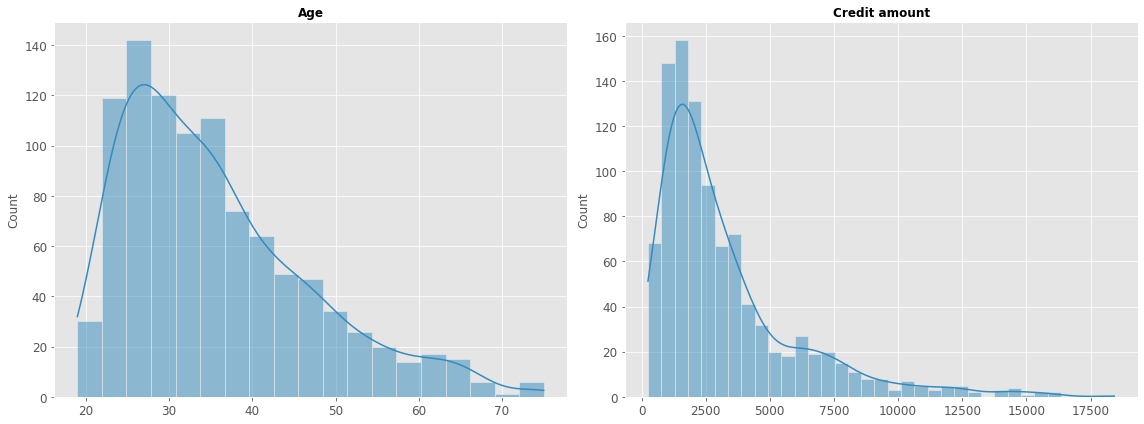

In [12]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ax = ax.flat

for i, col in enumerate(df_num[['Age','Credit amount']].columns):
    sns.histplot(data = df_num, x = col, ax = ax[i], kde = True)
    ax[i].set_title(col, fontsize = 12, fontweight = 'bold')
    ax[i].tick_params(labelsize = 12)
    ax[i].set_xlabel('')

f.tight_layout()

Estas variables presentan algunos valores atípicos, principalmente, la variable `Credit amount`. Veamos cómo se ven sus boxplots.

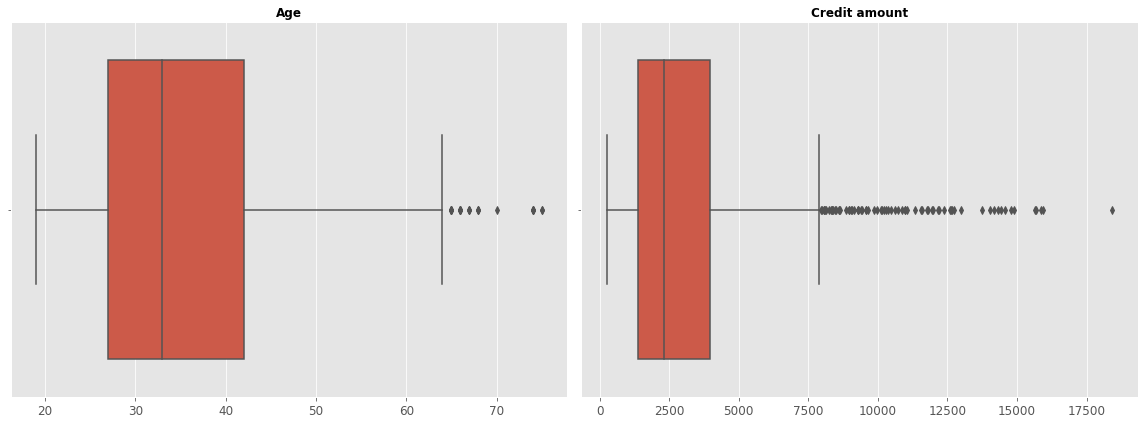

In [13]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ax = ax.flat

for i, col in enumerate(df_num[['Age','Credit amount']].columns):
    sns.boxplot(data = df_num, x = col, ax = ax[i])
    ax[i].set_title(col, fontsize = 12, fontweight = 'bold')
    ax[i].tick_params(labelsize = 12)
    ax[i].set_xlabel('')

f.tight_layout()

Efectivamente, en ambas variables existen valores atípicos en la parte superior de su respectiva distribución. Sin embargo, aún no podemos saber cuáles valores son los extremos, por lo que, nos apoyaremos en los estadísticos básicos y en tablas de frecuencias.

In [14]:
df_num[['Age']].describe().T

count    mean        std   min   25%   50%   75%   max
Age  1000.0  35.546  11.375469  19.0  27.0  33.0  42.0  75.0

In [15]:
df_num[['Age', 'Credit amount']].groupby('Age', as_index = False) \
    .size().sort_values(by = 'Age').tail(10)

Age  size
43   62     2
44   63     8
45   64     5
46   65     5
47   66     5
48   67     3
49   68     3
50   70     1
51   74     4
52   75     2

La edad promedio es de 35 años y la máxima es de 75 años de la cual sólo hay 2 observaciones. El grueso de los clientes tiene menos de 40 años. La distribución de esta variable tiene sesgo positivo, porque su media es mayor a su mediana y moda.

Analicemos la variable `Credit amount`.

In [16]:
df_num[['Credit amount']].describe().T

count      mean          std    min     25%     50%      75%  \
Credit amount  1000.0  3271.258  2822.736876  250.0  1365.5  2319.5  3972.25   

                   max  
Credit amount  18424.0

In [17]:
df_num[['Age', 'Credit amount']].groupby('Credit amount', as_index = False) \
    .size().sort_values(by = 'Credit amount').tail(10)

Credit amount  size
911          14318     1
912          14421     1
913          14555     1
914          14782     1
915          14896     1
916          15653     1
917          15672     1
918          15857     1
919          15945     1
920          18424     1

Dicha variable tiene más sesgo positivo (a la derecha), además, presenta muchos valores atípicos.

Continuamos con las variables discretas

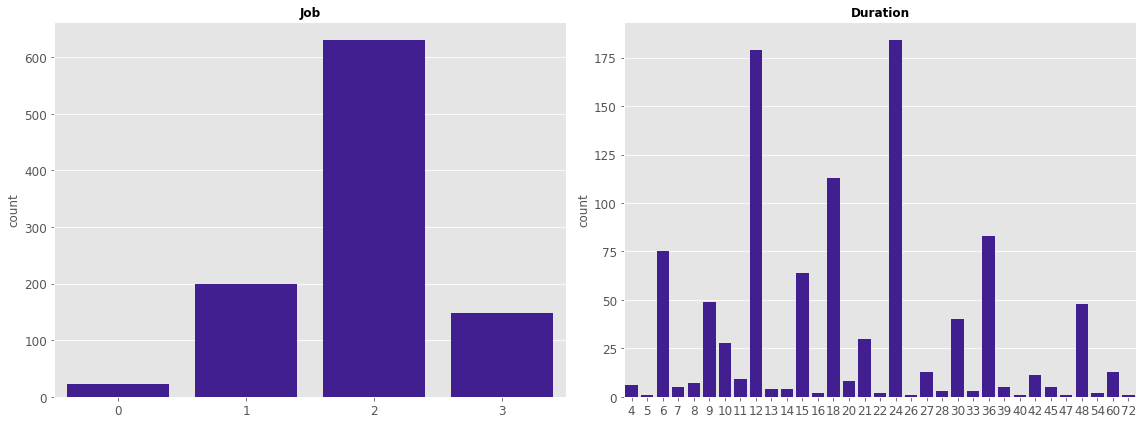

In [18]:
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ax = ax.flat

for i, col in enumerate(df_num.drop(columns = ['Age','Credit amount']).columns):
    sns.countplot(data = df_num, x = col, ax = ax[i], color = '#3A0CA3')
    ax[i].set_title(col, fontsize = 12, fontweight = 'bold')
    ax[i].tick_params(labelsize = 12)
    ax[i].set_xlabel('')

f.tight_layout()

En la primer gráfica podemos apreciar que hay muy pocas observaciones en la eqtiqueta `0` que corresponde a las personas no calificadas y no residentes. Veamos su tabla de frecuencias.

In [19]:
df_num.groupby('Job', as_index = False).size()

Job  size
0    0    22
1    1   200
2    2   630
3    3   148

La variable `Duration` es muy irregular, pues es muy diverso el número de meses que las personas tienen su crédito, pero se aprecia que predominan los plazos de 1 y 2 años.

In [20]:
df_num.groupby('Duration', as_index = False).size()

Duration  size
0          4     6
1          5     1
2          6    75
3          7     5
4          8     7
5          9    49
6         10    28
7         11     9
8         12   179
9         13     4
10        14     4
11        15    64
12        16     2
13        18   113
14        20     8
15        21    30
16        22     2
17        24   184
18        26     1
19        27    13
20        28     3
21        30    40
22        33     3
23        36    83
24        39     5
25        40     1
26        42    11
27        45     5
28        47     1
29        48    48
30        54     2
31        60    13
32        72     1

### Variables no numéricas

A continuación, se revisan las variables no numéricas.

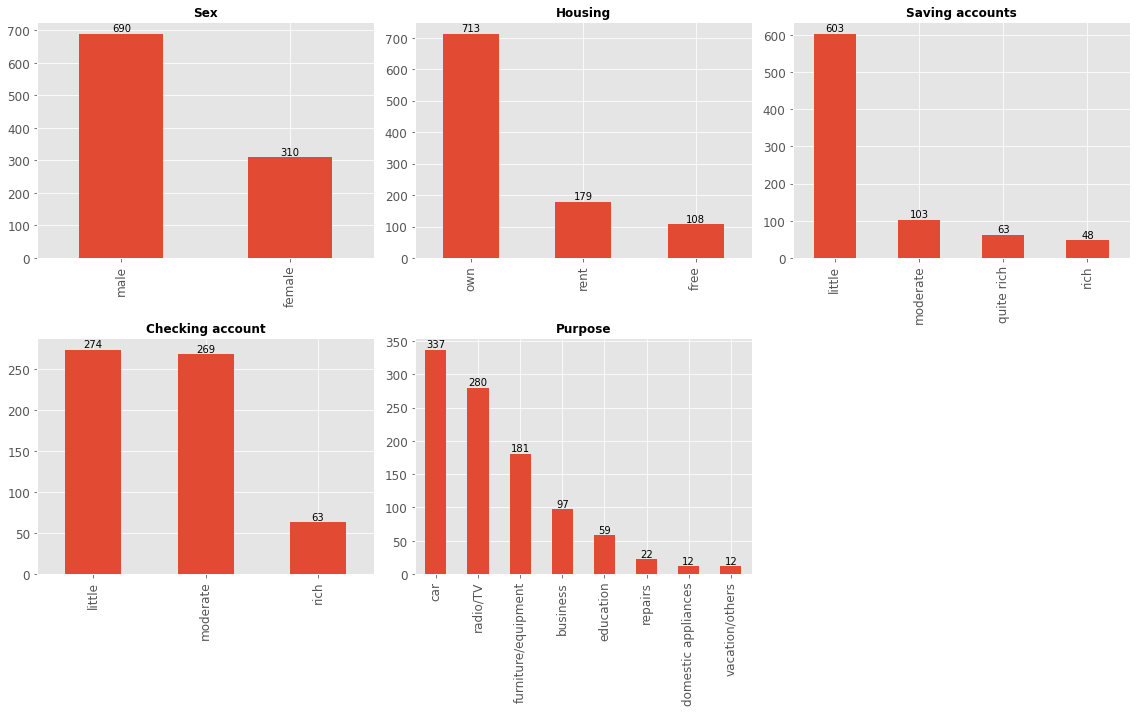

In [21]:
f, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 10))

ax = ax.flat

for i, col in enumerate(df_cat.columns):
    df_cat[col].value_counts().plot.bar(ax = ax[i])
    ax[i].set_title(col, fontsize = 12, fontweight = 'bold')
    ax[i].tick_params(labelsize = 12)
    ax[i].bar_label(ax[i].containers[0])

f.tight_layout()
f.delaxes(ax[5])

De las gráficas anteriores podemos concluir lo siguiente:

* Hay más del doble de personas del sexo masculino.
* Predominan las personas que tienen casa propia.
* Las cuentas de ahorro con pocos recursos es la categoría mayoritaria.
* Son pocas las personas que tienen cuentas de cheques con altos recursos.
* El principal propósito reportado para utilizar el crédito solicitado es para comprar autos.

Veamos las etiquetas en porcentaje para tener más claridad sobre los datos.

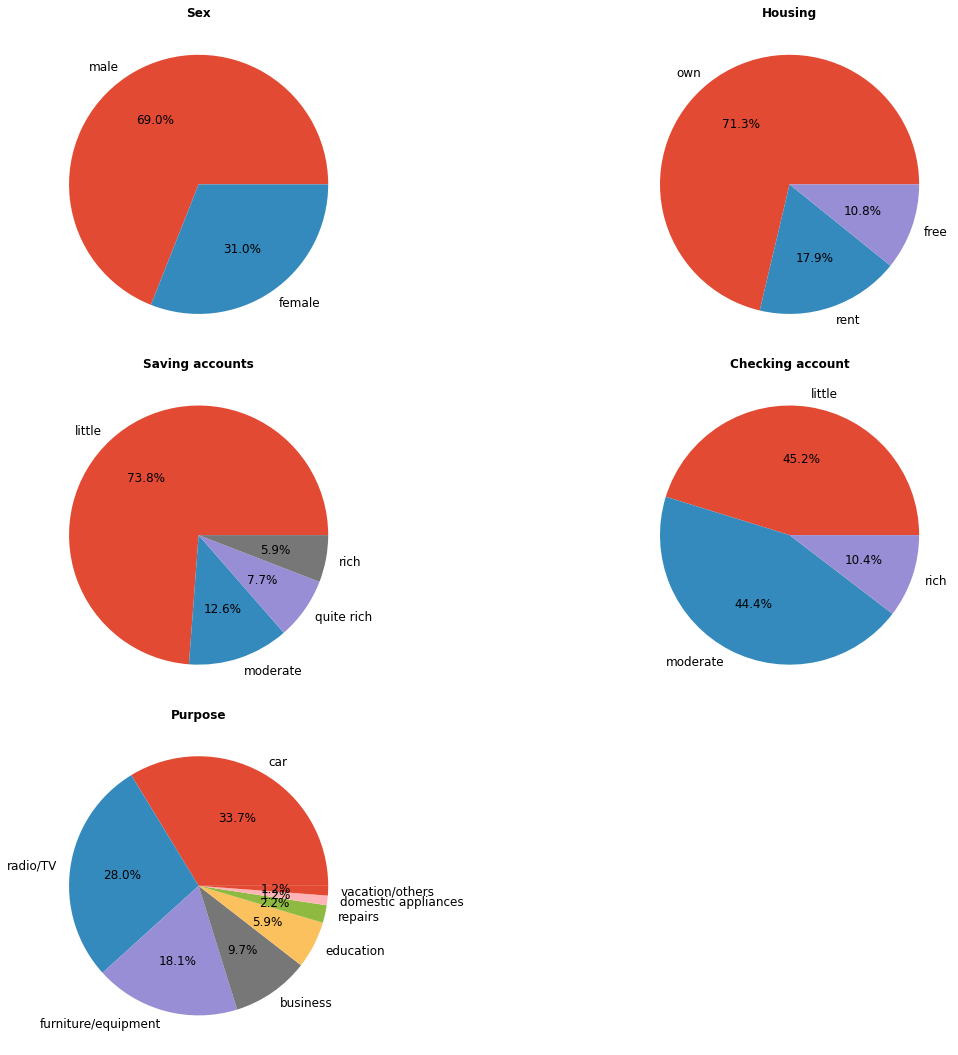

In [22]:
f, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (16, 15))

ax = ax.flat

for i, col in enumerate(df_cat.columns):
    ax[i].pie(df_cat[col].value_counts(), labels = df_cat[col].value_counts().index,
              autopct = '%1.1f%%', textprops = {'fontsize':12})
    ax[i].set_title(col, fontsize = 12, fontweight = 'bold')
    ax[i].tick_params(labelsize = 18)

f.tight_layout()
f.delaxes(ax[5])

## Análisis multivariante

<div class=text-justify>
En esta parte del análisis exploratorio se analizan las relaciones entre las distintas variables, para conocer si hay correlaciones lineales o no lineales y su intensidad. Lo anterior, porque el algoritmo a usar más adelante será el k-means, cuya característica es que no funciona muy bien con la presencia de multicolinealidad (variables redundantes).
</div>

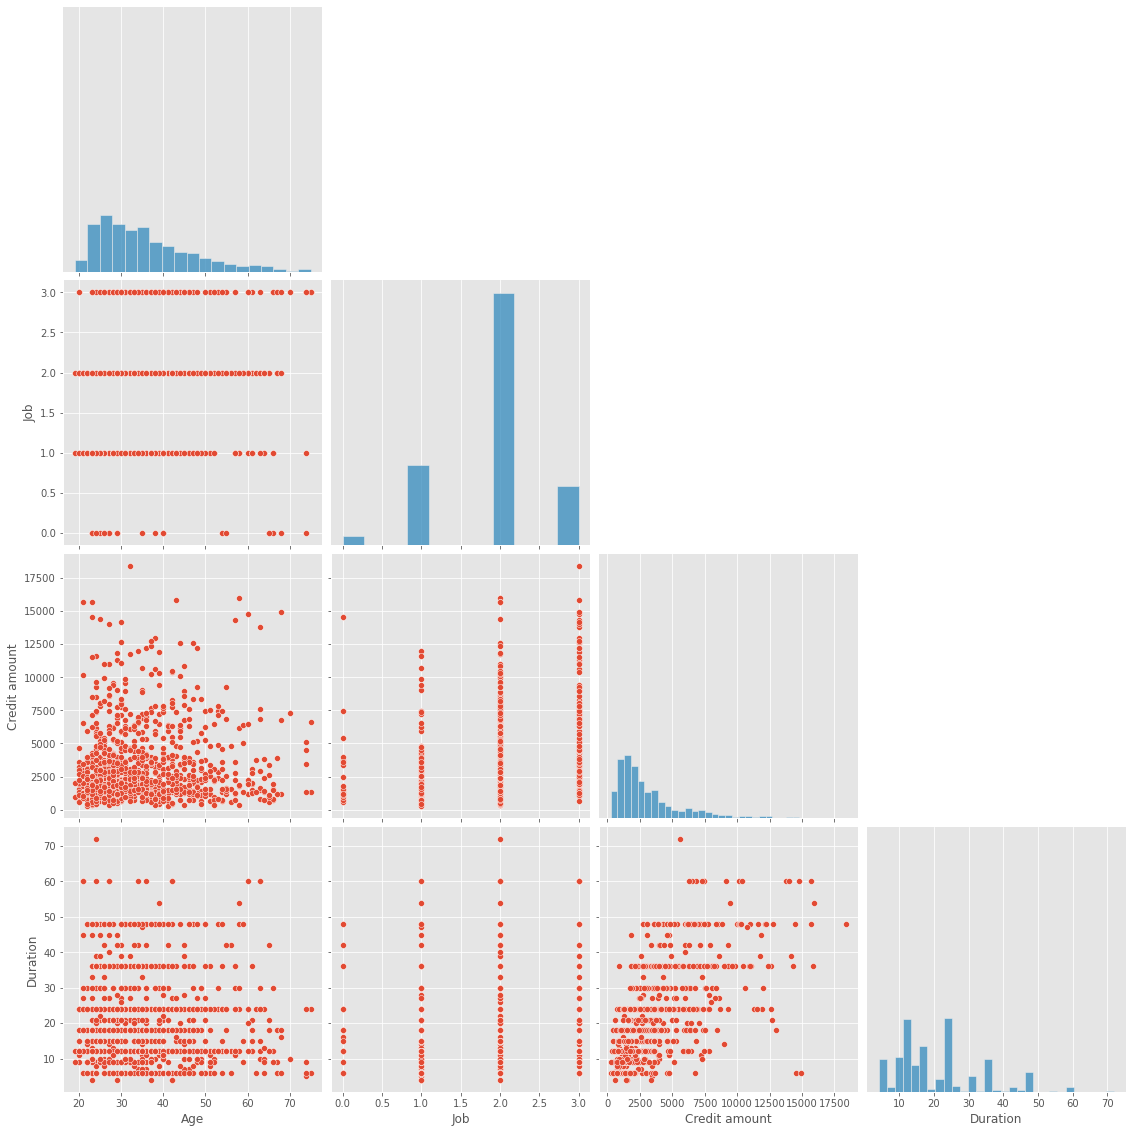

In [23]:
sns.pairplot(df[["Age", "Job", "Credit amount", "Duration"]], height = 4, aspect= 1, corner = True);

De la matriz de gráficos anterior, se puede apreciar que al parecer existe correlación lineal entre las variables `Credit amount` y `Duration`. Con apoyo de una función veamos su intensidad o coeficiente.

In [24]:
def corrs(df, method = 'pearson', drop_dup = True):
    
    if method == 'pearson':
        
        fmatrix = df.values
        rows, cols = fmatrix.shape

        r = np.ones((cols, cols), dtype = float)
        p = np.ones((cols, cols), dtype = float)

        for i in range(cols):
            for j in range(cols):
                if i == j:
                    r_, p_ = 1., 1.
                else:
                    r_, p_ = stats.pearsonr(fmatrix[:,i], fmatrix[:,j])

                r[j][i] = r_
                p[j][i] = p_

        cp = pd.DataFrame(abs(r), columns = df.columns, index = df.columns)
        cp = cp.unstack()
        cp = pd.DataFrame(cp).reset_index()
        cp.columns = ['var1', 'var2', 'corrs']
        
        pp = pd.DataFrame(p, columns = df.columns, index = df.columns)
        pp = pp.unstack()
        pp = pd.DataFrame(pp).reset_index()
        pp.columns = ['var1', 'var2', 'pvalue']
        pp.drop(columns = ['var1', 'var2'], inplace = True)
        
        resp = pd.concat(objs = [cp, pp], axis = 1)
        resp = resp.sort_values(by = 'corrs', ascending = False)

        resp = resp if drop_dup == False else resp.drop_duplicates(subset = 'corrs')
        
        if (resp.iloc[0,:][0] == resp.iloc[0,:][1]) == True:

            resp = resp.drop(index = 0, axis = 0)
            return (resp)

        else:

            return(resp)
        
    else:
        
        corr_matrix, p_matrix = stats.spearmanr(df)

        c = pd.DataFrame(abs(corr_matrix), columns = df.columns, index = df.columns)
        c = c.unstack()
        c = pd.DataFrame(c).reset_index()
        c.columns = ['var1', 'var2', 'corrs']
        c.corrs = round(c.corrs, 6)

        p = pd.DataFrame(p_matrix, columns = df.columns, index = df.columns)
        p = p.unstack()
        p = pd.DataFrame(p).reset_index()
        p.columns = ['var1', 'var2', 'pvalue']
        p.drop(columns = ['var1', 'var2'], inplace = True)

        res = pd.concat(objs = [c, p], axis = 1)
        res = res.sort_values(by = 'corrs', ascending = False)

        res = res if drop_dup == False else res.drop_duplicates(subset = 'corrs')

        if (res.iloc[0,:][0] == res.iloc[0,:][1]) == True:

            res = res.drop(index = 0, axis = 0)
            return (res)

        else:

            return(res)
    
    return (res)

In [25]:
corrs(df_num, method = 'pearson')

var1           var2     corrs         pvalue
11  Credit amount       Duration  0.624984  1.862851e-109
6             Job  Credit amount  0.285385   3.400905e-20
7             Job       Duration  0.210910   1.615414e-11
3             Age       Duration  0.036136   2.535887e-01
2             Age  Credit amount  0.032716   3.013388e-01
1             Age            Job  0.015673   6.205723e-01

<div class=text-justify>
En la tabla de las correlaciones lineales, las variables <i>Credit amount</i> y <i>Duration</i> presentan la correlación más alta, lo cual era de esperarse, pues a los créditos más altos se les otorgan plazos mayores. Sin embargo, estas son correlaciones lineales y recordemos que tenemos variables ordinales como <i>Duration</i> y <i>Job</i>, por lo que, lo correcto es calcular la correlación de <i>spearman</i>.
</div>

In [26]:
corrs(df_num, method = 'spearman')

var1           var2     corrs         pvalue
11  Credit amount       Duration  0.624709  2.469459e-109
6             Job  Credit amount  0.298345   5.255018e-22
7             Job       Duration  0.227266   3.511429e-13
1             Age            Job  0.041327   1.916254e-01
3             Age       Duration  0.036316   2.512300e-01
2             Age  Credit amount  0.026298   4.061243e-01

<div class=text-justify>
Vemos que las correlaciones aumentaron un poco con este otro método. Sin embargo, es necesario complementar este análisis revisando la significancia estadística (p-valores) de esos coeficientes de correlación, porque, si por ejemplo, esa correlación de 0.6247 hubiera tenido un p-valor mayor a 0.05 significaría que esa correlación no es estadísticamente significativa y entonces se descartaría ese valor y no podríamos afirmar que existe alguna relacion entre ambas variables. Afortunadamente, todas las correlaciones resultaron significativas. Ya solo falta detectar si hay la posibilidad de que exista multicolinealidad entre estas variables. Para lo anterior, se usará el <b>Factor de Inflación de varianza (VIF)</b>.
</div>

In [27]:
def vif(df):
    
    X = df

    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]
    return(vif_data)

In [28]:
vif(df_num)

Variable       VIF
0            Age  5.672031
1            Job  6.998974
2  Credit amount  3.946969
3       Duration  6.002435

Vemos en los resultados que en este conjunto de variables numéricas hay presencia de multicolinealidad. Recordemos que valores entre 5 y 10 tenemos multicolinealidad moderada y más de 10 tenemos multicoliealidad alta. Más adelante tendremos que arreglar esto, por lo pronto, sigamos adelante.

Continuemos con el análisis multivariante para ver las interacciones entre las variables.

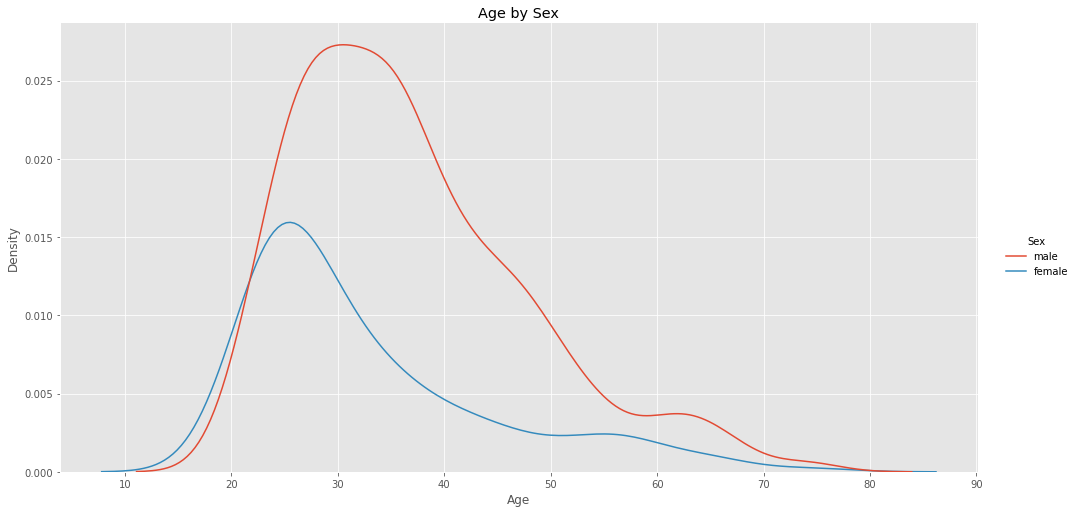

In [29]:
sns.displot(data = df, kind = 'kde', x = 'Age', hue = 'Sex',height = 7, aspect= 2).set(title = 'Age by Sex');

En la gráfica anterior, se aprecia que la edad predominante en los hombres es de 30 años, aproximadamente, y en las mujeres es de 25 años. Al parecer, es en el grupo de las mujeres en donde se encuentran las mayores edades. Veamos si esto es cierto con apoyo de una tabla.

In [30]:
df[['Age', 'Sex']].sort_values(by = 'Age', ascending = False).head(10)

Age     Sex
330   75    male
536   75  female
186   74  female
756   74    male
430   74    male
606   74    male
163   70    male
917   68    male
846   68    male
187   68    male

In [31]:
def plots1(df, variable, hue, xs):
    
    fig = plt.figure(figsize = (18, 11))
    
    # primer grafico (0,0)
    ax1 = plt.subplot2grid((2, 2), (0, 0), 1, 1)
    
    sns.kdeplot(data = df, x = variable, hue = hue, ax = ax1).set(title = '{} by {}'.format(variable,hue));
    
    # segundo grafico (0,1)
    ax2 = plt.subplot2grid((2, 2), (0, 1), 1, 1)
    
    sns.scatterplot(data = df, x = xs, y = variable, ax = ax2).set(title = '{} by {}'.format(variable, xs));
    
    # tercer grafico (1,0)
    ax3 = plt.subplot2grid((2, 2), (1, 0), 1, 2)
    
    sns.lineplot(data = df, x = xs, y = variable, hue = hue, ci = None, ax = ax3).set(title = '{} by {} and {}'.format(variable,xs,hue));
    
    plt.suptitle('Comparativo: {} - {} - {}'.format(variable, xs, hue), size = 18)
    plt.show()

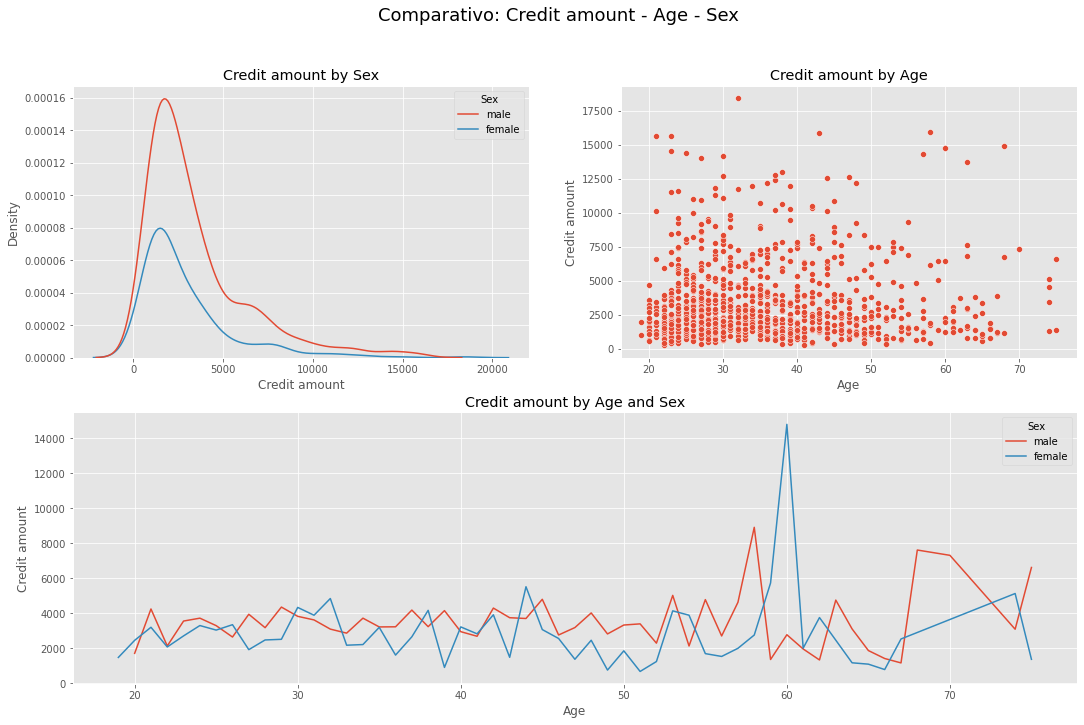

In [32]:
plots1(df, variable = 'Credit amount', hue = 'Sex', xs = 'Age')

En las graficas superiores, se aprecia que las mujeres de 60 años han recibido los mayores créditos, probablemente, este caso sea un valor atípico. Hagamos un zoom para ver con más detalle este comportamiento.

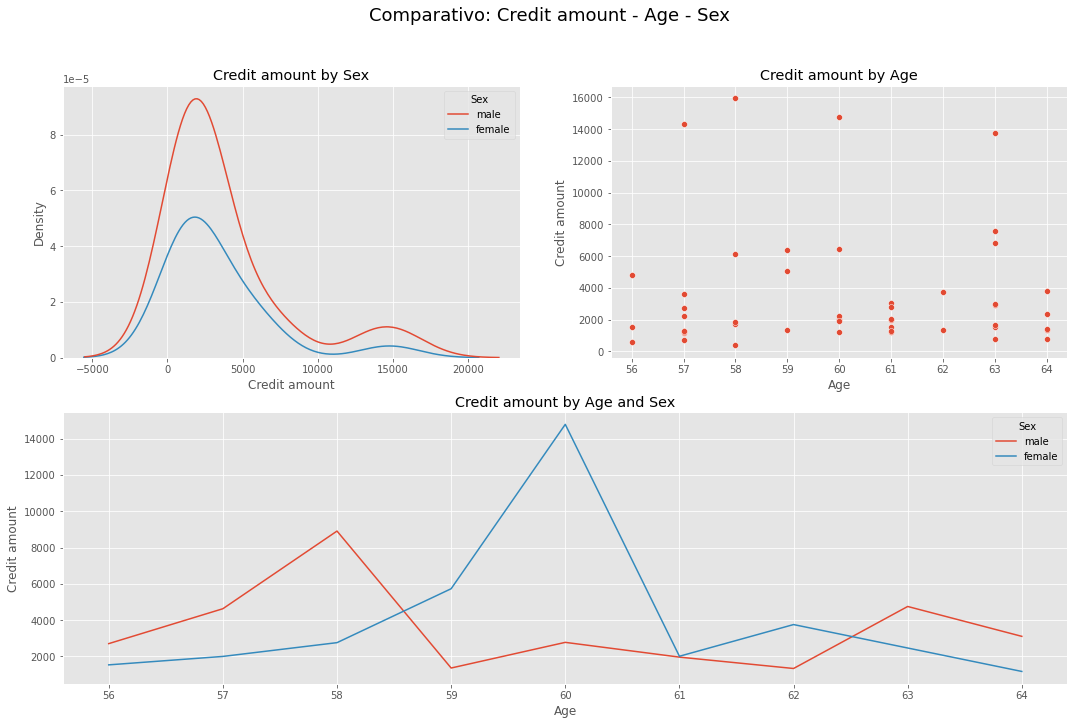

In [33]:
plots1(df[(df.Age> 55) & (df.Age < 65)], variable = 'Credit amount', hue = 'Sex', xs = 'Age')

Vemos que efectivamente parece que hay presencia de valores atípicos, sin embargo, no se sabe si es uno o más. Por lo que, hay que hacer una tabla para filtrar los datos y confirmar o descartar lo anterior.

In [34]:
df.loc[df.Age == 60, ['Age','Sex', 'Credit amount']]

Age     Sex  Credit amount
13    60    male           1199
374   60  female          14782
541   60    male           2032
589   60    male           2246
781   60    male           1940
784   60    male           6468

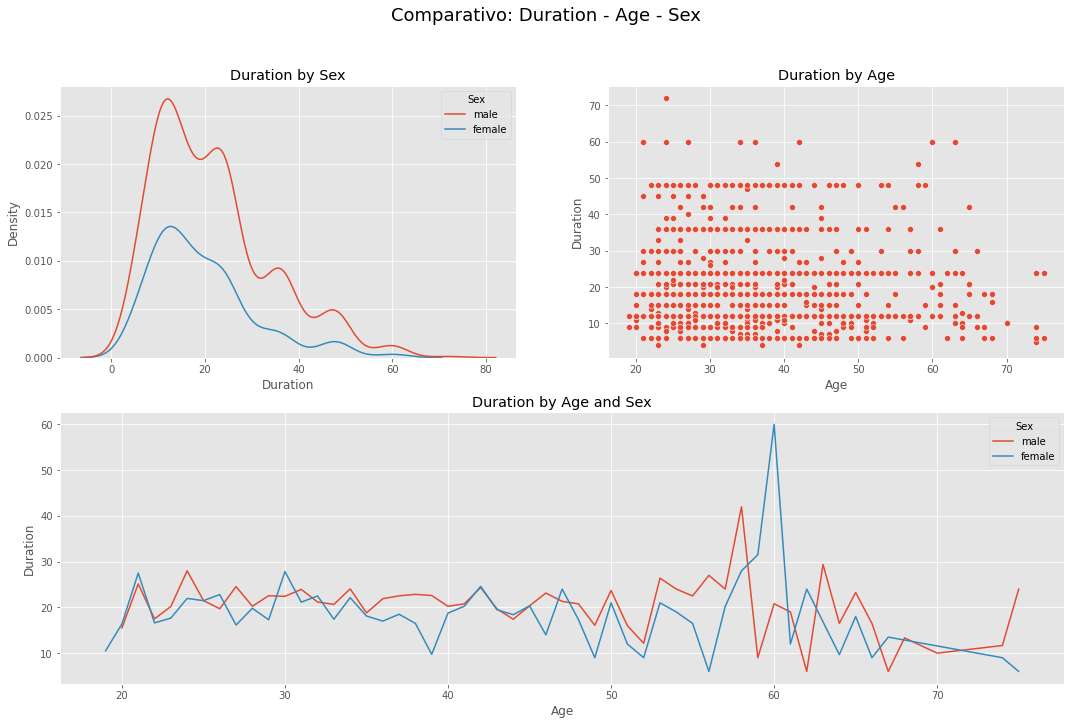

In [35]:
plots1(df, variable = 'Duration', hue = 'Sex', xs = 'Age')

En este otro grupo de gráficas se aprecia el mismo comportamiento, ya que el crédito más alto corresponde con el periodo de duración mayor.

Continuemos con el análisis visual multivariabte para tratar de detectar cuáles variables pueden ser buenas segmentadoras, o sea, se buscan varaibles que separen bien la data.

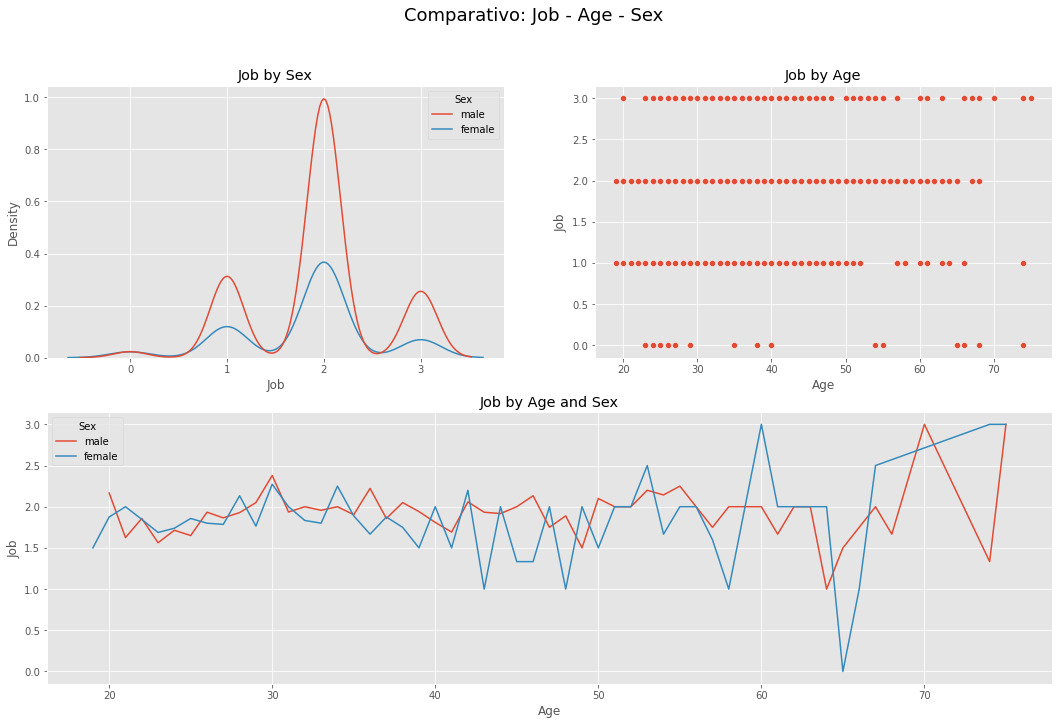

In [36]:
plots1(df, variable = 'Job', hue = 'Sex', xs = 'Age')

In [37]:
def plot2(df, x_cat, y_cont, by = None):

    f, ax = plt.subplots(figsize = (16, 8))

    sns.boxplot(data = df, x = x_cat, y = y_cont, hue = by);
    ax.set_title('{} by {}'.format(x_cat, y_cont), fontsize = 12, fontweight = 'bold')
    ax.tick_params(labelsize = 12)
    ax.set_xlabel(x_cat)

    f.tight_layout()

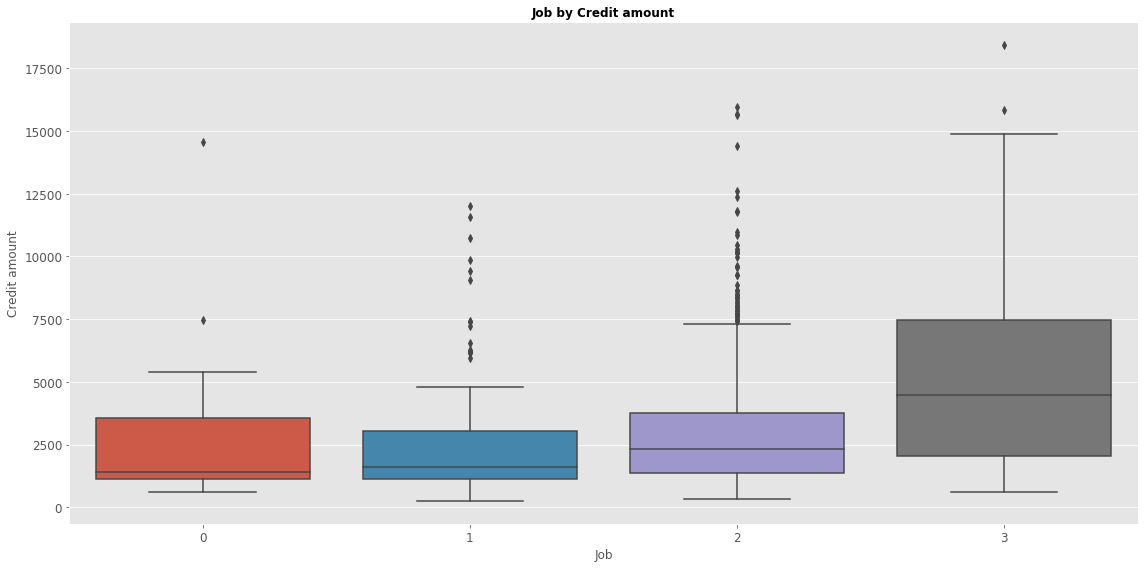

In [38]:
plot2(df = df, x_cat = 'Job', y_cont = 'Credit amount')

En la gráfica de arriba se aprecia que los clientes con trabajos altamente calificados (grupo 3) son a los que se les conceden créditos mayores. Algo que salta aquí es que el grupo de clientes no calificados y no residentes (grupo 0), presenta montos atípicos elevados.

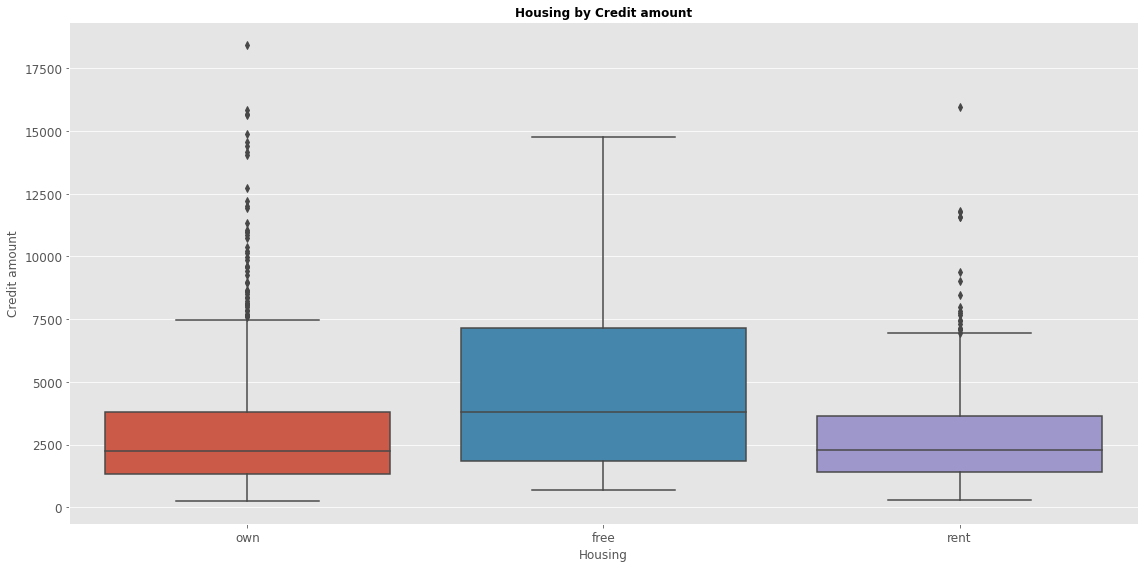

In [39]:
plot2(df = df, x_cat = 'Housing', y_cont = 'Credit amount')

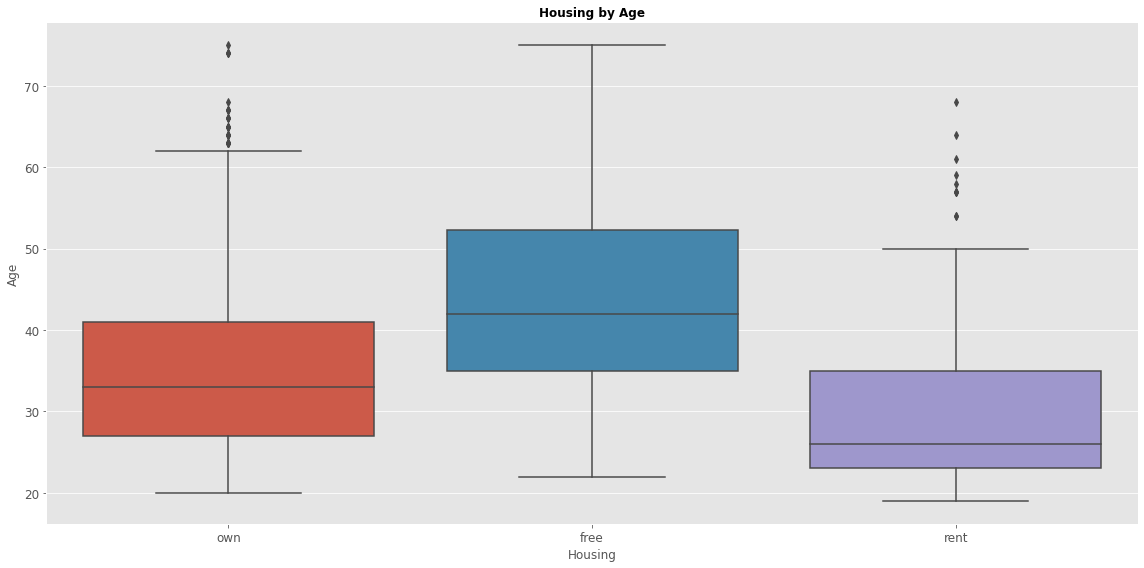

In [40]:
plot2(df = df, x_cat = 'Housing', y_cont = 'Age')

Los clientes que reportaron alojamiento gratis se les concedieron créditos mayores y no presentaron valores atípicos. Además, las edades de este grupo está, principalmente, en el rango de 35 a 52 años.

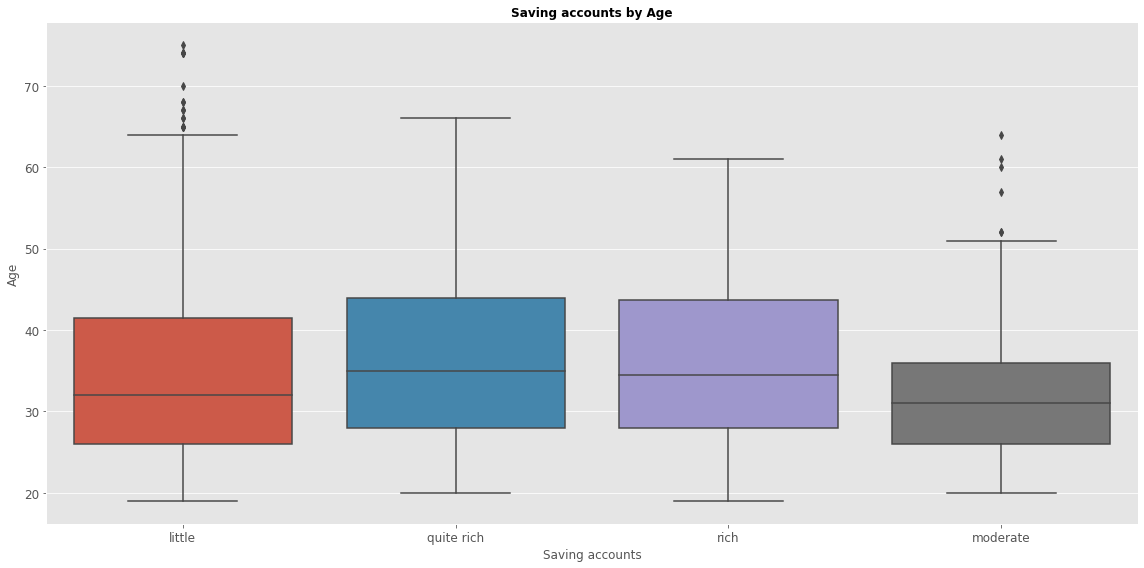

In [41]:
plot2(df = df, x_cat = 'Saving accounts', y_cont = 'Age')

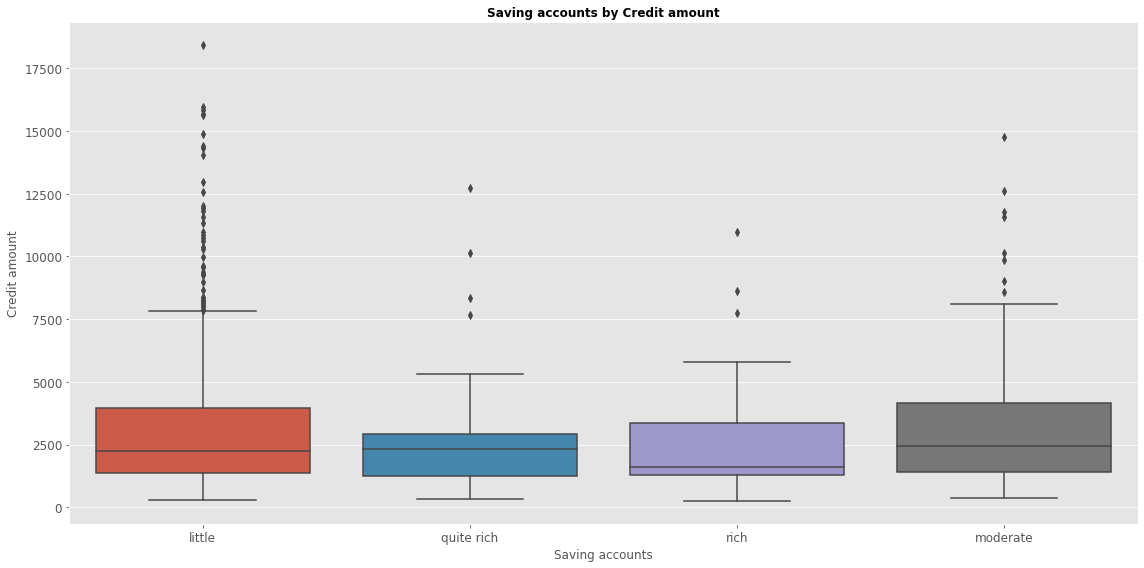

In [42]:
plot2(df = df, x_cat = 'Saving accounts', y_cont = 'Credit amount')

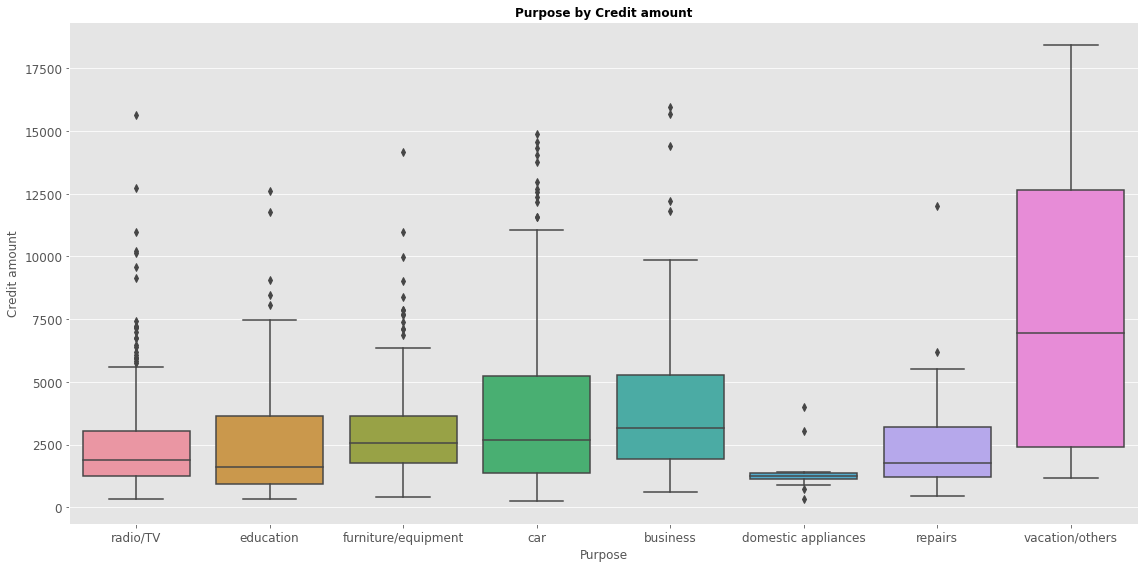

In [43]:
plot2(df = df, x_cat = 'Purpose', y_cont = 'Credit amount')

En la gráfica anterior, se aprecia que los créditos más altos van dirigidos a vacaciones y otros, ya que el 50% de los clientes que declararon ese uso, los créditos van desde 2500 hasta 12,500. Por el contrario, el concepto de usos domésticos es el rubro con menores importes de crédito.

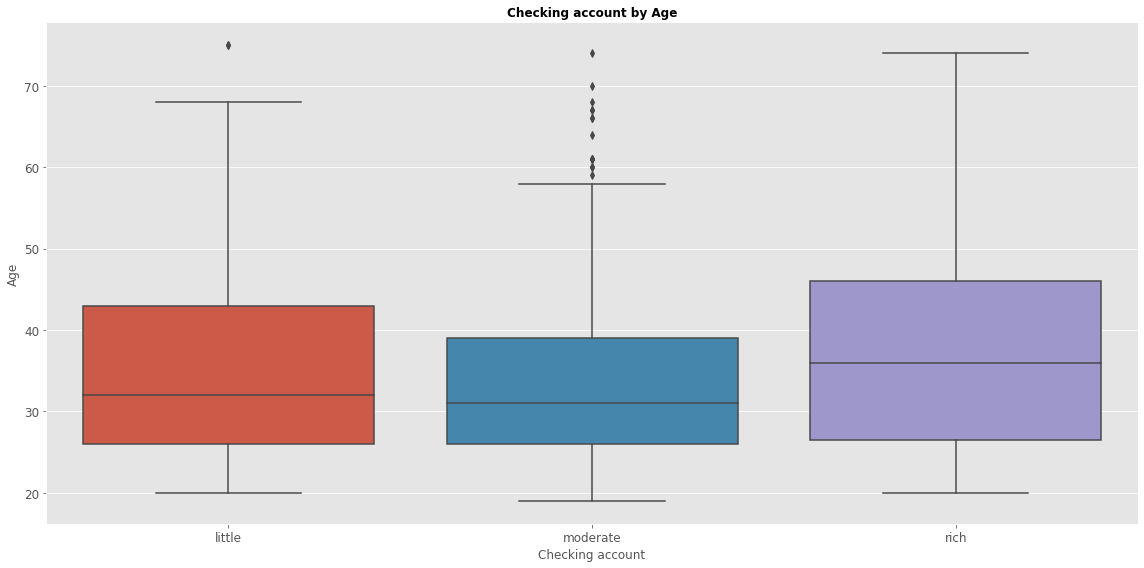

In [44]:
plot2(df = df, x_cat = 'Checking account', y_cont = 'Age')

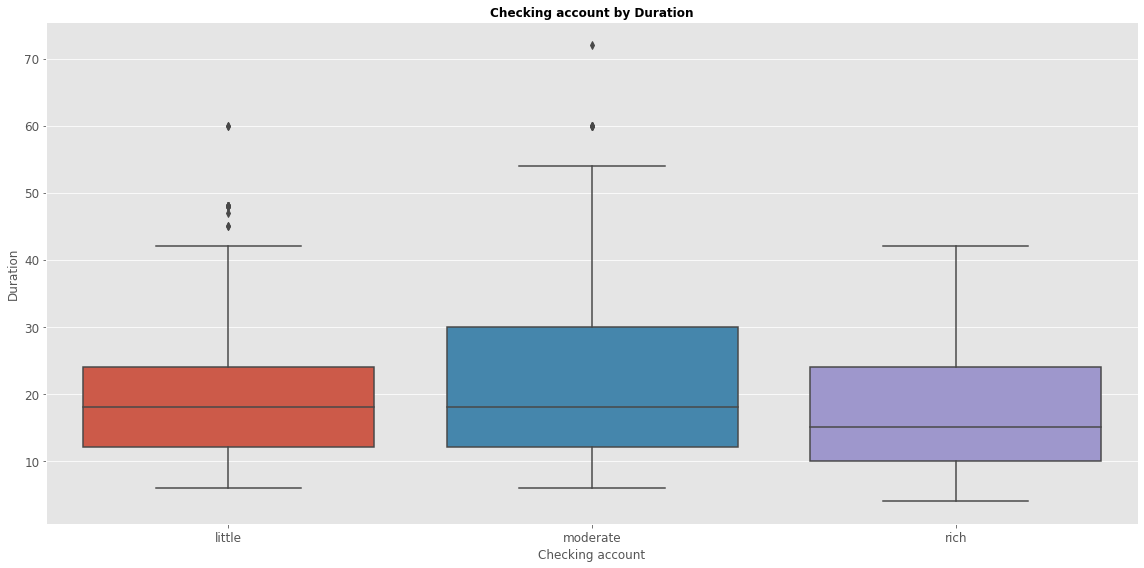

In [45]:
plot2(df = df, x_cat = 'Checking account', y_cont = 'Duration')

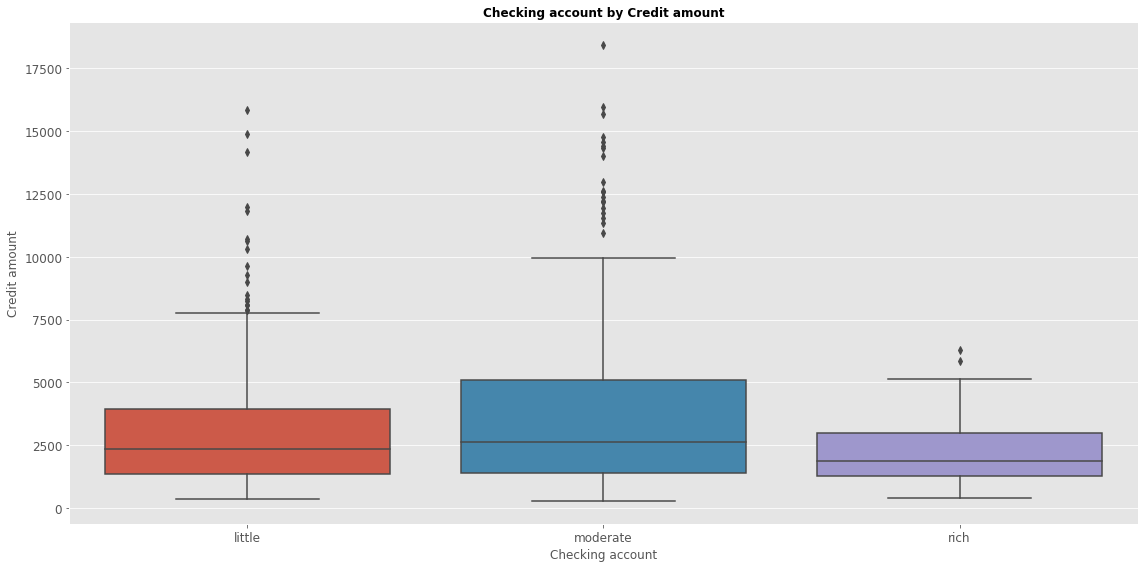

In [46]:
plot2(df = df, x_cat = 'Checking account', y_cont = 'Credit amount')

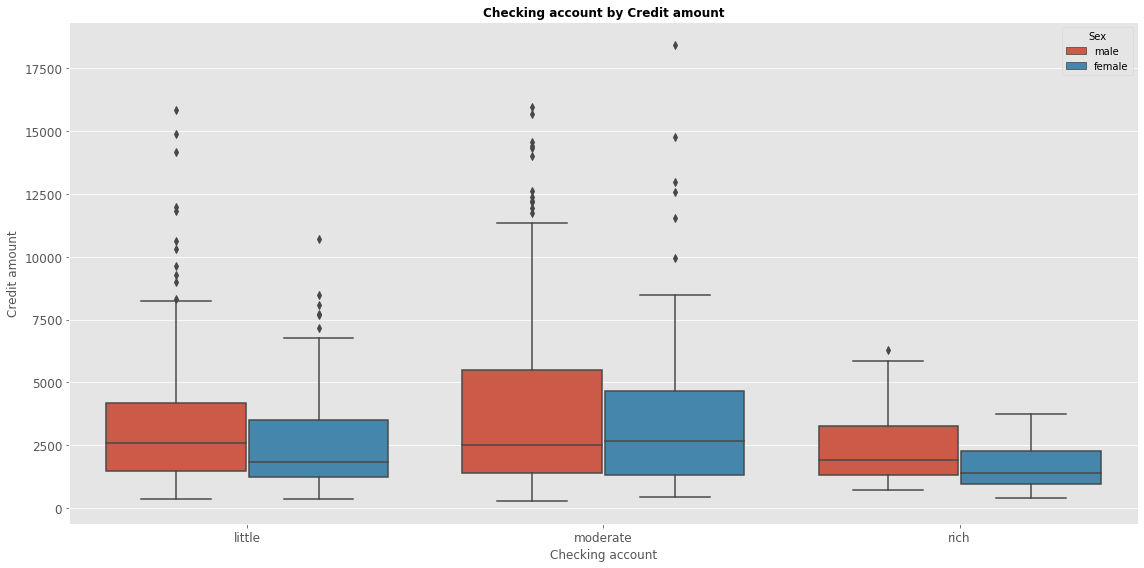

In [47]:
plot2(df = df, x_cat = 'Checking account', y_cont = 'Credit amount', by = 'Sex')

En la gráfica de arriba, se ve cómo a los hombres se les aprobaron créditos mayores en todos los segmentos correspondientes a las distintas cuentas de cheques.

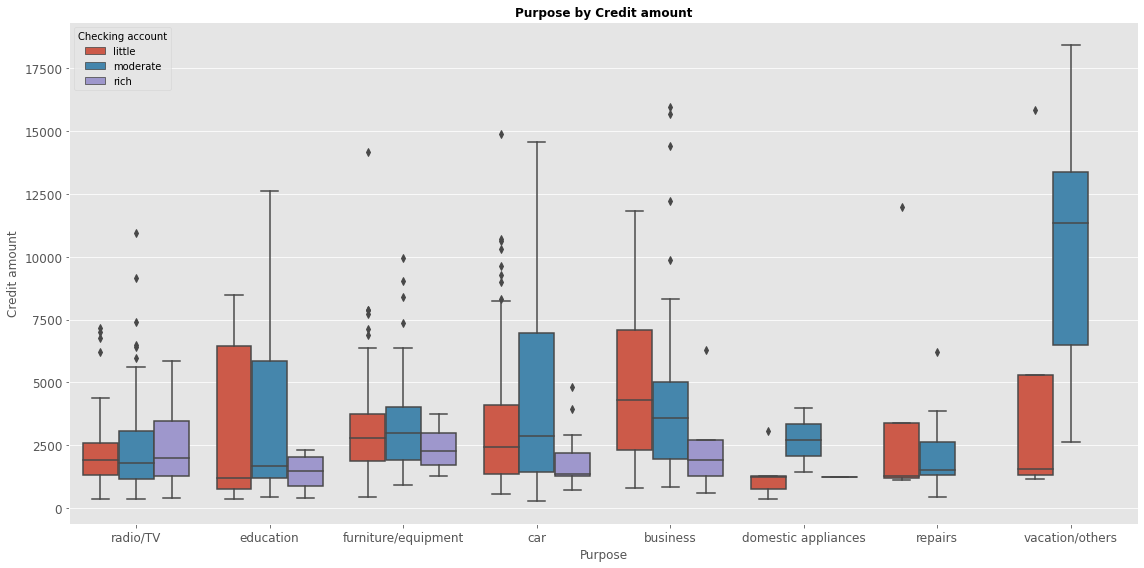

In [48]:
plot2(df = df, x_cat = 'Purpose', y_cont = 'Credit amount', by = 'Checking account')

Los créditos más altos fueron dirigidos a clientes con cuentas de cheques moderadas y para vacaciones, seguido para autos y negocios (éste último en el grupo de clientes con cuentas de cheques pequeñas).

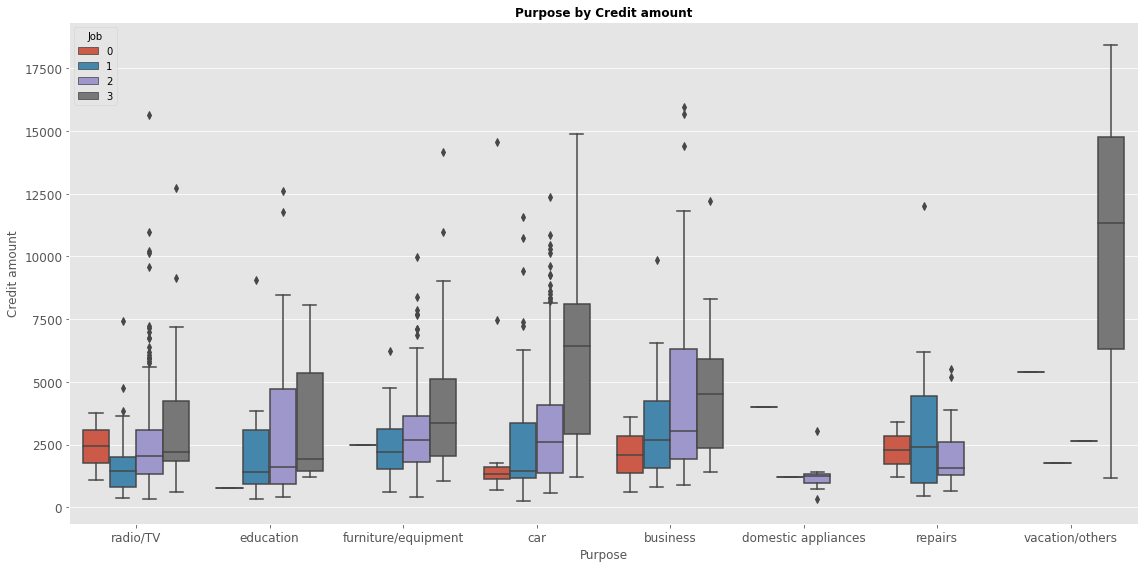

In [49]:
plot2(df = df, x_cat = 'Purpose', y_cont = 'Credit amount', by = 'Job')

En la gráfica anterior, se aprecia claramente como a los clientes con trabajos altamente calificados fueron a los que se les concedieron los créditos mayores.

### Análisis de Correspondencia Múltiple (MCA)

Vamos a provechar esta sección para hacer un análisis de correspondencia. El Análisis de Correspondencia Múltiple (MCA) es un método de Aprendizaje Automático no supervisado que se utiliza para verificar si existe una relación entre más de 2 variables categóricas. Usaremos la prueba de chi-cuadrado (χ2) para cada par de variables categóricas para verificar si las variables muestran una asociación con al menos una de las otras variables.

Primero, vamos a crear una copia del dataframe para hacer este análisis y, por conveniencia, crearemos algunas variables categóricas que nos servirán de apoyo para encontrar patrones en los datos.

In [50]:
df_mca = df.copy()

Antes de crear las nuevas variables arreglemos los datos faltantes. Estos se dan en las siguientes variables:

In [51]:
df_mca.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

En estas variables los datos que faltan muy probablemente se deba a que los clientes reportaron no tener cuenta de ahorro o cuenta de cheques, por lo que, se rellenarán esos valores con la etiqueta "None".

In [52]:
df_mca['Checking account'] = df_mca['Checking account'].fillna('None')
df_mca['Saving accounts'] = df_mca['Saving accounts'].fillna('None')

df_mca.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

La variable `Age`, se discretizará inicialmente en 3 tramos: 

1. Joven (menor a 36 años)
2. Adulto (entre 36 y 64 años)
3. Adulto_mayor (mayor a 64 años)

In [53]:
def age_disc(edad):
    
    if edad <= 35:
        return "01_Joven"
    elif 35 < edad <= 64:
        return "02_Adulto"
    elif edad > 64:
        return "03_Adulto_Mayor"
    else:
        return "ERROR"

In [54]:
df_mca['Age_disc'] = df_mca['Age'].apply(lambda x: age_disc(x))
df_mca.head(10)

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own            None           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little             None           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   
5   35    male    1    free            None             None           9055   
6   53    male    2     own      quite rich             None           2835   
7   35    male    3    rent          little         moderate           6948   
8   61    male    1     own            rich             None           3059   
9   28    male    3     own          little         moderate           5234   

   Duration              Purpose         Age_disc  
0         6             radio/TV  03_Adulto_Mayor  
1        48             radio/TV         01_Joven  
2        12            education        02_Adulto  
3        42  furniture/equipment        02_Adulto  
4        24                  car        02_Adulto  
5        36            education         01_Joven  
6        24  furniture/equipment        02_Adulto  
7        36                  car         01_Joven  
8        12             radio/TV        02_Adulto  
9        30                  car         01_Joven

In [55]:
df_mca.Age_disc.value_counts()

01_Joven           588
02_Adulto          389
03_Adulto_Mayor     23
Name: Age_disc, dtype: int64

Vamos a recodificar la variable `Job`:

In [56]:
jobs = {0: 'unskilled and non-resident',
        1: 'unskilled and resident', 
        2: 'skilled', 
        3: 'highly skilled'}

df_mca['Job'] = df_mca['Job'].map(jobs)

df_mca

Age     Sex                     Job Housing Saving accounts  \
0     67    male                 skilled     own            None   
1     22  female                 skilled     own          little   
2     49    male  unskilled and resident     own          little   
..   ...     ...                     ...     ...             ...   
997   38    male                 skilled     own          little   
998   23    male                 skilled    free          little   
999   27    male                 skilled     own        moderate   

    Checking account  Credit amount  Duration    Purpose         Age_disc  
0             little           1169         6   radio/TV  03_Adulto_Mayor  
1           moderate           5951        48   radio/TV         01_Joven  
2               None           2096        12  education        02_Adulto  
..               ...            ...       ...        ...              ...  
997             None            804        12   radio/TV        02_Adulto  
998           little           1845        45   radio/TV         01_Joven  
999         moderate           4576        45        car         01_Joven  

[1000 rows x 10 columns]

Vamos a combinar las varaibles de `Sex` con `Age_disc` para que en una sola variable tengamos la información de ambas:

1. MJ (Male Joven)
2. FJ (Female Joven)
3. MA (Male Adulto)
4. FA (Female Adulto)
5. MAM (Male Adulto Mayor)
6. FAM (Female Adulto Mayor)

In [57]:
df_mca['Age_sex'] = np.where(((df_mca.Sex == 'male') & (df_mca.Age_disc == '01_Joven')), 'MJ',
                             np.where(((df_mca.Sex == 'female') & (df_mca.Age_disc == '01_Joven')), 'FJ',
                             np.where(((df_mca.Sex == 'male') & (df_mca.Age_disc == '02_Adulto')), 'MA',
                             np.where(((df_mca.Sex == 'female') & (df_mca.Age_disc == '02_Adulto')), 'FA',
                             np.where(((df_mca.Sex == 'male') & (df_mca.Age_disc == '03_Adulto_Mayor')), 'MAM',
                             np.where(((df_mca.Sex == 'female') & (df_mca.Age_disc == '03_Adulto_Mayor')), 'FAM',
                             'ERROR'))))))
df_mca.head(10)

Age     Sex                     Job Housing Saving accounts  \
0   67    male                 skilled     own            None   
1   22  female                 skilled     own          little   
2   49    male  unskilled and resident     own          little   
3   45    male                 skilled    free          little   
4   53    male                 skilled    free          little   
5   35    male  unskilled and resident    free            None   
6   53    male                 skilled     own      quite rich   
7   35    male          highly skilled    rent          little   
8   61    male  unskilled and resident     own            rich   
9   28    male          highly skilled     own          little   

  Checking account  Credit amount  Duration              Purpose  \
0           little           1169         6             radio/TV   
1         moderate           5951        48             radio/TV   
2             None           2096        12            education   
3           little           7882        42  furniture/equipment   
4           little           4870        24                  car   
5             None           9055        36            education   
6             None           2835        24  furniture/equipment   
7         moderate           6948        36                  car   
8             None           3059        12             radio/TV   
9         moderate           5234        30                  car   

          Age_disc Age_sex  
0  03_Adulto_Mayor     MAM  
1         01_Joven      FJ  
2        02_Adulto      MA  
3        02_Adulto      MA  
4        02_Adulto      MA  
5         01_Joven      MJ  
6        02_Adulto      MA  
7         01_Joven      MJ  
8        02_Adulto      MA  
9         01_Joven      MJ

Finalmente, eliminamos las variables que no vamos a utilizar en el análisis:

In [58]:
df_mca.drop(columns = ['Age','Sex','Housing','Credit amount','Duration','Age_disc'], inplace = True)
df_mca

Job Saving accounts Checking account    Purpose  \
0                   skilled            None           little   radio/TV   
1                   skilled          little         moderate   radio/TV   
2    unskilled and resident          little             None  education   
..                      ...             ...              ...        ...   
997                 skilled          little             None   radio/TV   
998                 skilled          little           little   radio/TV   
999                 skilled        moderate         moderate        car   

    Age_sex  
0       MAM  
1        FJ  
2        MA  
..      ...  
997      MA  
998      MJ  
999      MJ  

[1000 rows x 5 columns]

<div class=text-justify>
Ahora ya podemos hacer el análisis de correspondencia múltiple con las cinco variables categóricas que tenemos. Pero antes, vamos a checar si existen dependencias entre las variables, ya que es recomendable que esto se cumpla para que tenga sentido el análisis de correspondencia. Aunque son análisis independientes es mejor trabajar con variables que tengan dependencias entre sí. Como se mencionó al inicio del apartado, se hará la prueba llamada chi2.
</div>

In [59]:
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency
from scipy import stats

In [60]:
keep_var = []

for i in range(0, len(df_mca.columns)):
    for j in range(0, len(df_mca.columns)):
        if df_mca.columns[i] != df_mca.columns[j]:
            tbl_cont = pd.crosstab(df_mca[df_mca.columns[i]], df_mca[df_mca.columns[j]])
            chi2, pvalor, gl, ve = stats.chi2_contingency(tbl_cont)
            if pvalor < 0.05:
                print(df_mca.columns[i])
                print(df_mca.columns[j])
                print(pvalor)
                print('\n')
                keep_var.append(df_mca.columns[i])
                keep_var.append(df_mca.columns[j])
            else: 
                pass
print('\n')
print('variables con alguna dependencia:')
print(list(set(keep_var)))

Job
Checking account
0.049395196074362324


Job
Purpose
3.3476980586763662e-09


Job
Age_sex
6.794142954321676e-12


Saving accounts
Checking account
1.6365301038541542e-14


Saving accounts
Age_sex
0.002887905558861904


Checking account
Job
0.049395196074362324


Checking account
Saving accounts
1.6365301038541542e-14


Checking account
Purpose
8.104243711852665e-05


Checking account
Age_sex
0.01348854172986117


Purpose
Job
3.3476980586763638e-09


Purpose
Checking account
8.104243711852665e-05


Purpose
Age_sex
0.0005023996266323616


Age_sex
Job
6.794142954321676e-12


Age_sex
Saving accounts
0.002887905558861904


Age_sex
Checking account
0.01348854172986117


Age_sex
Purpose
0.0005023996266323616




variables con alguna dependencia:
['Checking account', 'Job', 'Saving accounts', 'Age_sex', 'Purpose']


Al parecer, todas las variables tienen alguna dependencia entre sí al tener un p-valor menor a 0.05, lo que indica que las variables no son independientes. Ya podemos hacer el análisis de correspondencias múltiple.

In [61]:
import prince

In [62]:
data_ACM = prince.MCA(
    n_components = 4,
    n_iter = 4,
    copy = True,
    check_input = True,
    engine = 'sklearn',
    random_state = 42)

data_ACM = data_ACM.fit(df_mca)

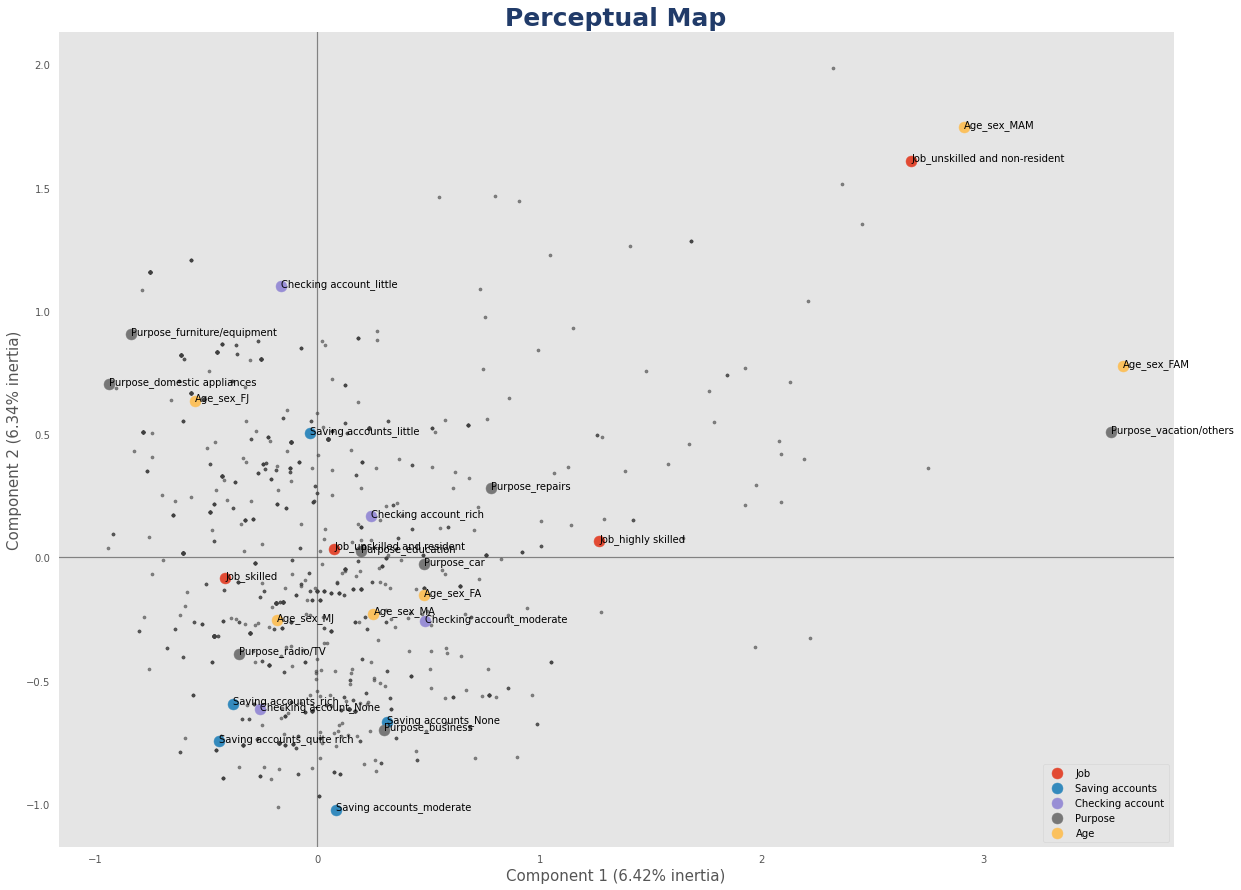

In [63]:
ax = data_ACM.plot_coordinates(X = df_mca,
                               ax = None,
                               figsize = (20, 15),
                               show_row_points = True,
                               show_row_labels = False,
                               show_column_points = True,
                               column_points_size = 120,
                               show_column_labels = True,
                               legend_n_cols = df_mca.shape[1])

ei = data_ACM.explained_inertia_

ax.set_title("Perceptual Map", fontsize = 25, color = '#213B69', fontweight = 1000, loc = 'center')
ax.set_xlabel('Component {} ({:.2f}% inertia)'.format(1, 100 * ei[0]), fontsize = 15)
ax.set_ylabel('Component {} ({:.2f}% inertia)'.format(2, 100 * ei[1]), fontsize = 15)
plt.legend(loc = "lower right")
plt.show()

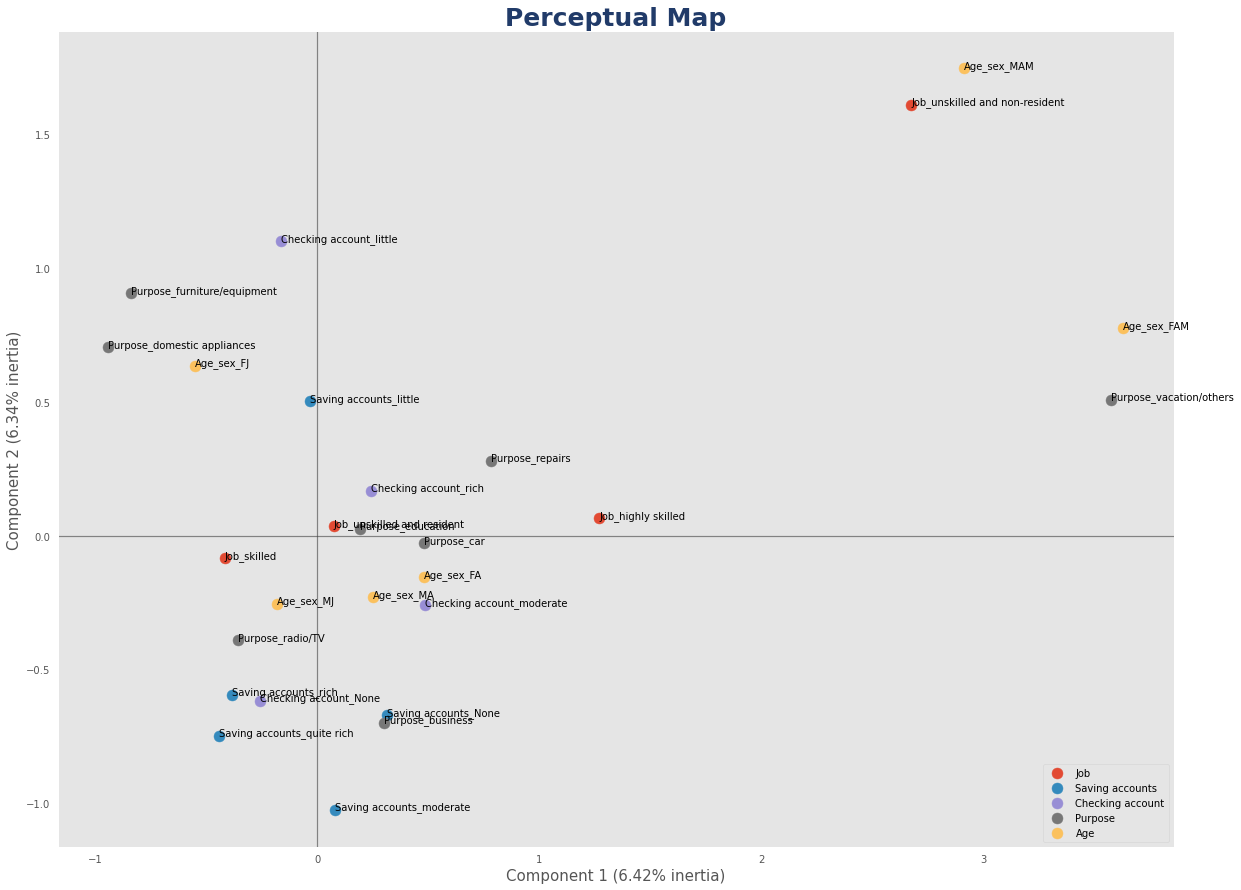

In [64]:
ax = data_ACM.plot_coordinates(X = df_mca,
                               ax = None,
                               figsize = (20, 15),
                               show_row_points = False,
                               show_row_labels = False,
                               show_column_points = True,
                               column_points_size = 120,
                               show_column_labels = True,
                               legend_n_cols = df_mca.shape[1])

ei = data_ACM.explained_inertia_

ax.set_title("Perceptual Map", fontsize = 25, color = '#213B69', fontweight = 1000, loc = 'center')
ax.set_xlabel('Component {} ({:.2f}% inertia)'.format(1, 100 * ei[0]), fontsize = 15)
ax.set_ylabel('Component {} ({:.2f}% inertia)'.format(2, 100 * ei[1]), fontsize = 15)
plt.legend(loc = "lower right")
plt.show()

Antes de interpretar la gráfica hay que notar que el porcentaje de los primeros dos componentes es muy bajo, ambos suman apenas el 12.7% de la inercia (se puede entender como la varianza total explicada), lo que indica que no están capturando mucha información, por lo tanto, las conlusiones deben ser tomadas con reserva.

Lo que buscamos identificar en las gráficas anteriores son puntos cercanos y a la vez lejos del origen, lo que indicaría una fuerte relación de dependencia entre las mismas. 

Podemos identificar que hay un primer grupo de relaciones entre las mujeres adultas mayores (FAM) y el propósito vacaciones. Otro grupo claramente identificado son las mujeres jóvenes (FJ) con los accesorios domésticos. Estos dos grupos presentan una fuerte asociación, ya que están muy alejados del origen.

Hay un grupo conformado por hombres jóvenes (MJ) y el propósito de radio/TV y otro de mujeres adultas (FA) con los autos, los hombres adultos (MA) presentan la misma dependencia pero en menor grado.

Se lograron identificar estos grupos tomando en consideración que el porcentaje de inercia es muy bajo, sin embargo, es una pieza más de información que ya se tiene.

# Ingeniería de variables

Ahora, vamos a crear algunas variables para ver si podemos encontrar algunas que sean buenas segmentadoras o al menos nos sean de ayuda a la hora de ponerle "cara y ojos" a los segmentos cuando ya se hayan creado.

## Duration

Empecemos con la variable `Duration`. Vamos a discretizarla, en otras palabras, se va a crear una variable que contenga " 3 tramos" o rangos de meses que serán:

1. Corto_plazo (menos de 12 meses)
2. Mediano_plazo (entre 12 y 36 mesres)
3. Largo_plazo (más de 36 meses)

In [65]:
df.groupby('Duration').size()

Duration
4       6
5       1
6      75
7       5
8       7
9      49
10     28
11      9
12    179
13      4
14      4
15     64
16      2
18    113
20      8
21     30
22      2
24    184
26      1
27     13
28      3
30     40
33      3
36     83
39      5
40      1
42     11
45      5
47      1
48     48
54      2
60     13
72      1
dtype: int64

In [66]:
condiciones = [(df['Duration'] < 12),
               ((df['Duration'] >= 12) & (df['Duration'] <= 36)),
               (df['Duration'] > 36)]

resultados = ['Corto_plazo', 'Mediano_plazo', 'Largo_plazo']

df['Duration_disc'] = np.select(condiciones, resultados, default = -999)

In [67]:
df.Duration_disc.value_counts()

Mediano_plazo    733
Corto_plazo      180
Largo_plazo       87
Name: Duration_disc, dtype: int64

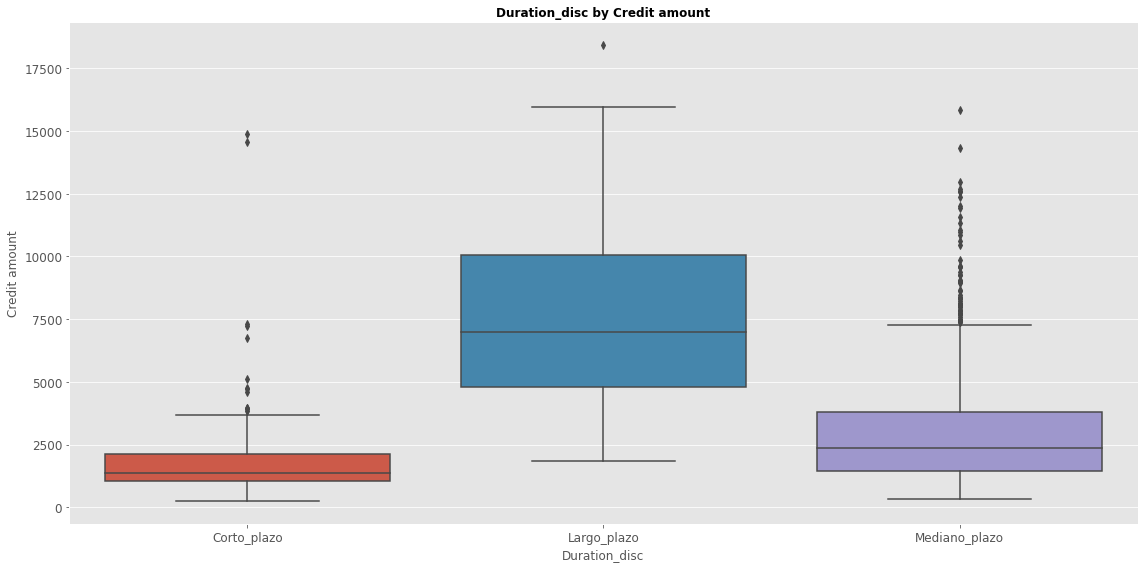

In [68]:
plot2(df = df, x_cat = 'Duration_disc', y_cont = 'Credit amount')

Vemos que esta nueva variable al parecer segmenta bien los datos cuando se compara con la variable `Credit amount`, pues se aprecia un grupo de clientes que el 50% de ellos no rebasa las 2,500 unidades monetarias, otro grupo supera los 5,000. Los tres nuevos segmentos de la variable `Duration` tienen medianas muy diferentes.

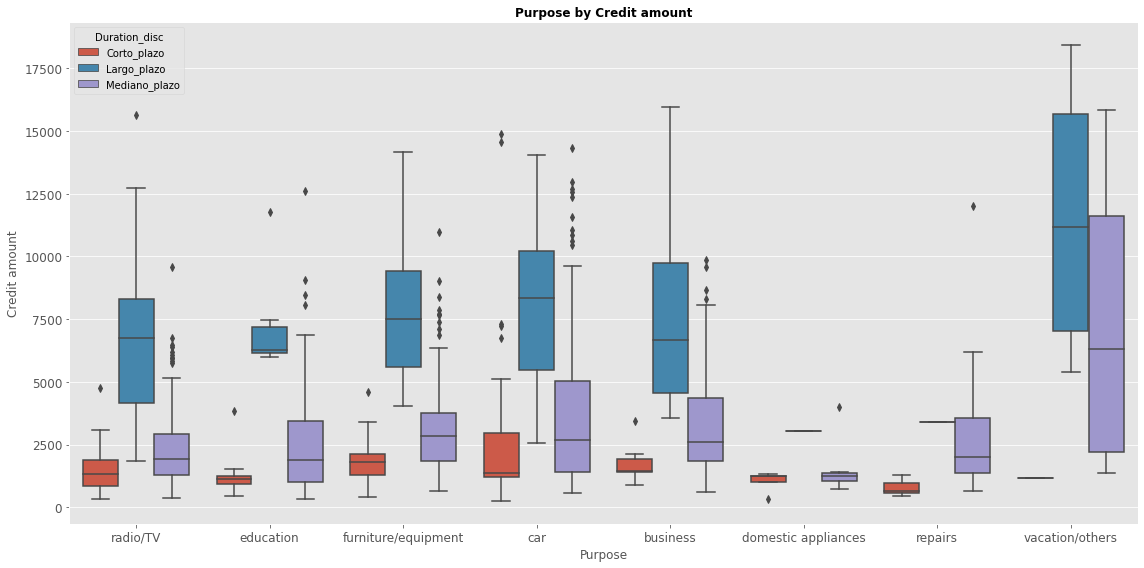

In [69]:
plot2(df = df, x_cat = 'Purpose', y_cont = 'Credit amount', by = 'Duration_disc')

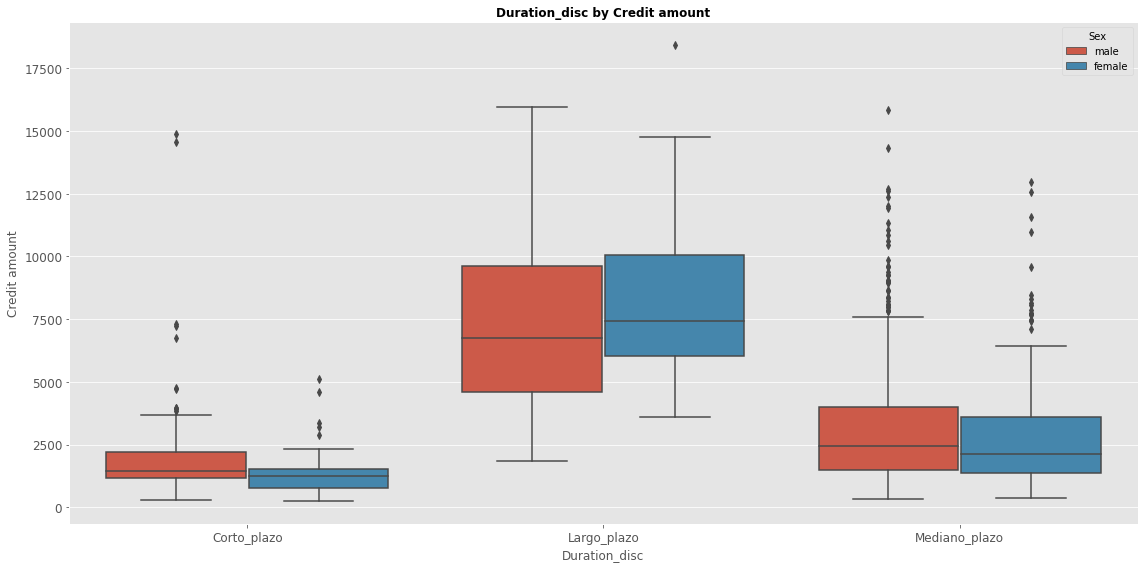

In [70]:
plot2(df = df, x_cat = 'Duration_disc', y_cont = 'Credit amount', by = 'Sex')

## Age

La variable `Age` también se va a discretizar, para formar 3 rangos:

1. Joven (menor a 36 años)
2. Adulto (entre 36 y 64 años)
3. Adulto_mayor (mayor a 64 años)

In [71]:
df.groupby('Age').size()

Age
19     2
20    14
21    14
22    27
23    48
24    44
25    41
26    50
27    51
28    43
29    37
30    40
31    38
32    34
33    33
34    32
35    40
36    39
37    29
38    24
39    21
40    25
41    17
42    22
43    17
44    17
45    15
46    18
47    17
48    12
49    14
50    12
51     8
52     9
53     7
54    10
55     8
56     3
57     9
58     5
59     3
60     6
61     7
62     2
63     8
64     5
65     5
66     5
67     3
68     3
70     1
74     4
75     2
dtype: int64

In [72]:
condiciones = [(df['Age'] <= 35),
               ((df['Age'] > 35) & (df['Age'] <= 64)),
               (df['Age'] > 64)]

resultados = ['Joven', 'Adulto', 'Adulto_mayor']

df['Age_disc'] = np.select(condiciones, resultados, default = -999)

In [73]:
df.Age_disc.value_counts()

Joven           588
Adulto          389
Adulto_mayor     23
Name: Age_disc, dtype: int64

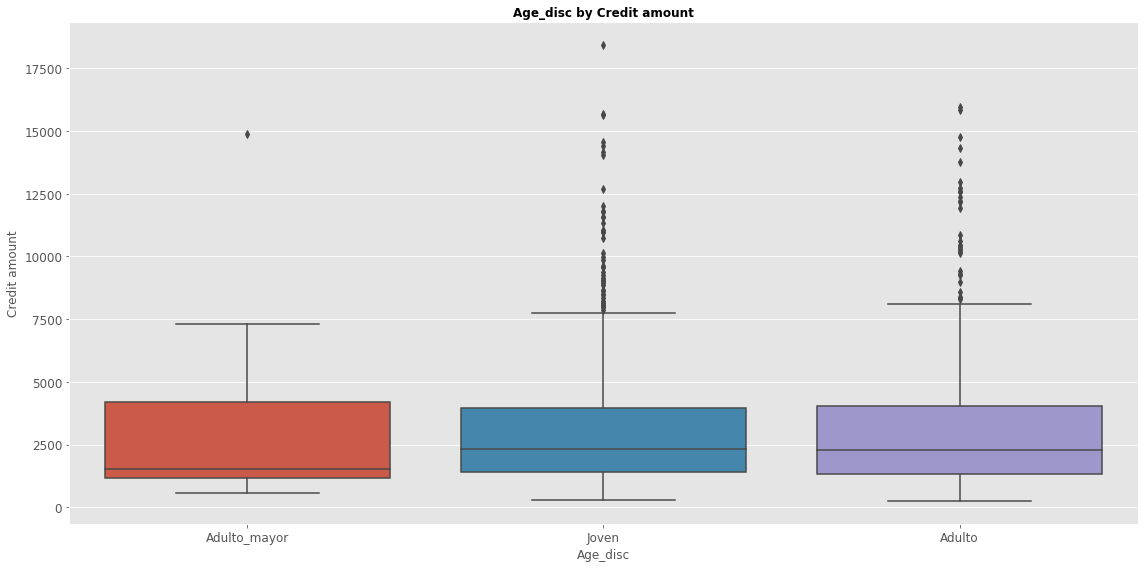

In [74]:
plot2(df = df, x_cat = 'Age_disc', y_cont = 'Credit amount')

Al parecer esta nueva variable categórica no es buena segmentadora, pues en la gráfica anterior se aprecia claramente que los nuevos grupos de edades creados se solapan. Lo anterior, se debe probablemente a que agrupar en solo 3 tramos las edades estamos perdiendo información.

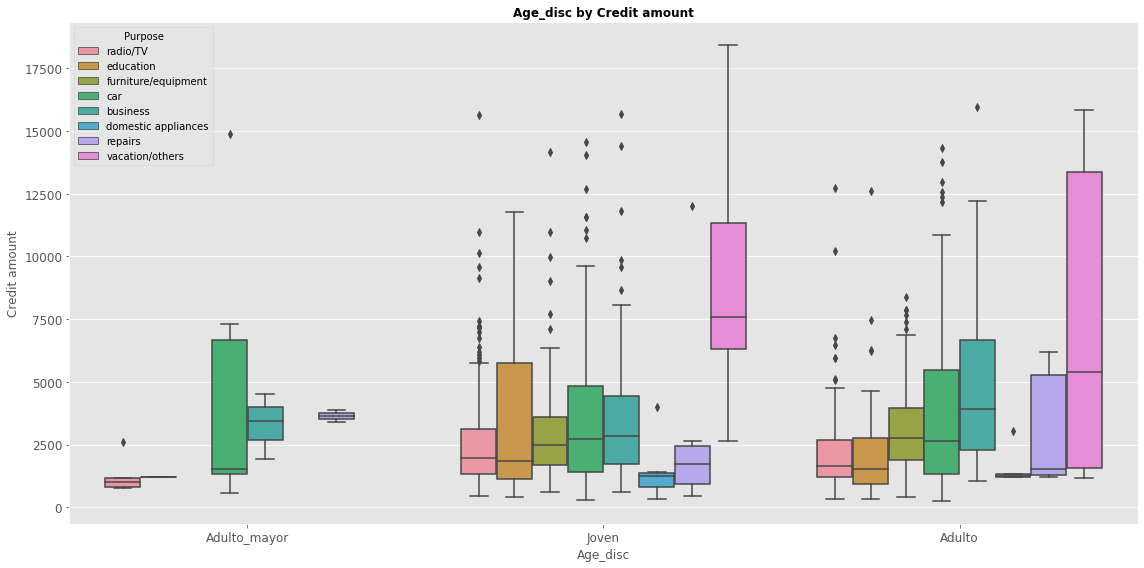

In [75]:
plot2(df = df, x_cat = 'Age_disc', y_cont = 'Credit amount', by = 'Purpose')

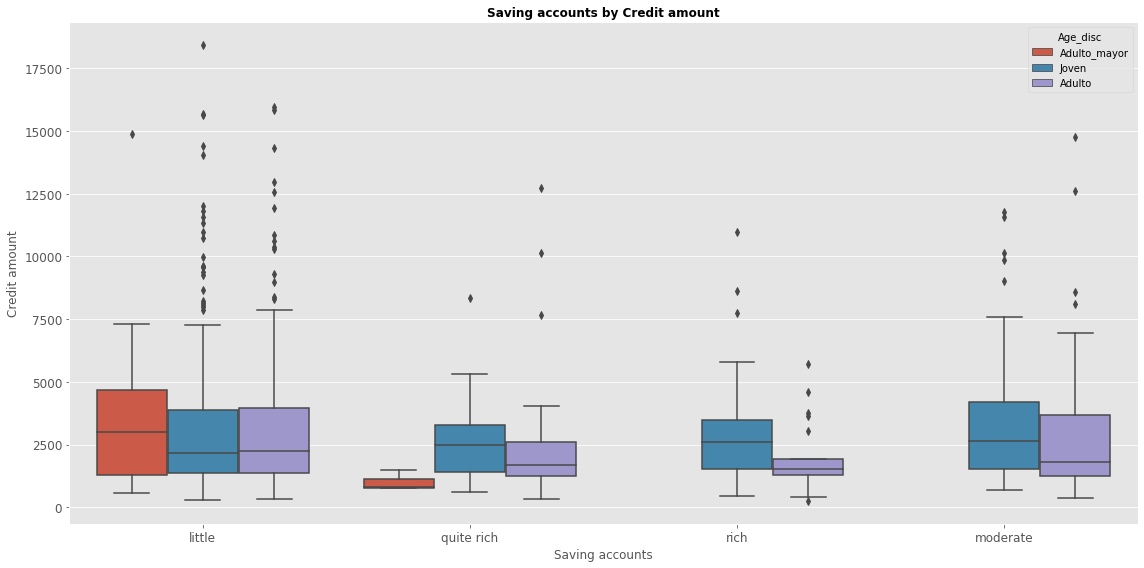

In [76]:
plot2(df = df, x_cat = 'Saving accounts', y_cont = 'Credit amount', by = 'Age_disc')

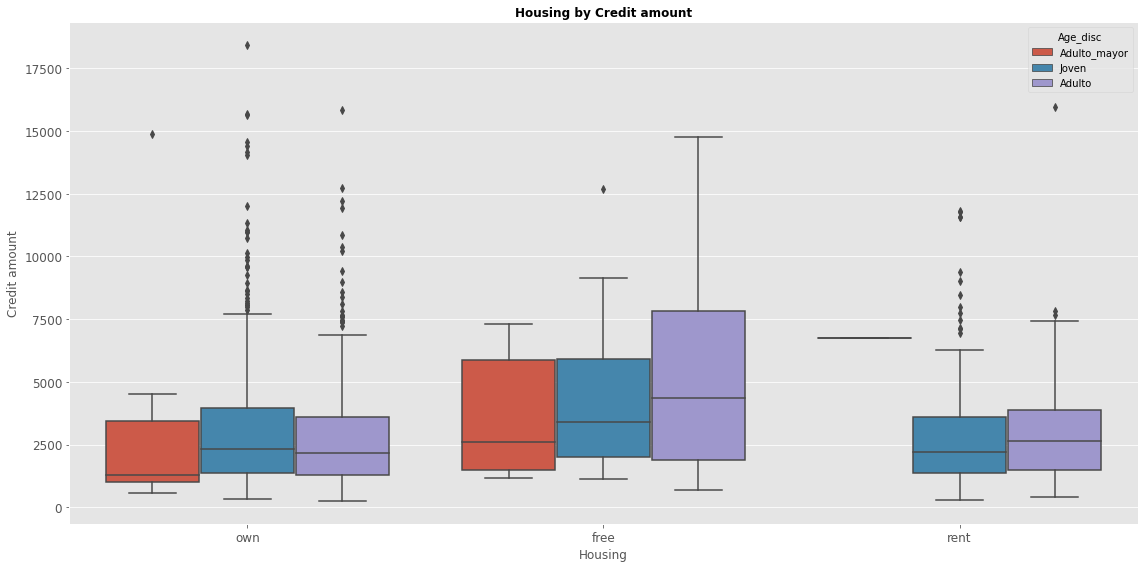

In [77]:
plot2(df = df, x_cat = 'Housing', y_cont = 'Credit amount', by = 'Age_disc')

## Monthly

Ahora se creará la variable `Monthly`, que será el resultado de dividir `Credit amount` entre `Duration` (monto del crédito entre el plazo o duración del mismo).

In [78]:
df['Monthly'] = df['Credit amount'] / df['Duration']
df['Monthly'].describe()

count    1000.000000
mean      167.687020
std       153.490959
min        24.055556
25%        89.600000
50%       130.333333
75%       206.183333
max      2482.666667
Name: Monthly, dtype: float64

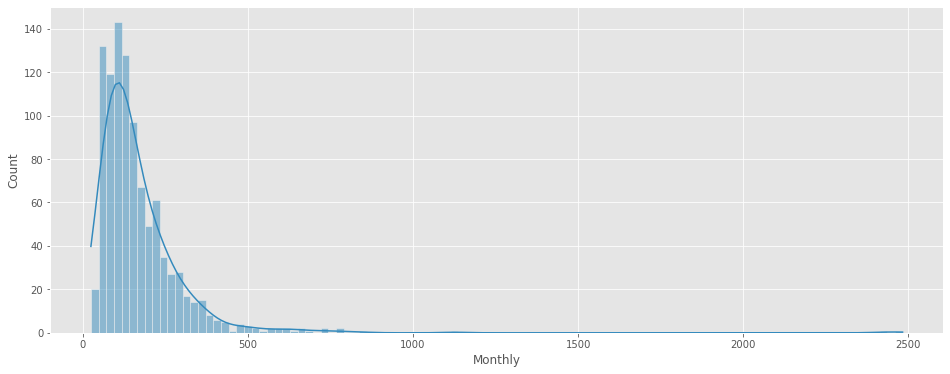

In [79]:
plt.subplots(figsize = (16, 6))

sns.histplot(data = df, x = 'Monthly', kde = True);

Se puede apreciar que la nueva variable tiene muchos valores extremos. Acotemos dicha variable a menos de 1,000 para ver más claramente su distribución con otras variables.

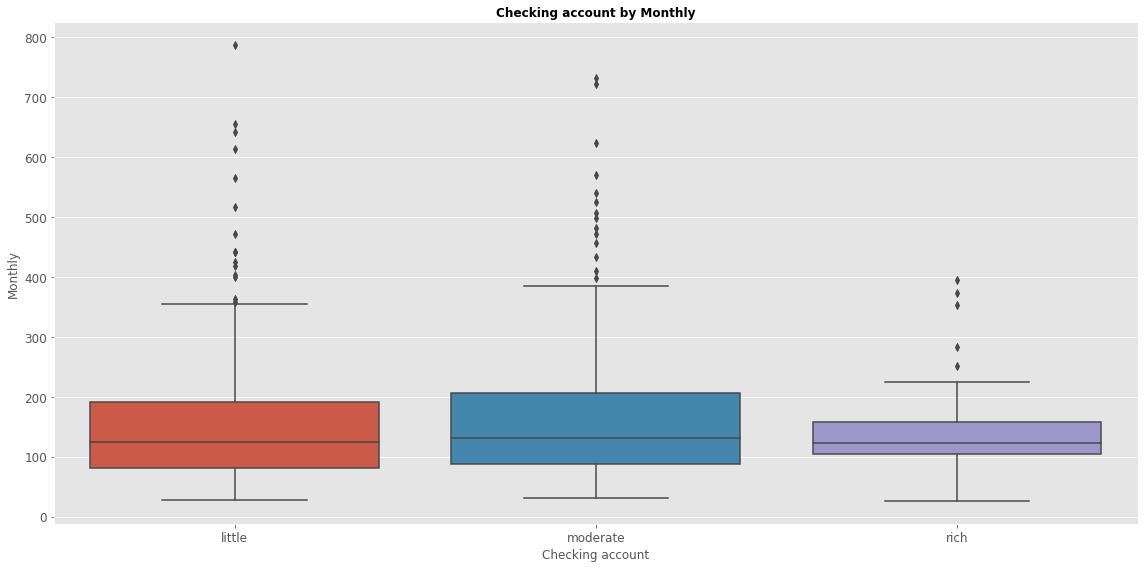

In [80]:
plot2(df = df[df['Monthly'] < 1000], x_cat = 'Checking account', y_cont = 'Monthly')

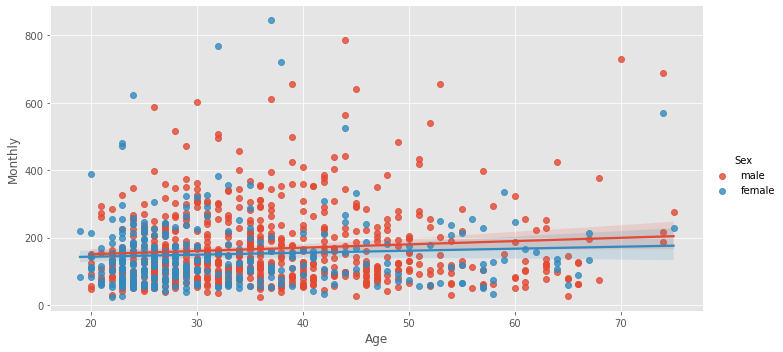

In [81]:
sns.lmplot(data = df[df['Monthly'] < 1000], x = 'Age', y = 'Monthly', hue = 'Sex', height = 5, aspect = 2);

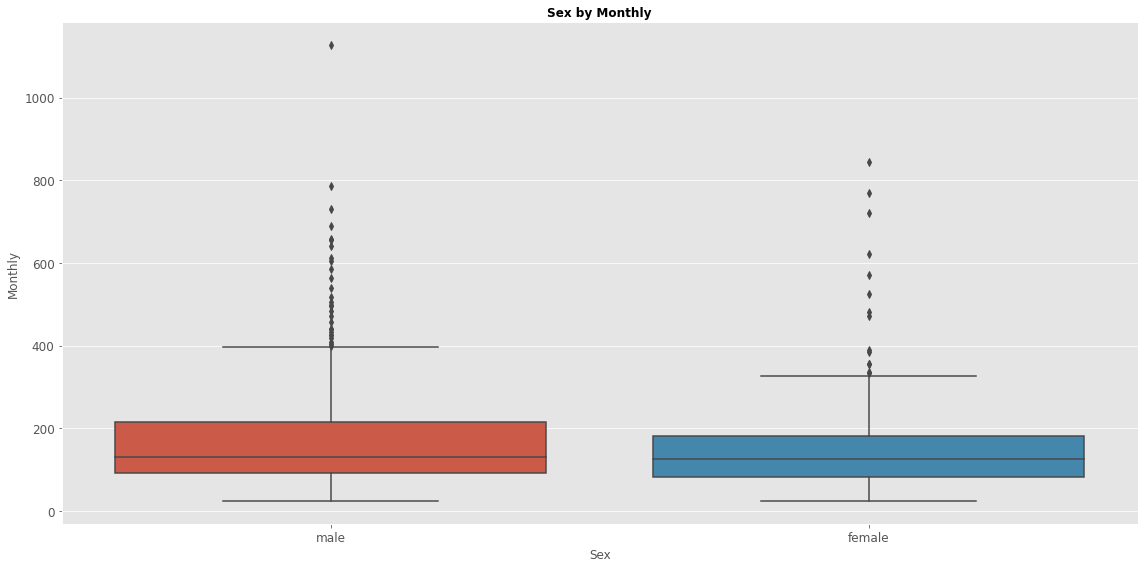

In [82]:
plot2(df = df[df['Monthly'] < 1500], x_cat = 'Sex', y_cont = 'Monthly')

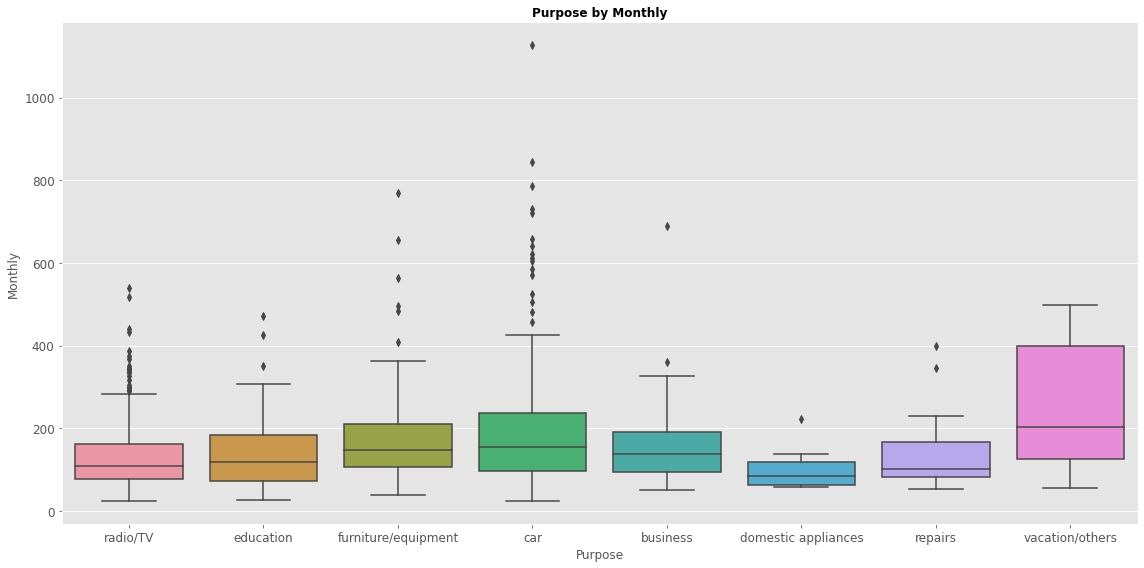

In [83]:
plot2(df = df[df['Monthly'] < 1500], x_cat = 'Purpose', y_cont = 'Monthly')

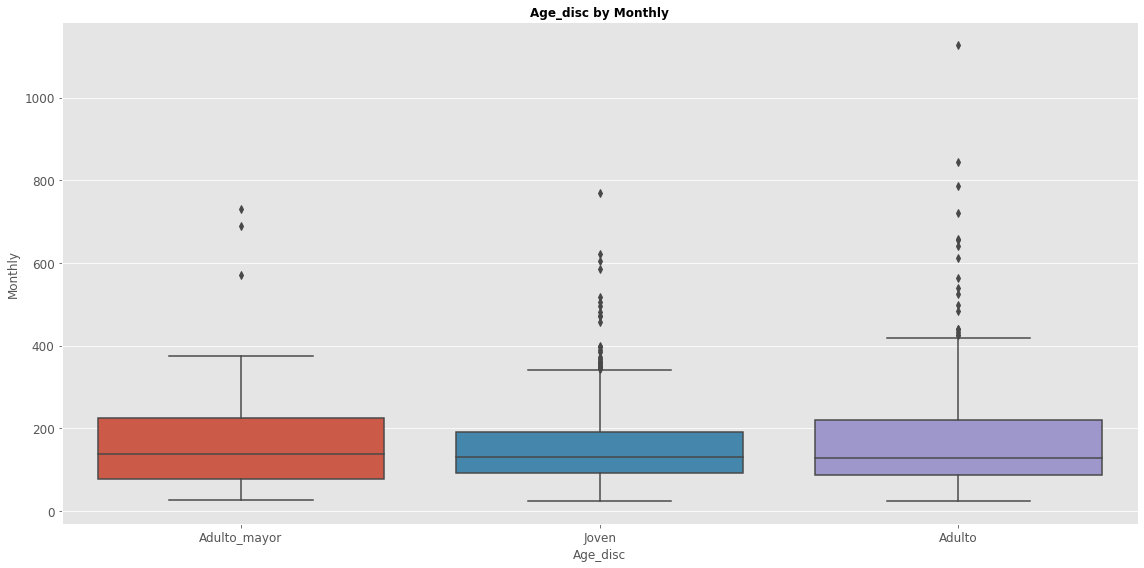

In [84]:
plot2(df = df[df['Monthly'] < 1500], x_cat = 'Age_disc', y_cont = 'Monthly')

Al parecer esta nueva variable no es buena segmentadora. Ahora, se discretizará ésta variable para ver si se logra conseguir una distinción clara entre los clientes. Quedrá como sigue:

1. Menos_200
2. Entre_200_399
3. Entre_400-999
3. Mas_1000

In [85]:
condiciones = [(df['Monthly'] < 200),
               ((df['Monthly'] >= 200) & (df['Monthly'] < 400)),
               ((df['Monthly'] >= 400) & (df['Monthly'] < 1000)),
               (df['Monthly'] >= 1000)]

resultados = ['Menos_200', 'Entre_200_399', 'Entre_400-999', 'Mas_1000']

df['Monthly_disc'] = np.select(condiciones, resultados, default = -999)

In [86]:
df.Monthly_disc.value_counts()

Menos_200        737
Entre_200_399    226
Entre_400-999     34
Mas_1000           3
Name: Monthly_disc, dtype: int64

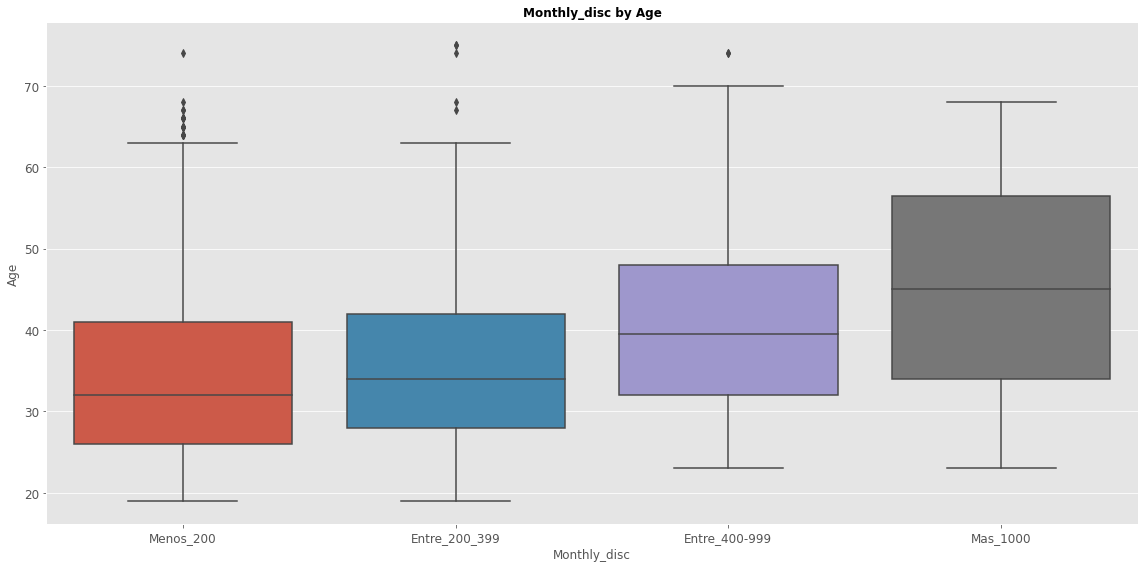

In [87]:
plot2(df = df, x_cat = 'Monthly_disc', y_cont = 'Age')

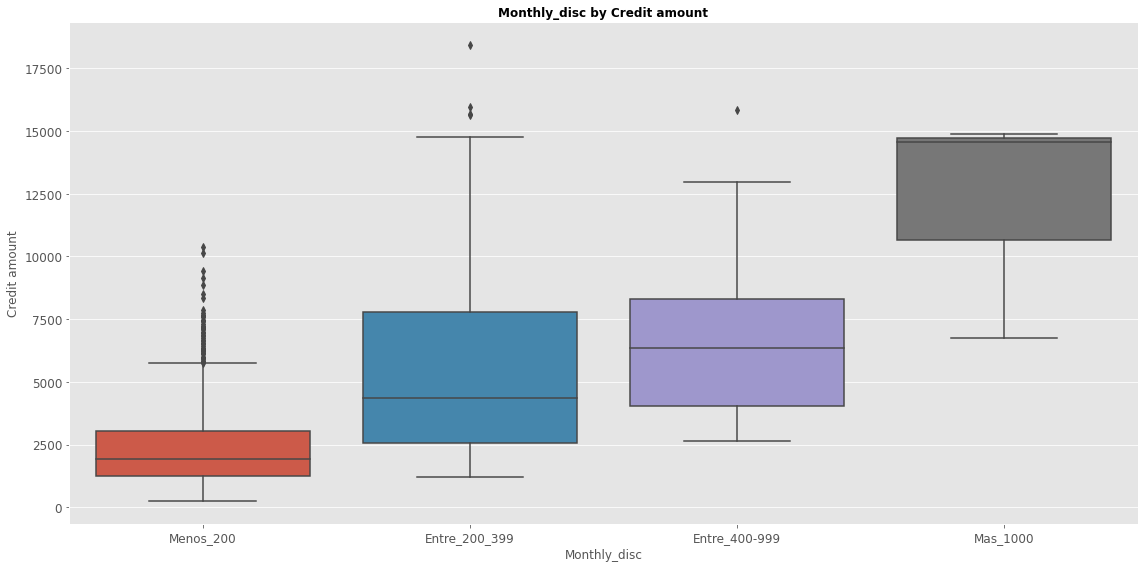

In [88]:
plot2(df = df, x_cat = 'Monthly_disc', y_cont = 'Credit amount')

La variable `Monthly` discretizada parace que logra diferenciar segmentos de clientes en base al monto de la mensualidad.  Una mensualidad aproximada.

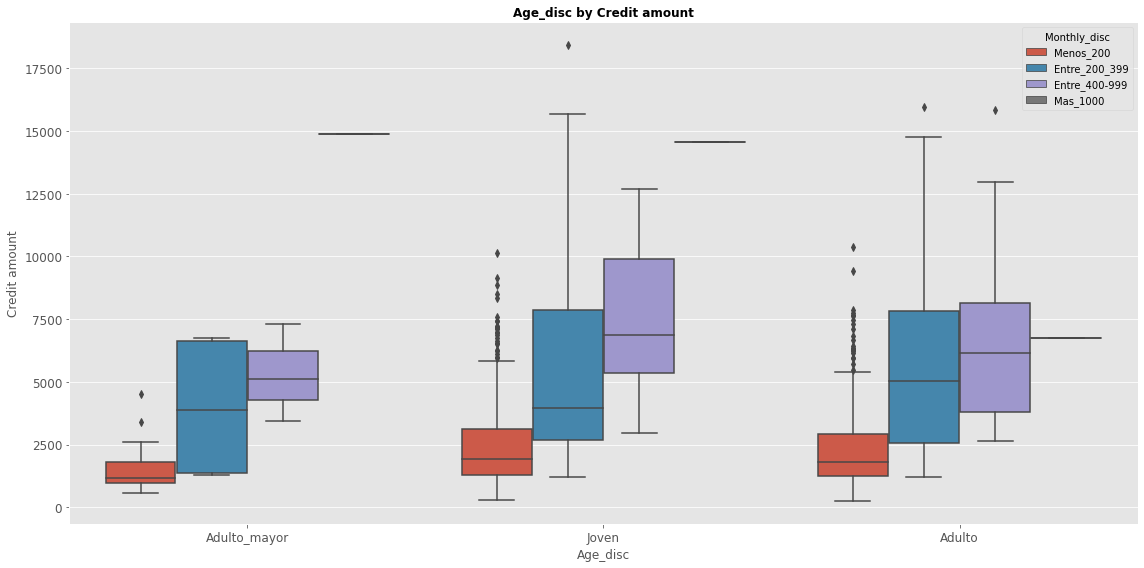

In [89]:
plot2(df = df, x_cat = 'Age_disc', y_cont = 'Credit amount', by = 'Monthly_disc')

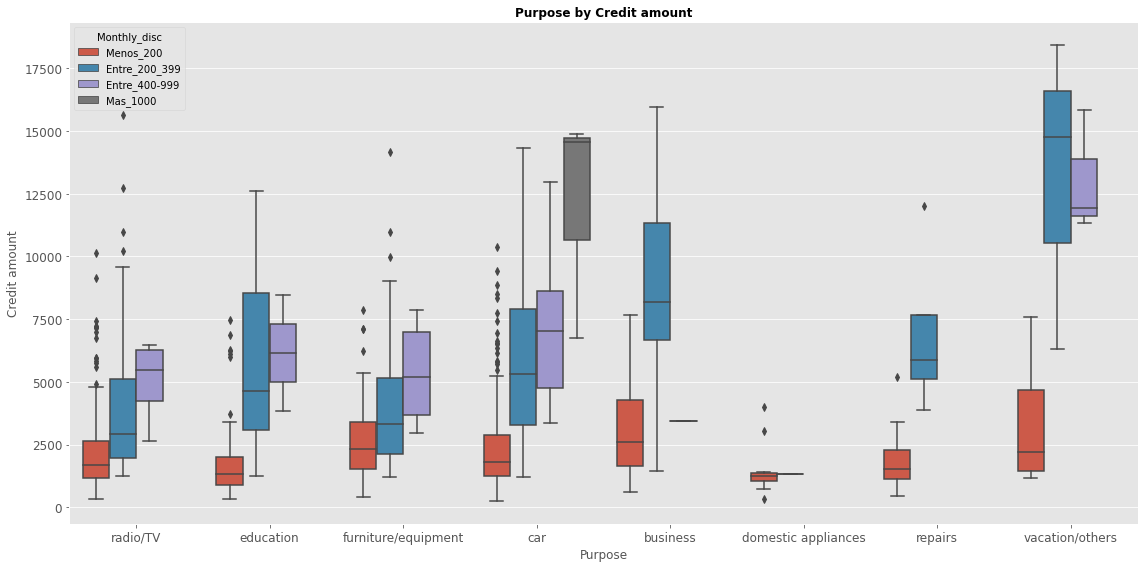

In [90]:
plot2(df = df, x_cat = 'Purpose', y_cont = 'Credit amount', by = 'Monthly_disc')

De todas las variables creadas solo se usarán `Duration_disc` y `Monthly_disc` para la segmentación. La variable `Age_disc` se usará para caracterizar los grupos cuando esten creados.

# Valores faltantes

En esta parte se tratan las variables que presentan valores faltantes. Al inicio del trabajo vimos cuales son.

In [91]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Duration_disc         0
Age_disc              0
Monthly               0
Monthly_disc          0
dtype: int64

Hay valores faltantes en solo dos variables: `Saving accounts` y `Checking account`. Veamos cuántos registros se verán afectados si eliminamos esas observaciones.

In [92]:
df[(df['Saving accounts'].isna()) | (df['Checking account'].isna())]

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0     67    male    2     own             NaN           little           1169   
2     49    male    1     own          little              NaN           2096   
5     35    male    1    free             NaN              NaN           9055   
..   ...     ...  ...     ...             ...              ...            ...   
994   50    male    2     own             NaN              NaN           2390   
995   31  female    1     own          little              NaN           1736   
997   38    male    2     own          little              NaN            804   

     Duration              Purpose  Duration_disc      Age_disc     Monthly  \
0           6             radio/TV    Corto_plazo  Adulto_mayor  194.833333   
2          12            education  Mediano_plazo        Adulto  174.666667   
5          36            education  Mediano_plazo         Joven  251.527778   
..        ...                  ...            ...           ...         ...   
994        12                  car  Mediano_plazo        Adulto  199.166667   
995        12  furniture/equipment  Mediano_plazo         Joven  144.666667   
997        12             radio/TV  Mediano_plazo        Adulto   67.000000   

      Monthly_disc  
0        Menos_200  
2        Menos_200  
5    Entre_200_399  
..             ...  
994      Menos_200  
995      Menos_200  
997      Menos_200  

[478 rows x 13 columns]

Serían 478 observaciones que equivalen a casi el 48%, por lo que, lo mejor será dejarlas y asignarles una etiqueta, ya que este proyecto no es de predicción. Además, no hay dato porque son clientes que muy probablemente no tienen cuentas por esos conceptos.

In [93]:
df['Checking account'].value_counts(dropna = False)

NaN         394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

In [94]:
df['Checking account'] = df['Checking account'].fillna('None')
df['Checking account'].value_counts(dropna = False)

None        394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

In [95]:
df['Saving accounts'].value_counts(dropna = False)

little        603
NaN           183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [96]:
df['Saving accounts'] = df['Saving accounts'].fillna('None')
df['Saving accounts'].value_counts(dropna = False)

little        603
None          183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

# Valores atípicos

<div class=text-justify>
En las variables numéricas existen valores atípicos que se deben tratar, porque el algoritmo a usar para formar los clusteres es <b>k-means</b> que trabaja calculando distancias. Ahora, como no se deben de eliminar dichos valores porque son clientes que deben de pertenecer, a final de cuentas, a algún clúster, la estratégia será la llamada <b>Capping</b>, o sea, sustituir o truncar valores atípicos por un valor arbitrario que no altere mucho la distribución original y de esta manera esos clientes con valores extremos seguirán existiendo al extremo de su respectiva variable.
</div>

Por lo anterior, las variables `Age` y `Credit amount` se truncarán.

In [97]:
df.groupby('Age').size().tail(10)

Age
62    2
63    8
64    5
65    5
66    5
67    3
68    3
70    1
74    4
75    2
dtype: int64

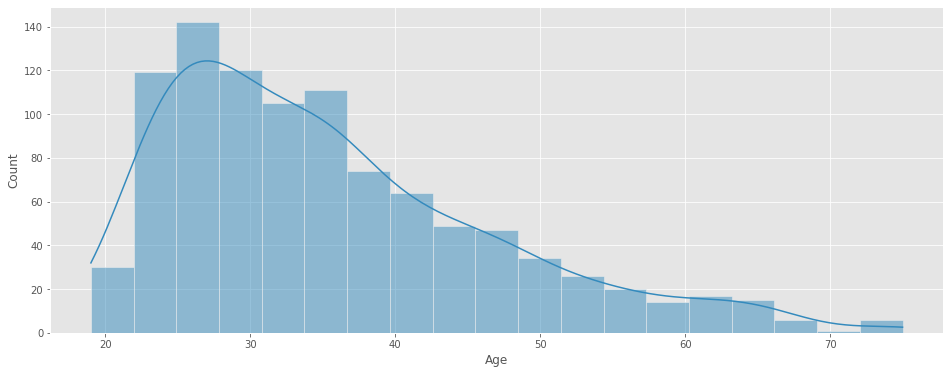

In [98]:
plt.subplots(figsize = (16, 6))

sns.histplot(data = df, x = 'Age', kde = True);

Con apoyo de la gráfica anterior, podemos apoyarnos para decidir truncar la edad en los 70 años.

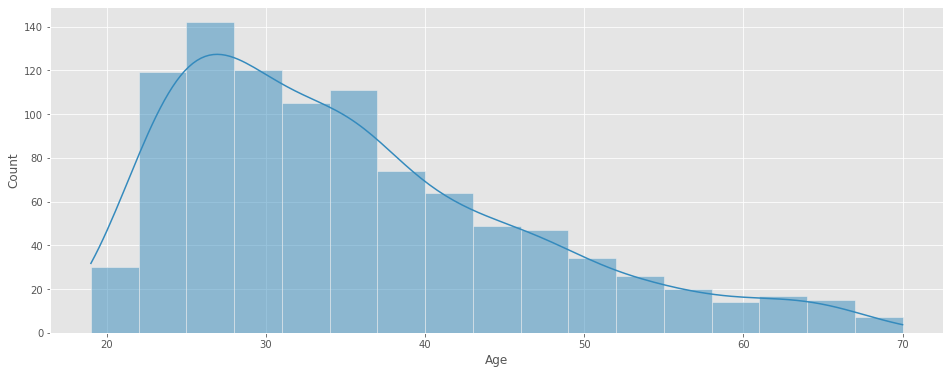

In [99]:
plt.subplots(figsize = (16, 6))

sns.histplot(data = df[df.Age < 71], x = 'Age', kde = True);

Parece que es un buen nivel para truncar. Ahora, veamos en dónde puede ser el corte a truncar para la variable Credit amount

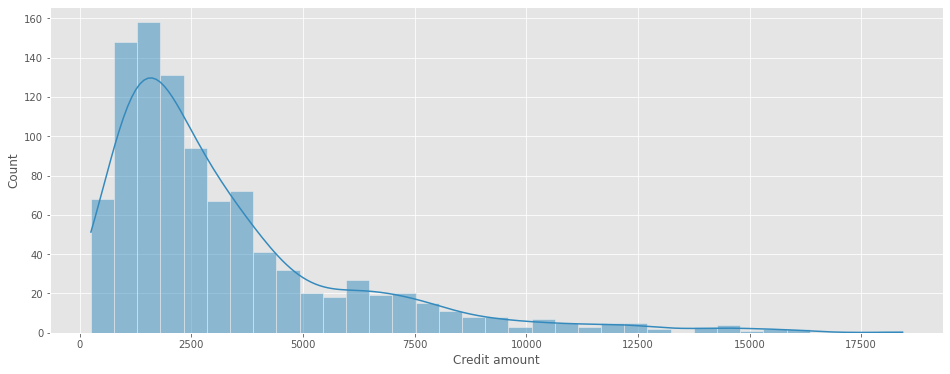

In [100]:
plt.subplots(figsize = (16, 6))

sns.histplot(data = df, x = 'Credit amount', kde = True);

In [101]:
df.groupby('Credit amount').size().tail(20)

Credit amount
12204    1
12389    1
12579    1
12612    1
12680    1
12749    1
12976    1
13756    1
14027    1
14179    1
14318    1
14421    1
14555    1
14782    1
14896    1
15653    1
15672    1
15857    1
15945    1
18424    1
dtype: int64

Con apoyo de la gráfica y de la tabla anteriores, el truncamiento se hará en los 13,000.

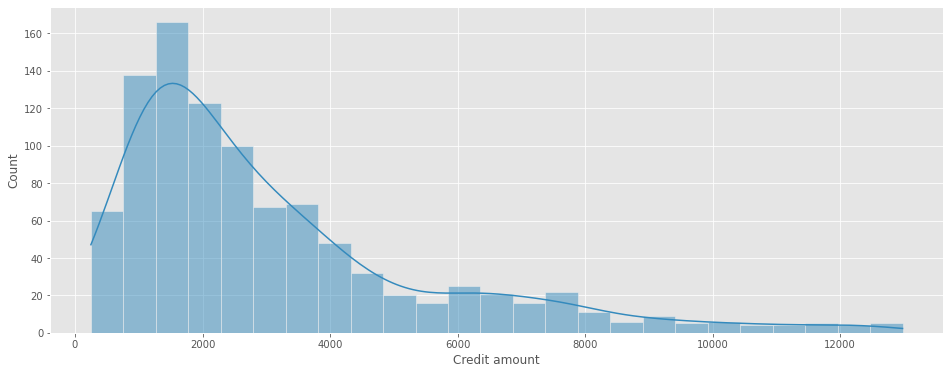

In [102]:
plt.subplots(figsize = (16, 6))

sns.histplot(data = df[df['Credit amount'] <= 13000], x = 'Credit amount', kde = True);

Se aplican los truncamientos.

In [103]:
from feature_engine import outliers as outr

In [104]:
capper = outr.ArbitraryOutlierCapper(
    max_capping_dict = {'Age':70,
                        'Credit amount':13000,
                        },
    min_capping_dict = None,
    missing_values = 'ignore')

capper.fit(df)

ArbitraryOutlierCapper(max_capping_dict={'Age': 70, 'Credit amount': 13000},
                       missing_values='ignore')

In [105]:
df_prep = capper.transform(df)

Comprobamos ambas variables.

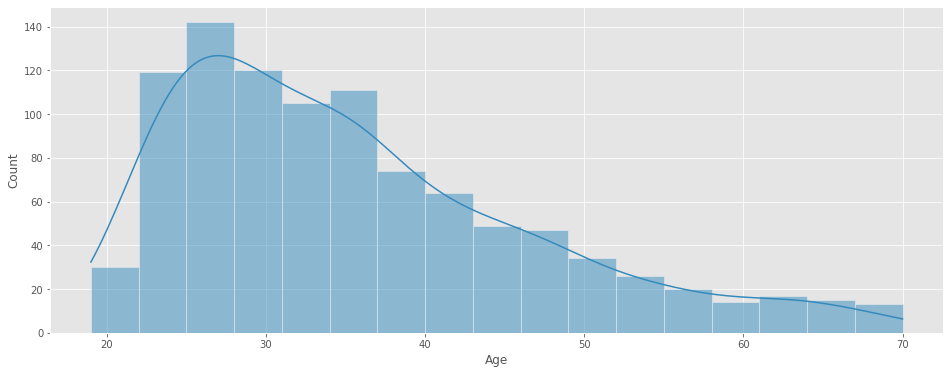

In [106]:
plt.subplots(figsize = (16, 6))

sns.histplot(data = df_prep, x = 'Age', kde = True);

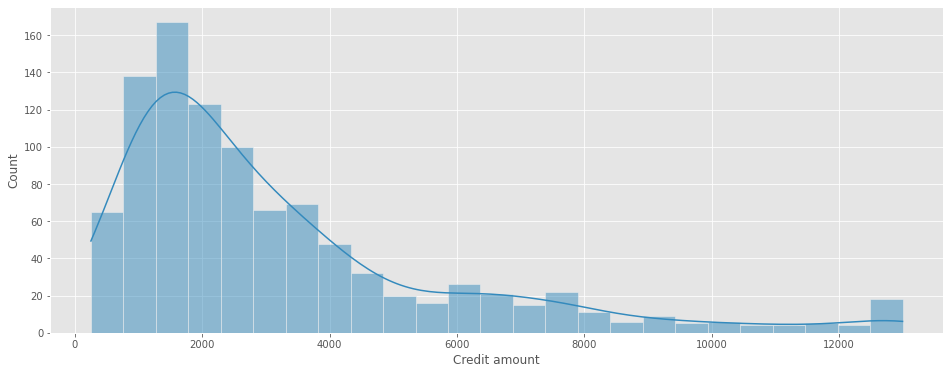

In [107]:
plt.subplots(figsize = (16, 6))

sns.histplot(data = df_prep, x = 'Credit amount', kde = True);

# Transformaciones

Ya que está corregido el tema de los valores atípicos es momento de transformar las variables para tratar de ajustarlas a una distribución normal. Se usará el método `QuantileTransformer`, ya que su estratégia es de ingeniería inversa, o sea, se crea una distribución normal y a la variable original se le aplican diversas transformaciones hasta que encuentra una que ajusta mejor a esa normal.

## Normalización gaussiana

In [108]:
from sklearn.preprocessing import QuantileTransformer

In [109]:
quan = QuantileTransformer(output_distribution = 'normal')
quan.fit(df_prep[['Age']])

df_prep['Age'] = quan.transform(df_prep[['Age']])

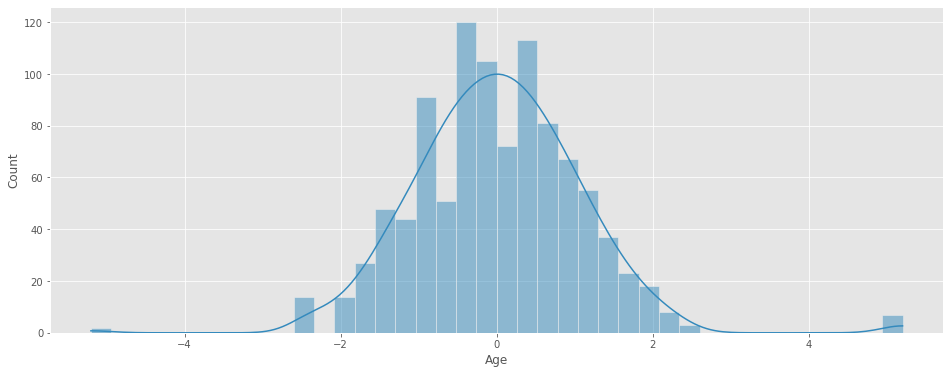

In [110]:
plt.subplots(figsize = (16, 6))

sns.histplot(data = df_prep, x = 'Age', kde = True);

In [111]:
quan.fit(df_prep[['Credit amount']])

df_prep['Credit amount'] = quan.transform(df_prep[['Credit amount']])

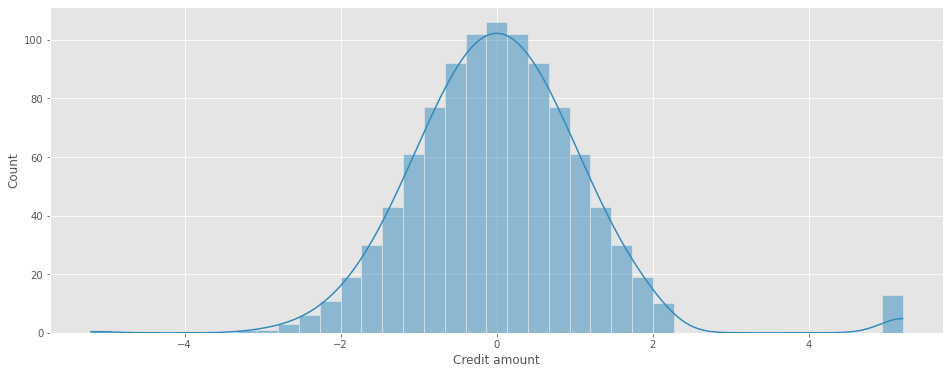

In [112]:
plt.subplots(figsize = (16, 6))

sns.histplot(data = df_prep, x = 'Credit amount', kde = True);

## Ordinal encoding

De las variables categóricas solo vamos a usar `Housing`, `Checking accounut` , `Duration_disc` y `Monthly_disc`. Sólo las dos últimas tiene sentido tratarlas como ordinales, ya que la primera no lleva un orden.

In [113]:
for col in df_prep[['Housing','Checking account','Monthly_disc','Duration_disc']].columns:
    print(col, df_prep[col].unique())

Housing ['own' 'free' 'rent']
Checking account ['little' 'moderate' 'None' 'rich']
Monthly_disc ['Menos_200' 'Entre_200_399' 'Entre_400-999' 'Mas_1000']
Duration_disc ['Corto_plazo' 'Largo_plazo' 'Mediano_plazo']


Se define el orden que tendrán las categorias de las variables a codificar

In [114]:
Categorias_Checkin_account = ['None', 'little', 'moderate', 'rich']
Categorias_Monthly_disc = ['Menos_200', 'Entre_200_399', 'Entre_400-999', 'Mas_1000']
Categorias_Duration_disc = ['Corto_plazo', 'Mediano_plazo', 'Largo_plazo']

In [115]:
from sklearn.preprocessing import OrdinalEncoder

In [116]:
oe = OrdinalEncoder(categories = [Categorias_Checkin_account, Categorias_Monthly_disc, Categorias_Duration_disc],
                   handle_unknown = 'use_encoded_value',
                   unknown_value = 4)
oe.fit(df_prep[['Checking account','Monthly_disc','Duration_disc']])

OrdinalEncoder(categories=[['None', 'little', 'moderate', 'rich'],
                           ['Menos_200', 'Entre_200_399', 'Entre_400-999',
                            'Mas_1000'],
                           ['Corto_plazo', 'Mediano_plazo', 'Largo_plazo']],
               handle_unknown='use_encoded_value', unknown_value=4)

In [117]:
df_prep_oe = oe.transform(df_prep[['Checking account','Monthly_disc','Duration_disc']])

In [118]:
df_prep_oe = pd.DataFrame(df_prep_oe, columns = ['Checking account','Monthly_disc','Duration_disc'])

In [119]:
df_prep_oe

Checking account  Monthly_disc  Duration_disc
0                 1.0           0.0            0.0
1                 2.0           0.0            2.0
2                 0.0           0.0            1.0
..                ...           ...            ...
997               0.0           0.0            1.0
998               1.0           0.0            2.0
999               2.0           0.0            2.0

[1000 rows x 3 columns]

## One-Hot-Encoding

Como la variable `Housing` a pesar de que es categórica no lleva un orden, pues no existe un criterio para elegir una categoría sobre otra, por lo que, se decide dummificarla y, para evitar problemas de multicolinealidad se quitará una categoría.

In [120]:
df_prep_ohe = pd.get_dummies(df_prep[['Housing']], drop_first = True)
df_prep_ohe

Housing_own  Housing_rent
0              1             0
1              1             0
2              1             0
..           ...           ...
997            1             0
998            0             0
999            1             0

[1000 rows x 2 columns]

## Reescalado

<div class=text-justify>
Finalmente, se hará el reescalado de las variables, porque que se tienen diferentes escalas y eso afecta el desempeño del agoritmo k-means. Como en las variables `Age` y `Credit amount` hay valores atípicos a pesar de que se aplico la técnica de quantile transform, se usará un reescalado robusto que usa en sus cálculos la mediana y el rango intercuantílico y le indicaremos los percentiles 25 y  75. Lo anterior, porque en las variables en mención los valores atípicos se acumularon en las colas de sus respectivas distribuciones.
</div>

Se separa la data a reescalar, excluyendo las variables [0,1], las dummies.

In [121]:
df_rs = pd.concat(objs = [df_prep[['Age','Credit amount']], df_prep_oe], axis = 1)

df_rs

Age  Credit amount  Checking account  Monthly_disc  Duration_disc
0    2.289988      -1.016672               1.0           0.0            0.0
1   -1.716415       1.023003               2.0           0.0            2.0
2    1.116369      -0.129582               0.0           0.0            1.0
..        ...            ...               ...           ...            ...
997  0.436240      -1.431971               0.0           0.0            1.0
998 -1.401177      -0.295296               1.0           0.0            2.0
999 -0.627196       0.798769               2.0           0.0            2.0

[1000 rows x 5 columns]

In [122]:
df_rs.skew()

Age                 0.463515
Credit amount       0.935222
Checking account    0.430530
Monthly_disc        1.737239
Duration_disc      -0.153417
dtype: float64

In [123]:
df_rs.describe().T

count      mean       std       min       25%  \
Age               1000.0  0.014106  1.080857 -5.199338 -0.627196   
Credit amount     1000.0  0.031829  1.134122 -5.199338 -0.674885   
Checking account  1000.0  1.001000  0.957034  0.000000  0.000000   
Monthly_disc      1000.0  0.303000  0.545425  0.000000  0.000000   
Duration_disc     1000.0  0.907000  0.508537  0.000000  1.000000   

                           50%       75%       max  
Age              -1.254569e-03  0.687939  5.199338  
Credit amount     6.960578e-17  0.674490  5.199338  
Checking account  1.000000e+00  2.000000  3.000000  
Monthly_disc      0.000000e+00  1.000000  3.000000  
Duration_disc     1.000000e+00  1.000000  2.000000

In [124]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler(quantile_range = (25.0, 75.0))

rs.fit(df_rs)
salida = rs.transform(df_rs)

df_rsd = pd.DataFrame(salida, columns = df_rs[['Age','Credit amount','Checking account','Monthly_disc','Duration_disc']].columns)
df_rsd

Age  Credit amount  Checking account  Monthly_disc  Duration_disc
0    1.742211      -0.753439               0.0           0.0           -1.0
1   -1.304171       0.758131               0.5           0.0            1.0
2    0.849817      -0.096031              -0.5           0.0            0.0
..        ...            ...               ...           ...            ...
997  0.332661      -1.061210              -0.5           0.0            0.0
998 -1.064471      -0.218839               0.0           0.0            1.0
999 -0.475953       0.591955               0.5           0.0            1.0

[1000 rows x 5 columns]

In [125]:
df_rsd.skew()

Age                 0.463515
Credit amount       0.935222
Checking account    0.430530
Monthly_disc        1.737239
Duration_disc      -0.153417
dtype: float64

In [126]:
df_rsd.describe().T

count      mean       std       min       25%  50%  \
Age               1000.0  0.011680  0.821860 -3.952509 -0.475953  0.0   
Credit amount     1000.0  0.023588  0.840479 -3.853144 -0.500146  0.0   
Checking account  1000.0  0.000500  0.478517 -0.500000 -0.500000  0.0   
Monthly_disc      1000.0  0.303000  0.545425  0.000000  0.000000  0.0   
Duration_disc     1000.0 -0.093000  0.508537 -1.000000  0.000000  0.0   

                       75%       max  
Age               0.524047  3.954417  
Credit amount     0.499854  3.853144  
Checking account  0.500000  1.000000  
Monthly_disc      1.000000  3.000000  
Duration_disc     0.000000  1.000000

Se juntan las variables que entrarán al algoritmo.

In [127]:
df_X = pd.concat(objs = [df_rsd, df_prep_ohe], axis = 1)
df_X

Age  Credit amount  Checking account  Monthly_disc  Duration_disc  \
0    1.742211      -0.753439               0.0           0.0           -1.0   
1   -1.304171       0.758131               0.5           0.0            1.0   
2    0.849817      -0.096031              -0.5           0.0            0.0   
..        ...            ...               ...           ...            ...   
997  0.332661      -1.061210              -0.5           0.0            0.0   
998 -1.064471      -0.218839               0.0           0.0            1.0   
999 -0.475953       0.591955               0.5           0.0            1.0   

     Housing_own  Housing_rent  
0              1             0  
1              1             0  
2              1             0  
..           ...           ...  
997            1             0  
998            0             0  
999            1             0  

[1000 rows x 7 columns]

# Modelo

<div class=text-justify>
Se usará el algoritmo de <b>KMeans</b> por ser sencillo de implementar, además, porque la base de datos no es muy grande. Pero antes de comenzar con el entrenamiento del modelo, es necesario asegurarnos de que no haya variables muy correlacionadas (multicolinealidad), ya que eso afecta este tipo de algoritmos. Por lo tanto, se aplicará el llamado <b>Análisis de Componentes Principales (PCA)</b>, que corrige este problema al crear componentes linealmente independientes y al mismo tiempo podremos reducir la cantidad de variables que entrarán al modelo.
</div>

## Análisis de Componentes Principales - PCA

In [128]:
from sklearn.decomposition import PCA

In [129]:
pca = PCA()
pca.fit(df_X)

PCA()

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.34282386 0.27496987 0.13236798 0.11238834 0.08974284 0.03221066
 0.01549646]


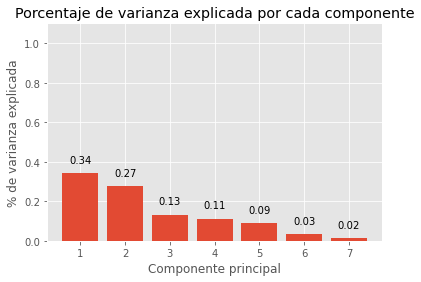

In [130]:
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
ax.bar(
    x = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df_X.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x, y),
        textcoords = "offset points",
        xytext = (0, 10),
        ha = 'center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('% de varianza explicada');

Vemos que el primer componente se explica el 34% de la varianza observada en los datos y la segunda el 27%. Las dos últimas componentes apenas llegan juntas al 5% de la varianza explicada.

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.34282386 0.61779372 0.7501617  0.86255004 0.95229288 0.98450354
 1.        ]


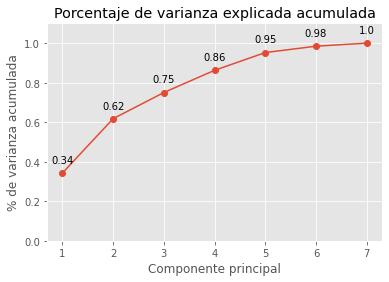

In [131]:
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
ax.plot(
    np.arange(len(df_X.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(df_X.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x, y),
        textcoords = "offset points",
        xytext = (0, 10),
        ha = 'center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('% de varianza acumulada');

Con los 4 primeros componentes se explica el 86% de la varianza total. Son los que se usarán.

In [132]:
pca = PCA(n_components = 4)
pca.fit(df_X)

scores_pca = pca.transform(df_X)

In [133]:
scores_pca

array([[-0.61695698,  1.98647949,  0.21447605,  0.03947242],
       [ 0.47416829, -1.53181443, -1.05619813,  0.15349833],
       [-0.00756265,  0.87984189, -0.39007211,  0.07136391],
       ...,
       [-0.96778028,  0.60104992, -0.27953307,  0.12594489],
       [-0.25916672, -1.18150497, -0.63271397, -0.59378988],
       [ 0.52019914, -0.71589134, -1.08446045, -0.04088872]])

Ya que se aplicó el PCA y se tiene el número de componentes que entrarán en el modelo, se procede a tratar de encontrar el número óptimo de grupos mediante las sigueintes 4 técnicas:

1. Elbow method.
2. Silhouette method.
3. Calinski-Harabasz Index.
4. Davies-Bouldin Index.

In [134]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples

In [135]:
soluciones = list(range(2, 7))

codo = []
silueta = []
calins = []
davies = []

for solucion in soluciones:
    
    cluster = KMeans(random_state = 44, n_clusters = solucion, init = 'k-means++')
    
    cluster.fit(scores_pca)
    
    codo.append(cluster.inertia_)
    silueta.append(silhouette_score(scores_pca, cluster.labels_))
    calins.append(calinski_harabasz_score(scores_pca, cluster.labels_))
    davies.append(davies_bouldin_score(scores_pca, cluster.labels_))

In [136]:
metricas = pd.DataFrame({'Solucion':soluciones,
                       'Codo':codo,
                       'Silueta':silueta,
                       'Calins':calins,
                       'Davies':davies}).set_index('Solucion')
metricas

Codo   Silueta      Calins    Davies
Solucion                                             
2         1677.957410  0.243166  292.941037  1.610854
3         1365.616847  0.220614  293.808333  1.405707
4         1186.841611  0.237738  275.158554  1.275375
5         1053.137988  0.222112  263.916110  1.243753
6          959.340754  0.241920  250.980149  1.223299

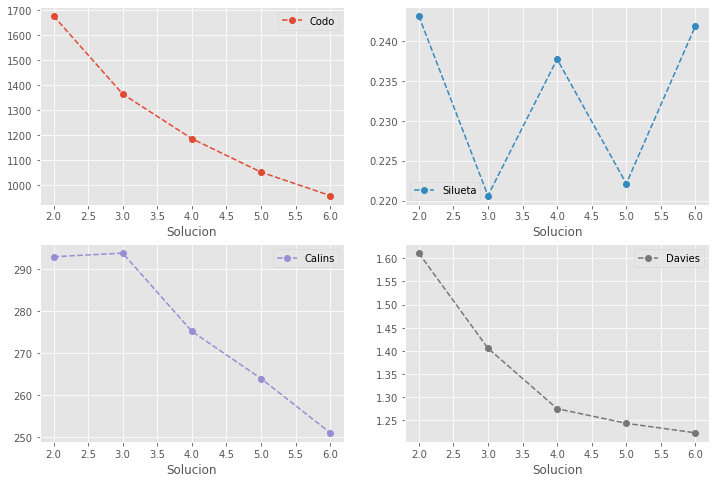

In [137]:
metricas.plot(subplots = True, figsize = (12, 8), layout = (2, 2), sharex = False, marker = 'o', ls = '--');

Derivado de las gráficas anteriores, podemos apreciar que el número de grupos a crear está entre 3 y 4. Por simplicidad y para no agrandar la caracterización de cada cluster, se crearán sólo 3. Otra herramienta de apoyo para determinar el número de grupos es mediante un heatmap, que muestre las combinaciones entre el número de grupos y las diferentes semillas.

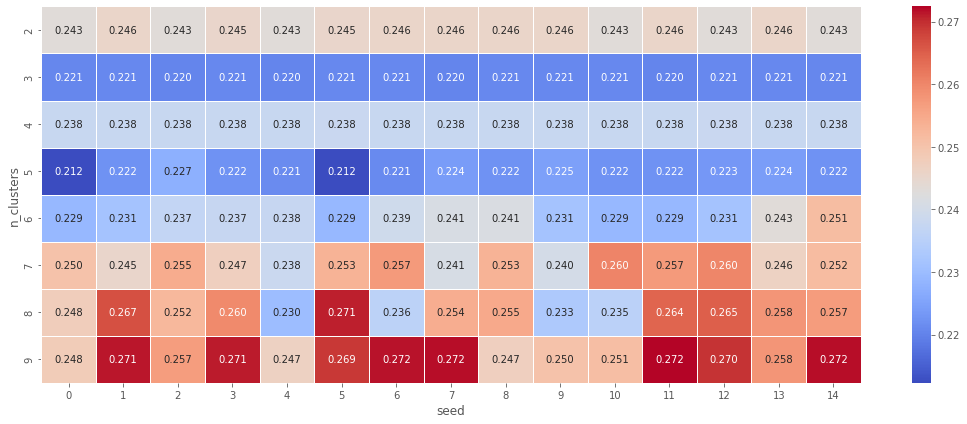

In [138]:
clusters_range = range(2, 10)

random_range = range(0, 15)
results =[]

for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters = c, random_state = r)
        cluster_labels = clusterer.fit_predict(scores_pca)
        silhouette_avg = silhouette_score(scores_pca, cluster_labels)
        results.append([c, r, silhouette_avg])

result = pd.DataFrame(results, columns = ["n_clusters", "seed", "silhouette_score"])
pivot_km = pd.pivot_table(result, index = "n_clusters", columns = "seed", values = "silhouette_score")

plt.figure(figsize = (15, 6))
sns.heatmap(pivot_km, annot = True, linewidths = 0.5, fmt = '.3f', cmap = "coolwarm")
plt.tight_layout()

En la gráfica anterior, podemos ver que es a partir de 7 grupos la creación sugerida por esta técnica, sin embargo, son grupos muy inestables, porque cambian con las diferentes semillas, cuestión que no sucede con el grupo 3, por lo que, se seguirá con la estratégia original.

## Dendograma

Antes de aplicar el algoritmo de kmeans se procede a usar un dendograma para facilitar la decsión visual de crear solo 3 clústeres.

Veamos primero como se ven los grupos con un Dendograma.

In [139]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [140]:
def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

In [141]:
# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'complete',
                            distance_threshold = 0,
                            n_clusters = None
                        )
modelo_hclust_complete.fit(X = scores_pca)

modelo_hclust_average = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'average',
                            distance_threshold = 0,
                            n_clusters = None
                        )
modelo_hclust_average.fit(X = scores_pca)

modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            distance_threshold = 0,
                            n_clusters = None
                     )
modelo_hclust_ward.fit(X = scores_pca)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

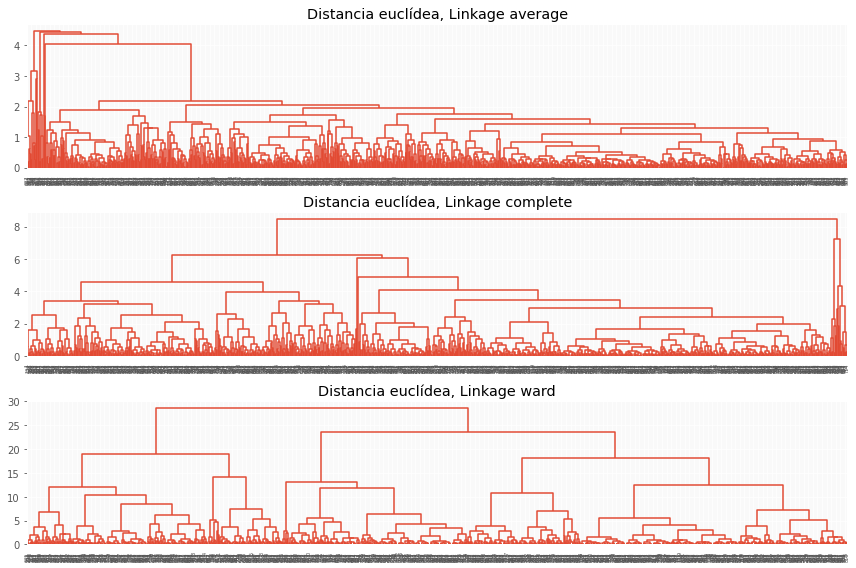

In [142]:
# Dendrogramas
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize = (12, 8))

plot_dendrogram(modelo_hclust_average, color_threshold = 0, ax = axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")

plot_dendrogram(modelo_hclust_complete, color_threshold = 0, ax = axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")

plot_dendrogram(modelo_hclust_ward, color_threshold = 0, ax = axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")

plt.tight_layout();

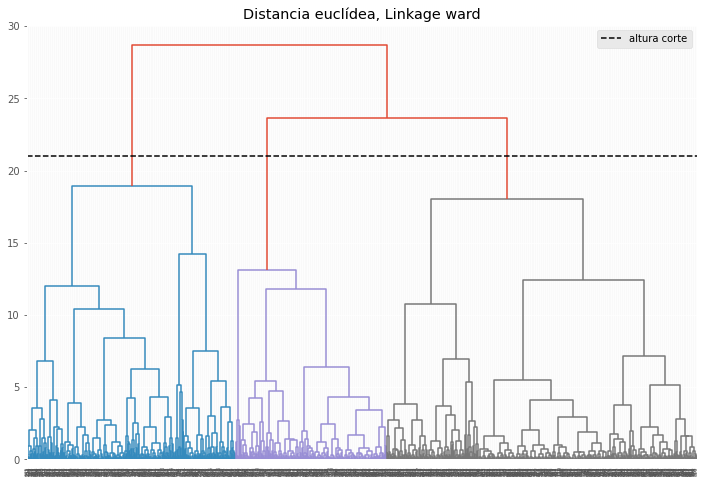

In [143]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))

altura_corte = 21

plot_dendrogram(modelo_hclust_ward, color_threshold = altura_corte, ax = ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y = altura_corte, c = 'black', linestyle = '--', label = 'altura corte')
ax.legend();

In [144]:
# Modelo
# ==============================================================================
modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            n_clusters = 3
                     )
modelo_hclust_ward.fit(X = scores_pca)

AgglomerativeClustering(n_clusters=3)

In [145]:
modelo_hclust_ward.labels_[0:15]

array([2, 0, 2, 0, 0, 0, 2, 1, 0, 1, 1, 1, 1, 2, 1], dtype=int64)

In [146]:
df_den = df.copy()
df_den['Cluster'] = modelo_hclust_ward.labels_

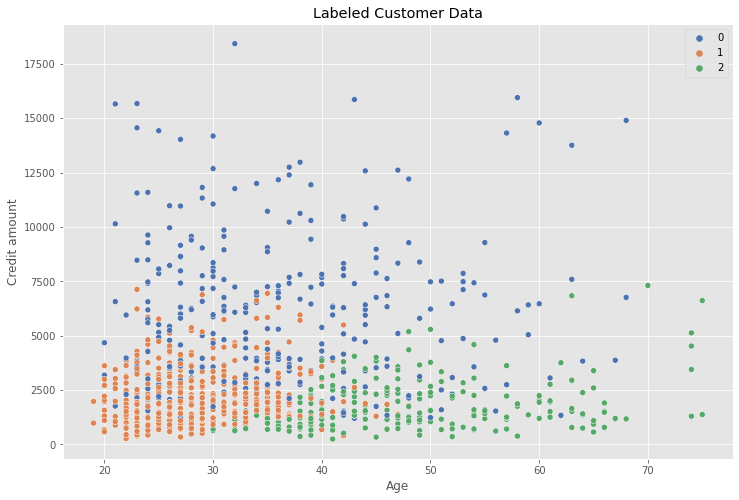

In [147]:
plt.subplots(figsize = (12, 8))

data_labels = modelo_hclust_ward.labels_

sns.scatterplot(x = 'Age', 
                y = 'Credit amount', 
                data = df, 
                hue = data_labels,
                palette = "deep").set_title('Labeled Customer Data');

In [148]:
df_den.groupby('Cluster').size()

Cluster
0    312
1    463
2    225
dtype: int64

In [149]:
df_den.groupby('Cluster')['Age','Credit amount','Duration','Monthly'].agg('median')

Age  Credit amount  Duration     Monthly
Cluster                                           
0        34.0         5275.0      20.0  250.424603
1        28.0         1927.0      18.0  108.952381
2        47.0         1445.0      12.0  102.466667

Con apoyo del dendograma se formaron los 3 grupos con 312, 463 y 225 clientes respectivamente. Ahora, se ejecutará el algoritmo kmeans.

## K-Means

In [150]:
Kmeans = KMeans(n_clusters = 3, init = "k-means++", n_init = 100, max_iter = 400, random_state = 44)
Kmeans.fit(scores_pca)
df['Cluster'] = Kmeans.predict(scores_pca)

df['Cluster'] = df['Cluster'].astype('category')

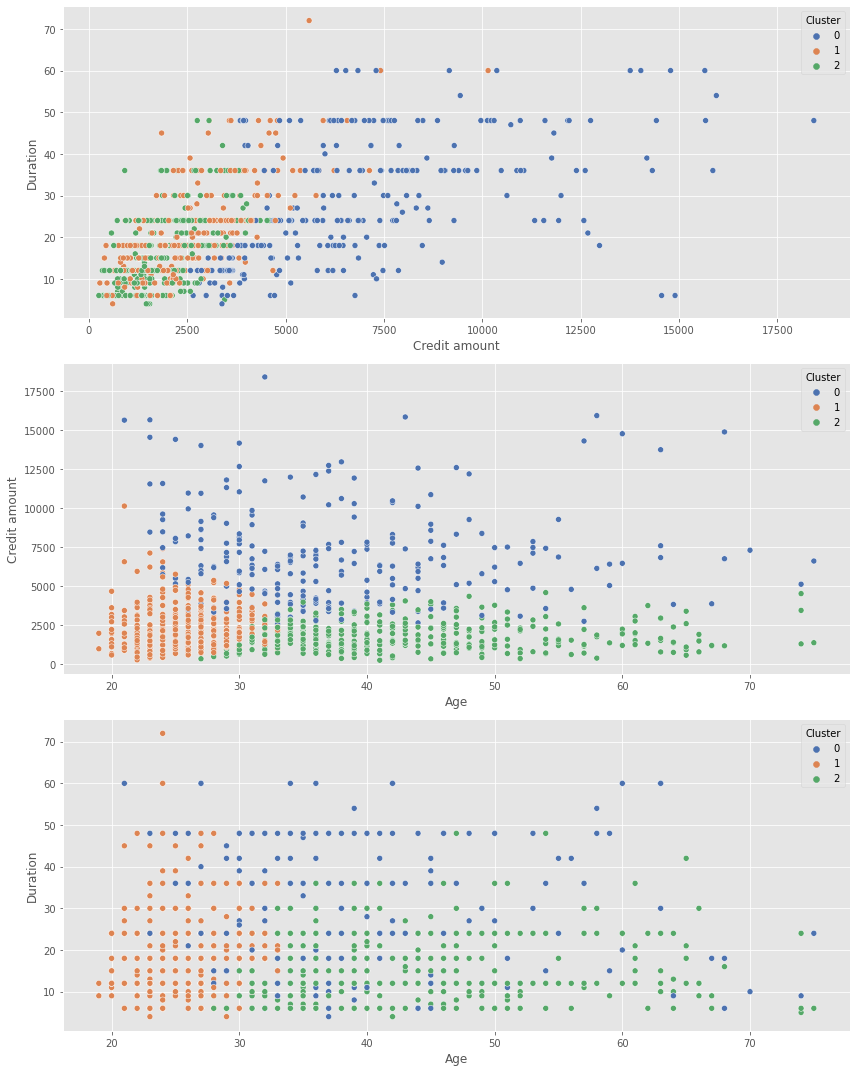

In [151]:
fig, ax = plt.subplots(3, 1, figsize = (12, 15))

sns.scatterplot(df['Credit amount'], df["Duration"], hue = df["Cluster"], ax = ax[0], palette = 'deep')
sns.scatterplot(df['Age'], df['Credit amount'], hue = df["Cluster"], ax = ax[1], palette = 'deep')
sns.scatterplot(df['Age'], df['Duration'], hue = df["Cluster"], ax = ax[2], palette = 'deep');

plt.tight_layout()

In [152]:
df.groupby('Cluster').size()

Cluster
0    248
1    363
2    389
dtype: int64

In [153]:
df.groupby('Cluster')['Age','Credit amount','Duration','Monthly'].agg('median')

Age  Credit amount  Duration     Monthly
Cluster                                           
0        36.0         6409.5      24.0  249.013889
1        26.0         2063.0      18.0  117.833333
2        40.0         1542.0      15.0  106.527778

Con este algoritmo los grupos quedan de la sigueinte manera:

* **Cluster 0**: la mediana de la edad es de 36 años con una mediana de 6,409 como monto de crédito a 2 años de plazo y mensualidad de 249.
* **Cluster 1**: la mediana de la edad es de 26 años con una mediana de 2,063 como monto de crédito a 1.5 años de plazo y mensualidad de 117.
* **Cluster 2**: la mediana de la edad es de 40 años con una mediana de 1,542 como monto de crédito a 1.25 años de plazo y mensualidad de 106.

Sí se ven diferenciados los grupos creados en cuanto a las variables númericas se refiere. A continuación, se hará un análisis descriptivo para ponerle "cara y ojos" a cada cluster.

# Caracterización de clústeres

En esta parte del trabajo se caracterizará cada grupo, para saber si realmente existen diferencias entre éstos.

In [154]:
df

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0     67    male    2     own            None           little           1169   
1     22  female    2     own          little         moderate           5951   
2     49    male    1     own          little             None           2096   
..   ...     ...  ...     ...             ...              ...            ...   
997   38    male    2     own          little             None            804   
998   23    male    2    free          little           little           1845   
999   27    male    2     own        moderate         moderate           4576   

     Duration    Purpose  Duration_disc      Age_disc     Monthly  \
0           6   radio/TV    Corto_plazo  Adulto_mayor  194.833333   
1          48   radio/TV    Largo_plazo         Joven  123.979167   
2          12  education  Mediano_plazo        Adulto  174.666667   
..        ...        ...            ...           ...         ...   
997        12   radio/TV  Mediano_plazo        Adulto   67.000000   
998        45   radio/TV    Largo_plazo         Joven   41.000000   
999        45        car    Largo_plazo         Joven  101.688889   

    Monthly_disc Cluster  
0      Menos_200       2  
1      Menos_200       1  
2      Menos_200       2  
..           ...     ...  
997    Menos_200       2  
998    Menos_200       1  
999    Menos_200       1  

[1000 rows x 14 columns]

Se creará una copia de la base por conveniencia y solo para fines exploratorios.

In [155]:
df2 = df.copy()

A la variable `Job` se le pondrán sus etiquetas.

In [156]:
jobs = {0: 'unskilled and non-resident',
        1: 'unskilled and resident', 
        2: 'skilled', 
        3: 'highly skilled'}

df2['Job'] = df2['Job'].map(jobs)

In [157]:
temp = df2.groupby('Cluster', as_index = False).Sex.value_counts()

temp['Tot_sex'] = temp.groupby('Cluster')['count'].transform(sum)
temp['Tot_sex_porc'] = round(temp['count'] / temp['Tot_sex'] *100, 2)
temp

Cluster     Sex  count  Tot_sex  Tot_sex_porc
0       0    male    193      248         77.82
1       0  female     55      248         22.18
2       1    male    204      363         56.20
3       1  female    159      363         43.80
4       2    male    293      389         75.32
5       2  female     96      389         24.68

En todos los grupos hay más hombres que mujeres, esto se acentúa más en el grupo 0, 77.82% de hombres por 22.18% de mujeres, seguido por el grupo 2 en donde hay 75.32% y 24.68%, respectivamente. Es el grupo 1, donde la distribución del género está más equilibrada 56.20% y 43.80%.

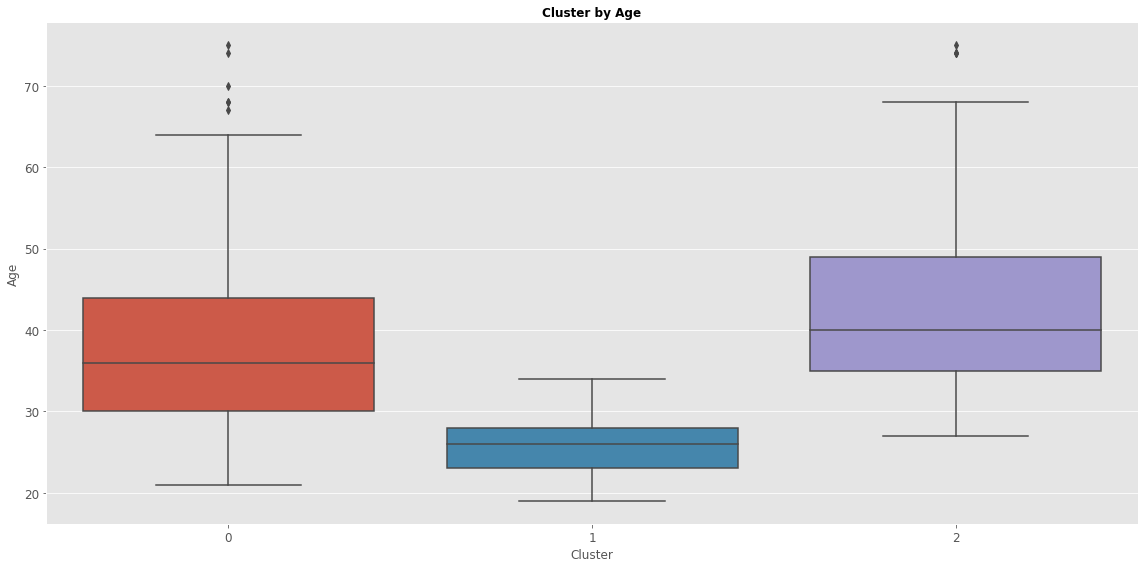

In [158]:
plot2(df = df2, x_cat = 'Cluster', y_cont = 'Age')

Con respecto a la edad, sí se aprecian diferencias entre grupos siendo el 2 el que tiene la mediana más alta. Por el contrario, el grupo 1 es en donde están los clientes con edades menores.

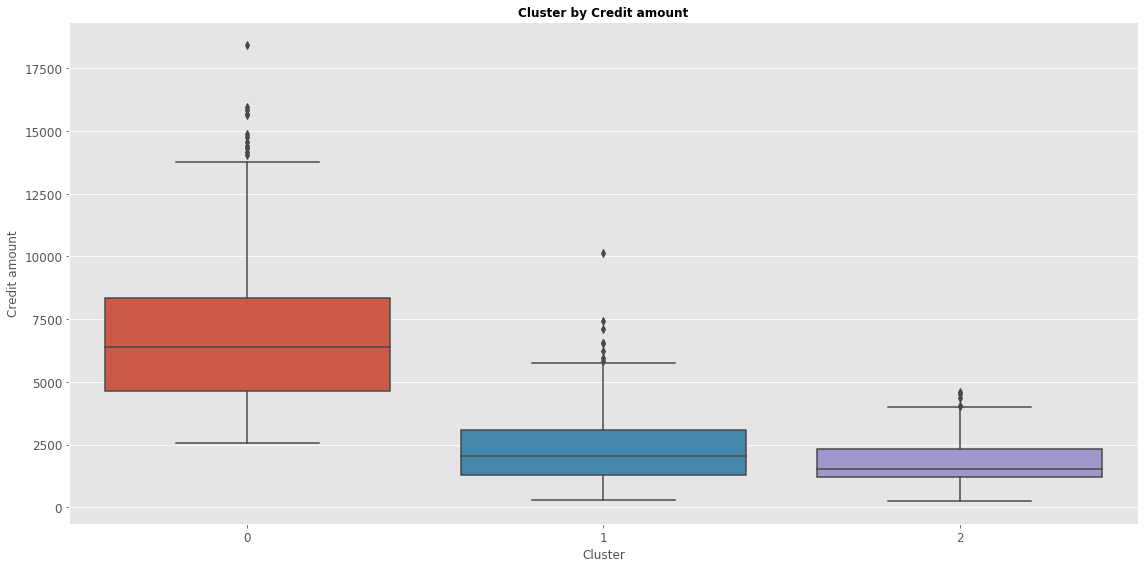

In [159]:
plot2(df = df2, x_cat = 'Cluster', y_cont = 'Credit amount')

Se aprecia una mayor diferencia entre el grupo 0 y los otros dos en cuanto al monto del crédito. El grupo 2 a pesar de que tiene valores extremos éstos no superan el bigote superior del grupo 1.

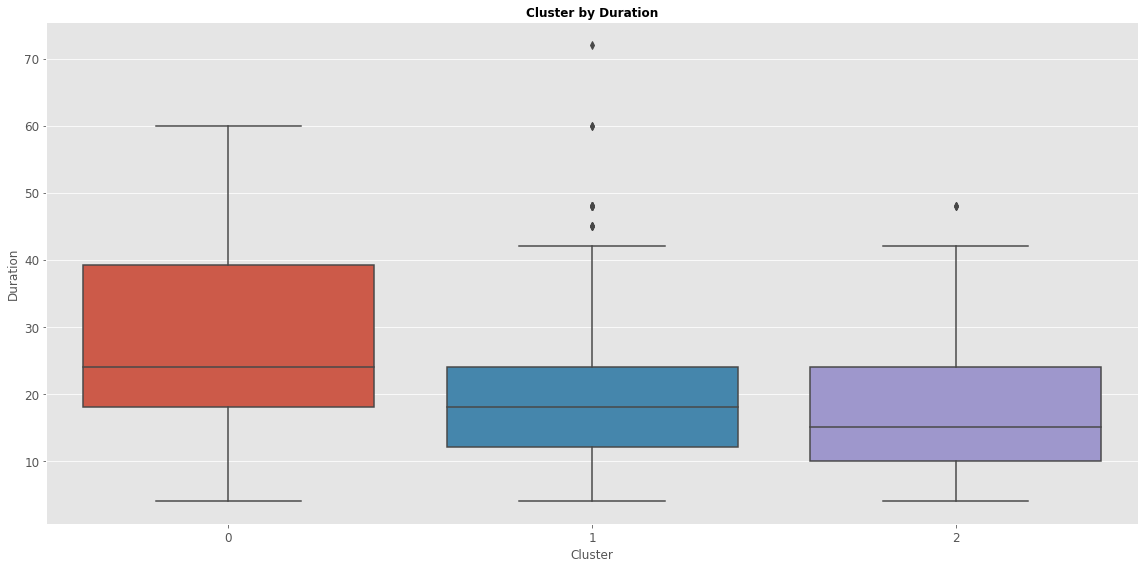

In [160]:
plot2(df = df2, x_cat = 'Cluster', y_cont = 'Duration')

Los grupos 1 y 2 prácticamente se solapan, lo que no es bueno ya que, en cuanto a la duración del crédito, no se diferencían claramente estos grupos.

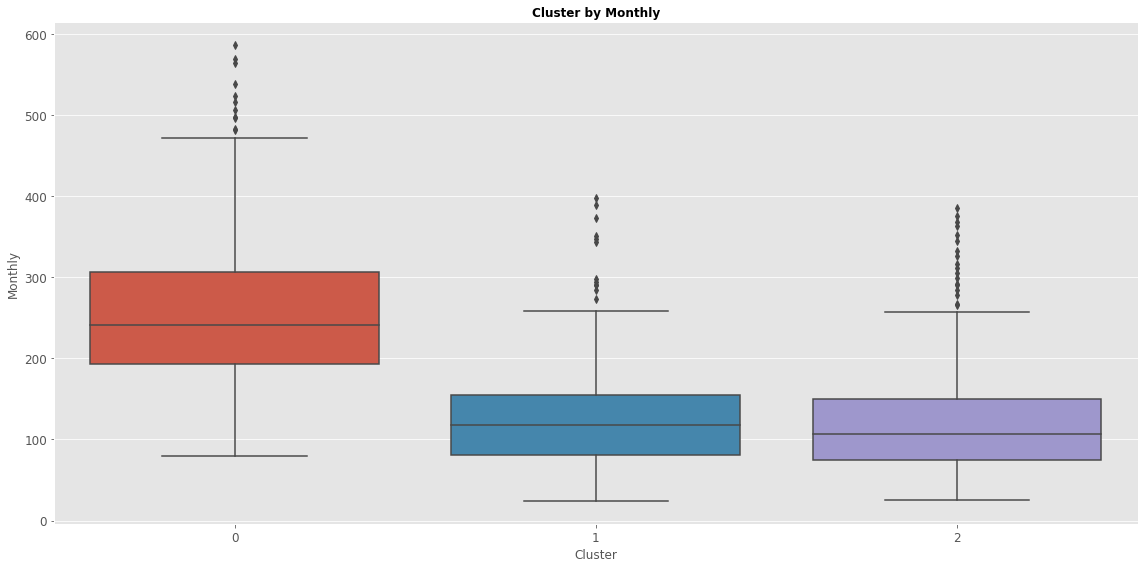

In [161]:
plot2(df = df2[df2['Monthly'] < 600], x_cat = 'Cluster', y_cont = 'Monthly')

En lo que respecta a la variable creada Monthly, vemos que tiene muchos valores atípicos principalmente en el grupo 0. Los otros 2 grupos presentan distribuciones parecidas.

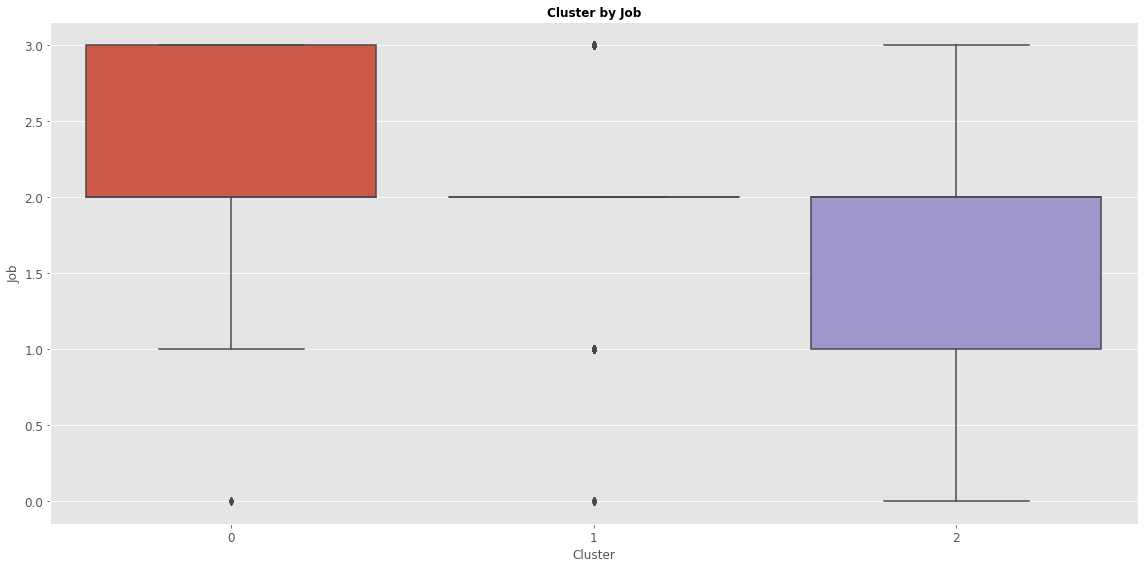

In [162]:
plot2(df = df, x_cat = 'Cluster', y_cont = 'Job')

En lo que respecta a la variable Job, se aprecian diferencias entre los grupos. El grupo 0, tiene el 50% de los clientes entre 2 y 3, el grupo 1, los tiene en 2 y el grupo 2 entre 1 y 2.

In [163]:
df2[df2['Cluster'] == 1].Job.value_counts()

skilled                       257
unskilled and resident         68
highly skilled                 29
unskilled and non-resident      9
Name: Job, dtype: int64

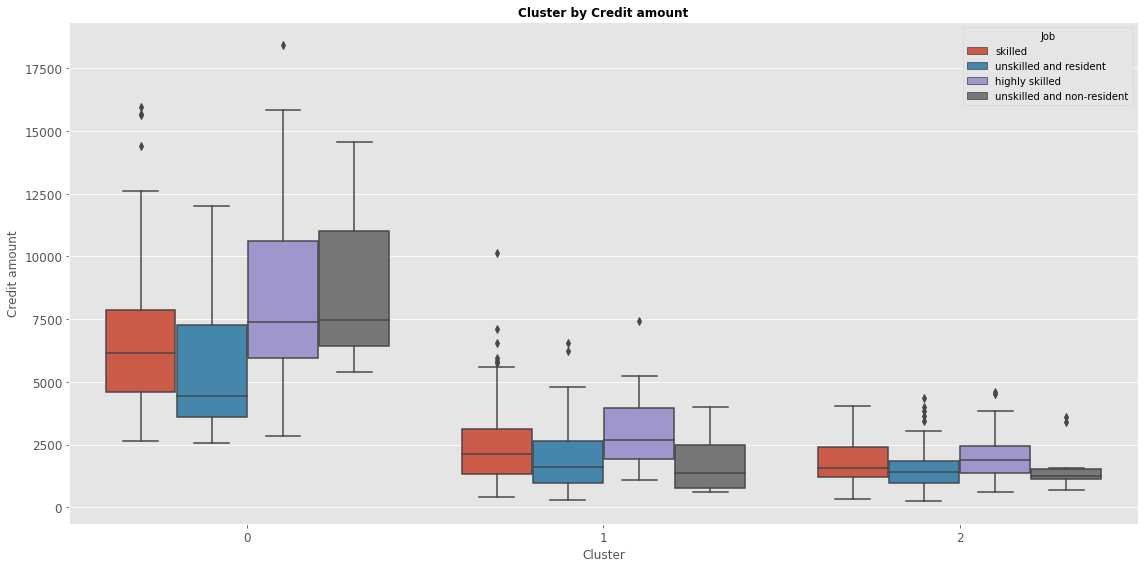

In [164]:
plot2(df = df2, x_cat = 'Cluster', y_cont = 'Credit amount', by = 'Job')

Al ponerle las etiquetas a la varaible job podemos ver que existen diferencias entre los grupos. Siendo el grupo 0 el que más se diferencía de los demás.

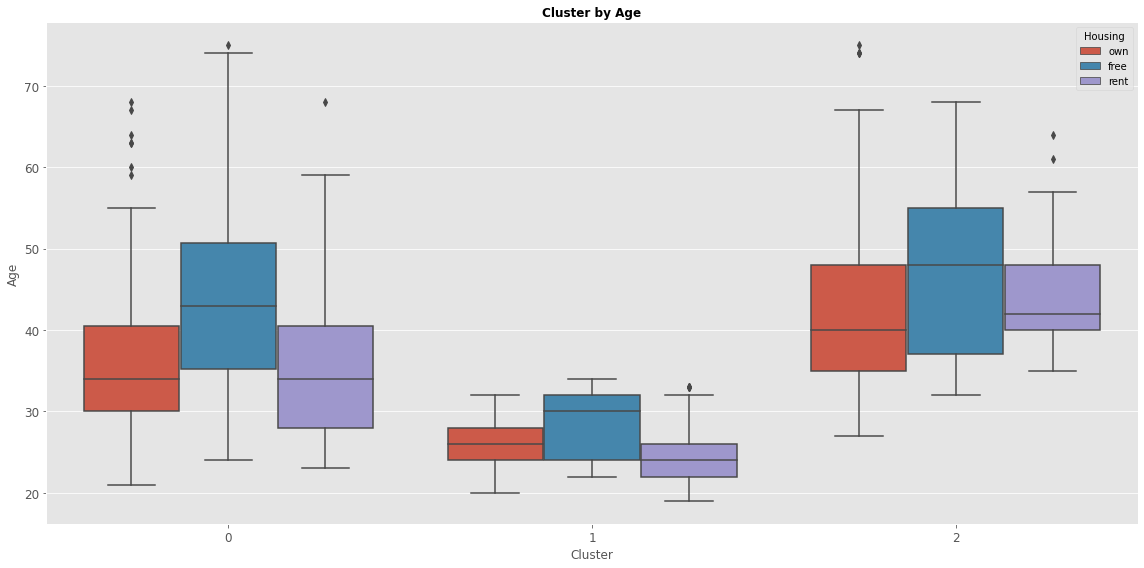

In [165]:
plot2(df = df2, x_cat = 'Cluster', y_cont = 'Age', by = 'Housing')

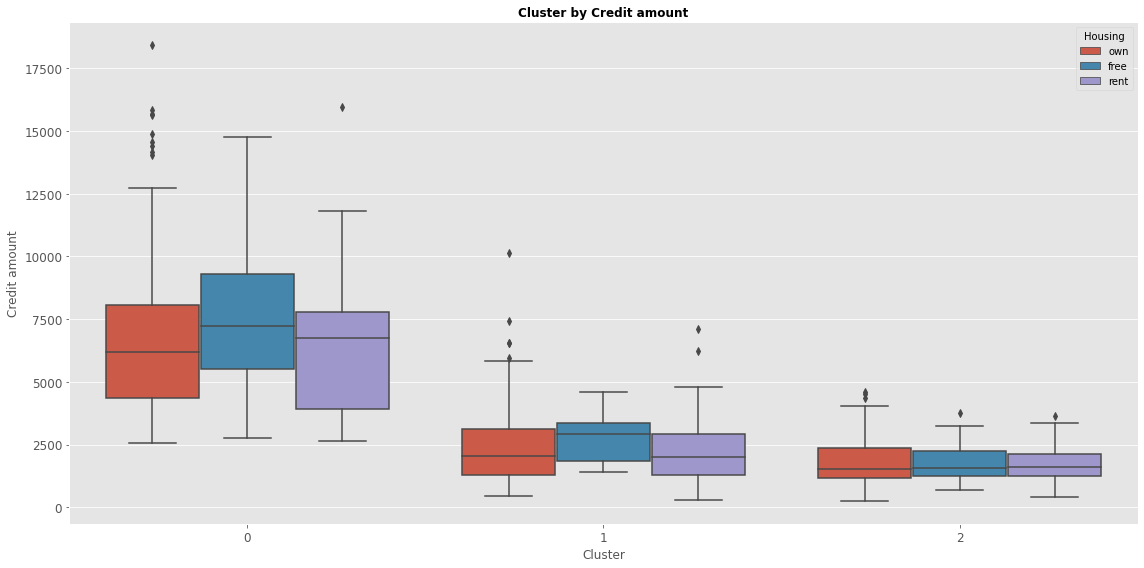

In [166]:
plot2(df = df2, x_cat = 'Cluster', y_cont = 'Credit amount', by = 'Housing')

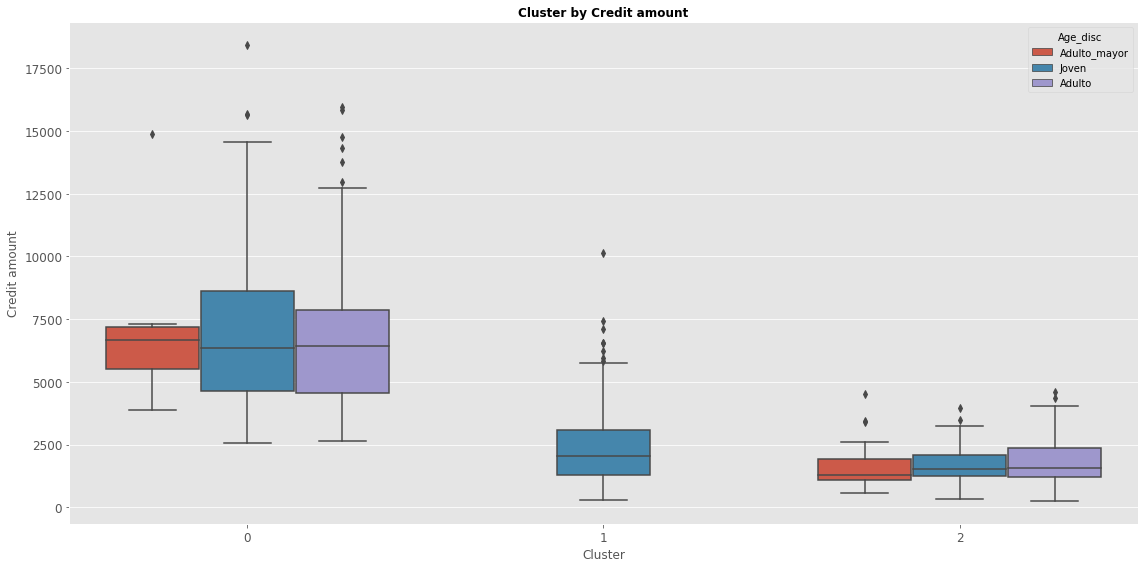

In [167]:
plot2(df = df2, x_cat = 'Cluster', y_cont = 'Credit amount', by = 'Age_disc')

In [168]:
df2.groupby('Cluster', as_index = False).Age_disc.value_counts()

Cluster      Age_disc  count
0       0         Joven    122
1       0        Adulto    120
2       0  Adulto_mayor      6
3       1         Joven    363
4       1        Adulto      0
5       1  Adulto_mayor      0
6       2        Adulto    269
7       2         Joven    103
8       2  Adulto_mayor     17

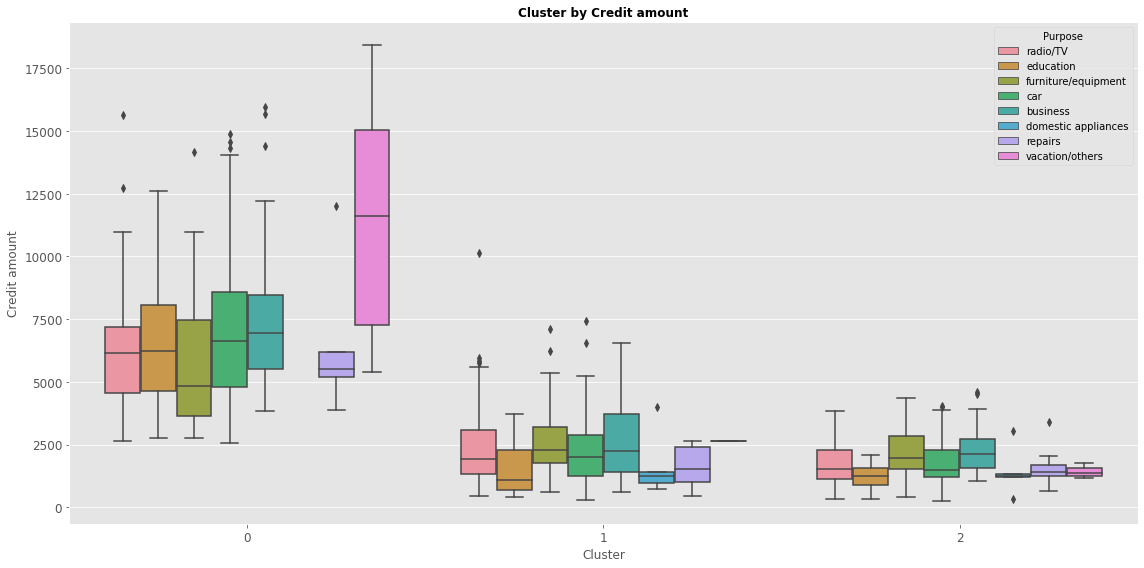

In [169]:
plot2(df = df2, x_cat = 'Cluster', y_cont = 'Credit amount', by = 'Purpose')

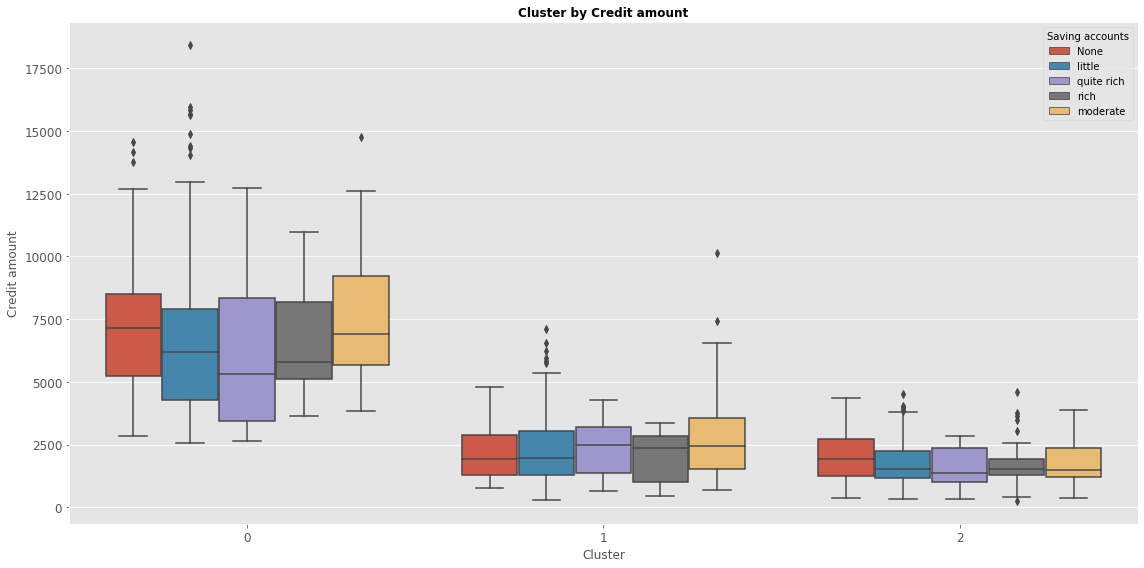

In [170]:
plot2(df = df2, x_cat = 'Cluster', y_cont = 'Credit amount', by = 'Saving accounts')

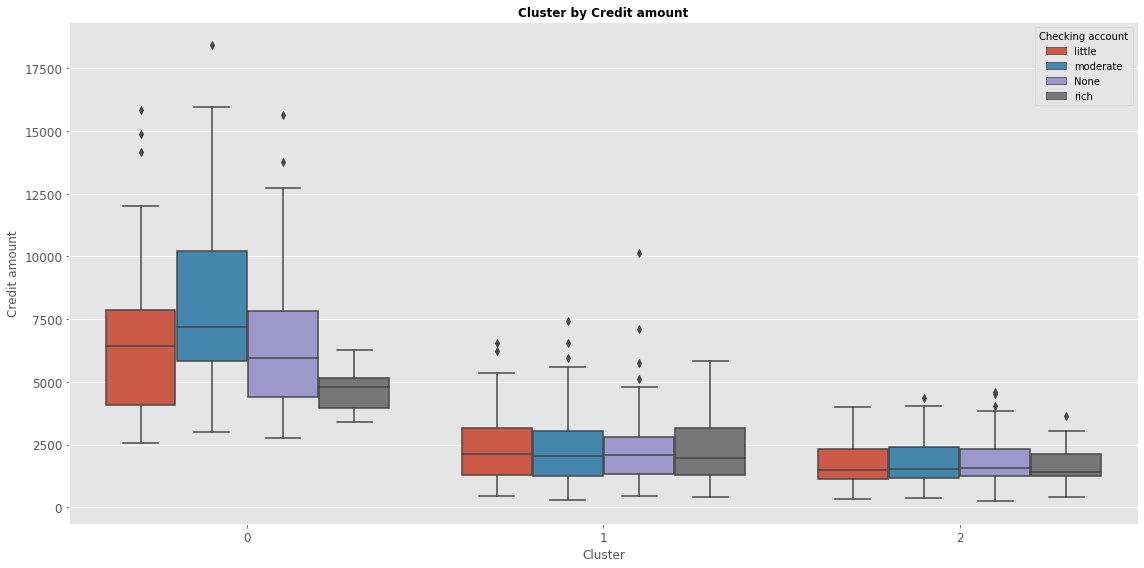

In [171]:
plot2(df = df2, x_cat = 'Cluster', y_cont = 'Credit amount', by = 'Checking account')

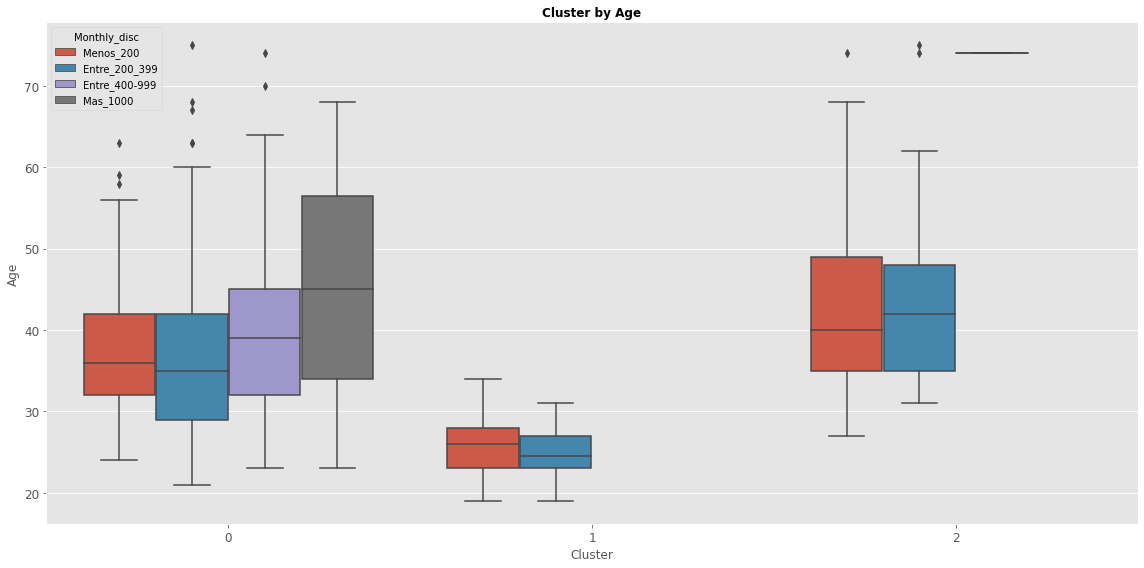

In [172]:
plot2(df = df2, x_cat = 'Cluster', y_cont = 'Age', by = 'Monthly_disc')

# Insights

A continuación, se caracterizarán los grupos creados y se generarán algunas conclusiones de negocio.

Como las variables `Age`, `Credit amount` y `Monthly` tienen valores extremos, en lugar de calcular su respectiva media se optará por la mediana.

## Cluster 0

In [173]:
Cluster_0 = df2[df2['Cluster'] == 0].copy()

* El **77.8%** son hombres.
* La mediana de la edad s de **36** años.
* El monto del crédito es de **6,799**.
* La mediana del plazo en meses es de **24**.
* En el segmento Adulto_mayor el **33%** son mujeres (es el más alto).
* El **59%** de las cuentas de ahorro pertenecen al nivel little y el 26% de los clientes no reportan tener cuenta de ahorro.
* **85%** de los clientes son calificados
* El **47%** de los clientes obtuvieron crédito para auto.
* **7,182** es la mediana más alta del monto del crédito que corresponde a las cuentas de cheques moderadas.
* De los clientes que no tienen cuenta de cheques, la mayoría solicitó crédito para auto con una mediana de **6,856** (la más alta).
* De los clientes que no tienen cuenta de ahorro, la mayoría solicitó crédito para auto con una mediana de **7,485** (la más alta).
* El top 3 de uso o destino de los créditos para los clientes calificados y altamente calificados son auto, muebles/equipo y radio/TV.
* El top 3 de uso o destino de los créditos para los clientes no calificados son auto, educación y negocio.
* El tipo de alojamiento más frecuente es propio con una mediana de crédito de **6,204** y mensualidad de **248**.
* El rango de mensualidad más frecuente esta entre 200-399 y en este rango el **56%** corresponde a clientes calificados.
* La mediana del crédito más alto es de **14,555** y corresponde con mensualidades superiores a 1,000.
* La mediana máxima del crédito por tipo de trabajo corresponde a los clientes no calificados y no residentes con una mensualidad **3 veces mayor** que los demás clientes.
* El crédito para vacaciones/otros es el concepto que tiene la mediana de la mensualidad más alta, **323**.

Distribución porcentual de clientes por rango de edades y género:

In [174]:
pd.crosstab(Cluster_0['Age_disc'], Cluster_0['Sex'], normalize = 'index', margins = True)

Sex             female      male
Age_disc                        
Adulto        0.175000  0.825000
Adulto_mayor  0.333333  0.666667
Joven         0.262295  0.737705
All           0.221774  0.778226

Distribución porcentual de clientes por rango de edades y cuenta de ahorros:

In [175]:
pd.crosstab(Cluster_0['Age_disc'], Cluster_0['Saving accounts'], normalize = 'index',margins=True)

Saving accounts      None    little  moderate  quite rich      rich
Age_disc                                                           
Adulto           0.316667  0.583333  0.050000    0.041667  0.008333
Adulto_mayor     0.166667  0.833333  0.000000    0.000000  0.000000
Joven            0.213115  0.590164  0.114754    0.032787  0.049180
All              0.262097  0.592742  0.080645    0.036290  0.028226

Distribución de clientes por tipo de trabajo y rango de edades:

In [176]:
pd.crosstab(Cluster_0['Job'], Cluster_0['Age_disc'], margins=True)

Age_disc                    Adulto  Adulto_mayor  Joven  All
Job                                                         
highly skilled                  44             4     29   77
skilled                         59             2     75  136
unskilled and non-resident       1             0      2    3
unskilled and resident          16             0     16   32
All                            120             6    122  248

Distribución porcentual de clientes por rango de edades y propósito del crédito:

In [177]:
pd.crosstab(Cluster_0['Purpose'], Cluster_0['Age_disc'], margins = True, normalize = 'columns')

Age_disc               Adulto  Adulto_mayor     Joven       All
Purpose                                                        
business             0.150000      0.000000  0.106557  0.125000
car                  0.483333      0.833333  0.459016  0.479839
education            0.066667      0.000000  0.073770  0.068548
furniture/equipment  0.125000      0.000000  0.172131  0.145161
radio/TV             0.116667      0.000000  0.147541  0.129032
repairs              0.025000      0.166667  0.008197  0.020161
vacation/others      0.033333      0.000000  0.032787  0.032258

Número de clientes y mediana del monto de crédito por tipo de cuenta de cheques:

In [178]:
Cluster_0.groupby('Checking account')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Checking account               
moderate             76  7182.5
little               67  6419.0
None                100  5948.5
rich                  5  4796.0

Mediana del monto de crédito por propósito o destino de clientes que no tienen cuenta de cheques reportada:

In [179]:
Cluster_0[Cluster_0['Checking account'] == 'None'] \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Purpose                           
business                10  6856.5
car                     50  6761.0
vacation/others          1  6314.0
radio/TV                16  6012.0
repairs                  2  5348.5
furniture/equipment     14  4338.5
education                7  3832.0

Mediana del monto de crédito por propósito o destino de clientes que no tienen cuenta de ahorro reportada:

In [180]:
Cluster_0[Cluster_0['Saving accounts'] == 'None'] \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median',ascending = False)

count  median
Purpose                           
car                     33  7485.0
business                 9  7409.0
furniture/equipment      4  7035.5
radio/TV                13  6742.0
education                4  6151.5
vacation/others          1  5381.0
repairs                  1  5190.0

Mediana del monto del crédito de clientes calificados y altamente calificados:

In [181]:
Cluster_0.query('Job in ["skilled","highly skilled"]') \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count   median
Purpose                            
vacation/others          7  11938.0
business                27   7297.0
car                    100   6761.0
education               12   6587.5
radio/TV                31   6070.0
repairs                  3   5190.0
furniture/equipment     33   5150.0

Mediana del monto del crédito de clientes no calificados:

In [182]:
Cluster_0.query('Job not in ["skilled","highly skilled"]') \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1)

count  median
Purpose                           
business                 4  5097.5
car                     19  4716.0
education                5  3565.0
furniture/equipment      3  3643.0
radio/TV                 1  7418.0
repairs                  2  9101.0
vacation/others          1  5381.0

Mediana del crédito por tipo de alojamiento:

In [183]:
Cluster_0.groupby('Housing')[['Credit amount']].agg(['count', 'median']).stack(level = -2).droplevel(-1)

count  median
Housing               
free        54  7213.5
own        155  6204.0
rent        39  6761.0

Mediana de la mensualidad por tipo de alojamiento:

In [184]:
Cluster_0.groupby('Housing')[['Monthly']].agg(['count', 'median']).stack(level = -2).droplevel(-1)

count      median
Housing                   
free        54  229.133333
own        155  248.527778
rent        39  290.291667

Distribución porcentual del rango de mensualidad por rango de edades:

In [185]:
pd.crosstab(Cluster_0['Monthly_disc'], Cluster_0['Age_disc'], margins = True, normalize = 'columns')

Age_disc         Adulto  Adulto_mayor     Joven       All
Monthly_disc                                             
Entre_200_399  0.558333      0.500000  0.647541  0.600806
Entre_400-999  0.166667      0.333333  0.090164  0.133065
Mas_1000       0.008333      0.166667  0.008197  0.012097
Menos_200      0.266667      0.000000  0.254098  0.254032

Distribución porcentual del rango de mensualidad por tipo de trabajo:

In [186]:
pd.crosstab(Cluster_0['Monthly_disc'], Cluster_0['Job'], margins = True, normalize = 'index')

Job            highly skilled   skilled  unskilled and non-resident  \
Monthly_disc                                                          
Entre_200_399        0.302013  0.563758                    0.000000   
Entre_400-999        0.454545  0.393939                    0.030303   
Mas_1000             0.666667  0.000000                    0.333333   
Menos_200            0.238095  0.619048                    0.015873   
All                  0.310484  0.548387                    0.012097   

Job            unskilled and resident  
Monthly_disc                           
Entre_200_399                0.134228  
Entre_400-999                0.121212  
Mas_1000                     0.000000  
Menos_200                    0.126984  
All                          0.129032

Mediana del crédito por tipo de rango de mensualidad:

In [187]:
Cluster_0.groupby('Monthly_disc')[['Credit amount']] \
    .agg(['count', 'median']).stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count   median
Monthly_disc                 
Mas_1000           3  14555.0
Entre_200_399    149   6468.0
Entre_400-999     33   6468.0
Menos_200         63   6224.0

Mediana del crédito por tipo de trabajo:

In [188]:
Cluster_0.groupby('Job')[['Credit amount']] \
    .agg(['count', 'median']).stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Job                                      
unskilled and non-resident      3  7472.0
highly skilled                 77  7374.0
skilled                       136  6167.5
unskilled and resident         32  4453.0

Mediana de la mensualidad por tipo de trabajo:

In [189]:
Cluster_0.groupby('Job')[['Monthly']] \
    .agg(['count', 'median']).stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count      median
Job                                          
unskilled and non-resident      3  622.666667
highly skilled                 77  263.083333
unskilled and resident         32  255.930556
skilled                       136  229.770833

Mediana de la mensualidad por tipo de propósito:

In [190]:
Cluster_0.groupby('Purpose')[['Monthly']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count      median
Purpose                               
vacation/others          8  323.458333
car                    119  263.933333
furniture/equipment     36  240.794444
education               17  239.291667
repairs                  5  229.458333
radio/TV                32  226.543750
business                31  196.333333

## Cluster 1

In [191]:
Cluster_1 = df2[df2['Cluster'] == 1].copy()

* El **56%** son hombres.
* Sólo hay segmento de clientes jovenes.
* La edad promedio es de **26** años.
* La mediana del monto del crédito es de **2,063**.
* Su plazo pormedio en meses es de **18**.
* El **65%** de las cuentas de ahorro pertenecen al nivel little y el 12% de los clientes no reportan tener cuenta de ahorro.
* **70%** de los clientes son calificados.
* El **33%** de los clientes obtuvieron crédito para radio/TV.
* **2,122** es la mediana más alta del monto del crédito que corresponde a las cuentas de cheques little.
* De los clientes que no tienen cuenta de cheques, la mayoría solicitó crédito para radio/TV con una mediana de **1,934**.
* De los clientes que no tienen cuenta de ahorro, la mayoría solicitó crédito para auto con una mediana de **1,761**.
* El top 3 de uso o destino de los créditos para los clientes calificados y altamente calificados son radio/TV, car y furniture/equipment.
* El top 3 de uso o destino de los créditos para los clientes no calificados son car, furniture/equipment y radio/TV.
* El tipo de alojamiento más frecuente es propio con una mediana de crédito de **2,039** y mensualidad de **116**.
* El rango de mensualidad más frecuente es menos de 200 y este rango representa el **90%** de clientes.
* De las mensualidades menores de 200, el 69% pertenecen a clientes calificados.
* La mediana del crédito más alto es de **2,178** y corresponde con mensualidades entre 200-399.
* La mediana máxima del crédito por tipo de trabajo corresponde a los clientes altamente calificados con una mensualidad de 2,679.
* El crédito para furniture/equipment es el concepto que tiene la mediana de la mensualidad más alta, **137**.

Distribución porcentual de clientes por rango de edades y género:

In [192]:
pd.crosstab(Cluster_1['Age_disc'], Cluster_1['Sex'], normalize = 'index', margins = True)

Sex         female      male
Age_disc                    
Joven     0.438017  0.561983
All       0.438017  0.561983

Distribución porcentual de clientes por rango de edades y cuenta de ahorros:

In [193]:
pd.crosstab(Cluster_1['Age_disc'], Cluster_1['Saving accounts'], normalize = 'index',margins=True)

Saving accounts      None    little  moderate  quite rich      rich
Age_disc                                                           
Joven            0.126722  0.650138  0.123967    0.066116  0.033058
All              0.126722  0.650138  0.123967    0.066116  0.033058

Distribución de clientes por tipo de trabajo y rango de edades:

In [194]:
pd.crosstab(Cluster_1['Job'], Cluster_1['Age_disc'], margins = True)

Age_disc                    Joven  All
Job                                   
highly skilled                 29   29
skilled                       257  257
unskilled and non-resident      9    9
unskilled and resident         68   68
All                           363  363

Distribución porcentual de clientes por rango de edades y propósito del crédito:

In [195]:
pd.crosstab(Cluster_1['Purpose'], Cluster_1['Age_disc'], margins = True, normalize = 'columns')

Age_disc                Joven       All
Purpose                                
business             0.099174  0.099174
car                  0.256198  0.256198
domestic appliances  0.016529  0.016529
education            0.033058  0.033058
furniture/equipment  0.236915  0.236915
radio/TV             0.330579  0.330579
repairs              0.024793  0.024793
vacation/others      0.002755  0.002755

Número de clientes y mediana del monto de crédito por tipo de cuenta de cheques:

In [196]:
Cluster_1.groupby('Checking account')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Checking account               
little              114  2122.5
None                116  2076.5
moderate            108  2029.0
rich                 25  1961.0

Mediana del monto de crédito por propósito o destino de clientes que no tienen cuenta de cheques reportada:

In [197]:
Cluster_1[Cluster_1['Checking account'] == 'None'] \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Purpose                           
car                     27  2603.0
business                14  2155.5
furniture/equipment     26  2048.5
radio/TV                41  1934.0
repairs                  4  1469.5
education                2  1400.5
domestic appliances      2  1055.0

Mediana del monto de crédito por propósito o destino de clientes que no tienen cuenta de ahorro reportada:

In [198]:
Cluster_1[Cluster_1['Saving accounts'] == 'None'] \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median',ascending = False)

count  median
Purpose                           
education                2  2455.5
furniture/equipment     10  2159.0
business                 1  1887.0
car                     16  1761.0
radio/TV                13  1484.0
domestic appliances      3  1275.0
repairs                  1   996.0

Mediana del monto del crédito de clientes calificados y altamente calificados:

In [199]:
Cluster_1.query('Job in ["skilled","highly skilled"]') \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Purpose                           
vacation/others          1  2629.0
furniture/equipment     66  2353.5
business                27  2326.0
car                     72  2263.5
radio/TV               100  1965.0
education               10  1532.0
repairs                  5  1514.0
domestic appliances      5  1236.0

Mediana del monto del crédito de clientes no calificados:

In [200]:
Cluster_1.query('Job not in ["skilled","highly skilled"]') \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1)

count  median
Purpose                           
business                 9  1797.0
car                     21  1246.0
domestic appliances      1  3990.0
education                2   843.5
furniture/equipment     20  2198.0
radio/TV                20  1602.5
repairs                  4  1522.0

Mediana del crédito por tipo de alojamiento:

In [201]:
Cluster_1.groupby('Housing')[['Credit amount']].agg(['count', 'median']).stack(level = -2).droplevel(-1)

count  median
Housing               
free        13  2910.0
own        239  2039.0
rent       111  2002.0

Mediana de la mensualidad por tipo de alojamiento:

In [202]:
Cluster_1.groupby('Housing')[['Monthly']].agg(['count', 'median']).stack(level = -2).droplevel(-1)

count      median
Housing                   
free        13  127.875000
own        239  116.944444
rent       111  118.000000

Distribución porcentual del rango de mensualidad por rango de edades:

In [203]:
pd.crosstab(Cluster_1['Monthly_disc'], Cluster_1['Age_disc'], margins = True, normalize = 'columns')

Age_disc          Joven       All
Monthly_disc                     
Entre_200_399  0.099174  0.099174
Menos_200      0.900826  0.900826

Distribución porcentual del rango de mensualidad por tipo de trabajo:

In [204]:
pd.crosstab(Cluster_1['Monthly_disc'], Cluster_1['Job'], margins = True, normalize = 'index')

Job            highly skilled   skilled  unskilled and non-resident  \
Monthly_disc                                                          
Entre_200_399        0.027778  0.833333                    0.027778   
Menos_200            0.085627  0.694190                    0.024465   
All                  0.079890  0.707989                    0.024793   

Job            unskilled and resident  
Monthly_disc                           
Entre_200_399                0.111111  
Menos_200                    0.195719  
All                          0.187328

Mediana del crédito por tipo de rango de mensualidad:

In [205]:
Cluster_1.groupby('Monthly_disc')[['Credit amount']] \
    .agg(['count', 'median']).stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Monthly_disc                
Entre_200_399     36  2178.0
Menos_200        327  1987.0

Mediana del crédito por tipo de trabajo:

In [206]:
Cluster_1.groupby('Job')[['Credit amount']] \
    .agg(['count', 'median']).stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Job                                      
highly skilled                 29  2679.0
skilled                       257  2124.0
unskilled and resident         68  1613.5
unskilled and non-resident      9  1352.0

Mediana de la mensualidad por tipo de trabajo:

In [207]:
Cluster_1.groupby('Job')[['Monthly']] \
    .agg(['count', 'median']).stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count      median
Job                                          
highly skilled                 29  123.750000
skilled                       257  120.500000
unskilled and non-resident      9  118.166667
unskilled and resident         68  105.150000

Mediana de la mensualidad por tipo de propósito:

In [208]:
Cluster_1.groupby('Purpose')[['Monthly']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count      median
Purpose                               
furniture/equipment     86  137.083333
vacation/others          1  131.450000
business                36  119.083333
car                     93  113.250000
radio/TV               120  109.805556
domestic appliances      6   97.916667
repairs                  9   92.333333
education               12   74.916667

## Cluster 2

In [209]:
Cluster_2 = df2[df2['Cluster'] == 2].copy()

* El **75.3%** son hombres.
* La mediana de la edad s de **40** años.
* El monto del crédito es de **1,542**.
* La mediana del plazo en meses es de **15**.
* En el segmento Joven el **30%** son mujeres.
* El **56%** de las cuentas de ahorro pertenecen al nivel little y el 18% de los clientes no reportan tener cuenta de ahorro.
* **61%** de los clientes son calificados.
* El **32%** de los clientes obtuvieron crédito para radio/TV y otro 32% para auto.
* **1,557** es la mediana más alta del monto del crédito que corresponde a los clientes sin cuentas de cheques.
* De los clientes que no tienen cuenta de cheques, la mayoría solicitó crédito para radio/TV con una mediana de **1,548**.
* De los clientes que no tienen cuenta de ahorro, la mayoría solicitó crédito para radio/TV con una mediana de **1,702**.
* El top 3 de uso o destino de los créditos para los clientes calificados y altamente calificados son radio/TV, car y furniture/equipment.
* El top 3 de uso o destino de los créditos para los clientes no calificados son car, radio/TV y furniture/equipment.
* El tipo de alojamiento más frecuente es propio con una mediana de crédito de **1,538** y mensualidad de **105**.
* El rango de mensualidad más frecuente es menos de 200 y en este rango el **62%** corresponde a clientes calificados.
* La mediana máxima del crédito por tipo de trabajo corresponde a los clientes altamente calificados con una mensualidad de **1,894**.
* El crédito para furniture/equipment es el concepto que tiene la mediana de la mensualidad más alta, **122**.

Distribución porcentual de clientes por rango de edades y género:

In [210]:
pd.crosstab(Cluster_2['Age_disc'], Cluster_2['Sex'], normalize = 'index', margins = True)

Sex             female      male
Age_disc                        
Adulto        0.226766  0.773234
Adulto_mayor  0.235294  0.764706
Joven         0.300971  0.699029
All           0.246787  0.753213

Distribución porcentual de clientes por rango de edades y cuenta de ahorros:

In [211]:
pd.crosstab(Cluster_2['Age_disc'], Cluster_2['Saving accounts'], normalize = 'index',margins=True)

Saving accounts      None    little  moderate  quite rich      rich
Age_disc                                                           
Adulto           0.204461  0.553903  0.078067    0.085502  0.078067
Adulto_mayor     0.176471  0.647059  0.000000    0.176471  0.000000
Joven            0.135922  0.582524  0.165049    0.038835  0.077670
All              0.185090  0.565553  0.097686    0.077121  0.074550

Distribución de clientes por tipo de trabajo y rango de edades:

In [212]:
pd.crosstab(Cluster_2['Job'], Cluster_2['Age_disc'], margins=True)

Age_disc                    Adulto  Adulto_mayor  Joven  All
Job                                                         
highly skilled                  25             5     12   42
skilled                        163             4     70  237
unskilled and non-resident       4             5      1   10
unskilled and resident          77             3     20  100
All                            269            17    103  389

Distribución porcentual de clientes por rango de edades y propósito del crédito:

In [213]:
pd.crosstab(Cluster_2['Purpose'], Cluster_2['Age_disc'], margins = True, normalize = 'columns')

Age_disc               Adulto  Adulto_mayor     Joven       All
Purpose                                                        
business             0.070632      0.176471  0.077670  0.077121
car                  0.353160      0.352941  0.233010  0.321337
domestic appliances  0.018587      0.000000  0.009709  0.015424
education            0.078067      0.058824  0.077670  0.077121
furniture/equipment  0.144981      0.000000  0.194175  0.151671
radio/TV             0.304833      0.352941  0.388350  0.329049
repairs              0.018587      0.058824  0.019417  0.020566
vacation/others      0.011152      0.000000  0.000000  0.007712

Número de clientes y mediana del monto de crédito por tipo de cuenta de cheques:

In [214]:
Cluster_2.groupby('Checking account')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Checking account               
None                178  1557.0
moderate             85  1537.0
little               93  1478.0
rich                 33  1424.0

Mediana del monto de crédito por propósito o destino de clientes que no tienen cuenta de cheques reportada:

In [215]:
Cluster_2[Cluster_2['Checking account'] == 'None'] \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Purpose                           
business                13  2292.0
repairs                  2  1806.5
furniture/equipment     19  1592.0
radio/TV                70  1548.0
car                     57  1503.0
education               15  1393.0
domestic appliances      2  1300.0

Mediana del monto de crédito por propósito o destino de clientes que no tienen cuenta de ahorro reportada:

In [216]:
Cluster_2[Cluster_2['Saving accounts'] == 'None'] \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median',ascending = False)

count  median
Purpose                           
business                 4  2626.0
car                     25  2197.0
radio/TV                26  1702.0
furniture/equipment      7  1520.0
vacation/others          1  1358.0
education                9  1239.0

Mediana del monto del crédito de clientes calificados y altamente calificados:

In [217]:
Cluster_2.query('Job in ["skilled","highly skilled"]') \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Purpose                           
business                21  2292.0
furniture/equipment     48  2090.0
car                     87  1804.0
radio/TV                90  1567.0
repairs                  5  1512.0
domestic appliances      5  1262.0
vacation/others          2  1261.0
education               21  1239.0

Mediana del monto del crédito de clientes no calificados:

In [218]:
Cluster_2.query('Job not in ["skilled","highly skilled"]') \
    .groupby('Purpose')[['Credit amount']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1)

count  median
Purpose                           
business                 9  1941.0
car                     38  1293.0
domestic appliances      1  1217.0
education                9  1047.0
furniture/equipment     11  1736.0
radio/TV                38  1380.5
repairs                  3  1308.0
vacation/others          1  1755.0

Mediana del crédito por tipo de alojamiento:

In [219]:
Cluster_2.groupby('Housing')[['Credit amount']].agg(['count', 'median']).stack(level = -2).droplevel(-1)

count  median
Housing               
free        41  1555.0
own        319  1538.0
rent        29  1597.0

Mediana de la mensualidad por tipo de alojamiento:

In [220]:
Cluster_2.groupby('Housing')[['Monthly']].agg(['count', 'median']).stack(level = -2).droplevel(-1)

count      median
Housing                   
free        41  110.222222
own        319  105.166667
rent        29  125.250000

Distribución porcentual del rango de mensualidad por rango de edades:

In [221]:
pd.crosstab(Cluster_2['Monthly_disc'], Cluster_2['Age_disc'], margins = True, normalize = 'columns')

Age_disc         Adulto  Adulto_mayor     Joven       All
Monthly_disc                                             
Entre_200_399  0.096654      0.117647  0.126214  0.105398
Entre_400-999  0.000000      0.058824  0.000000  0.002571
Menos_200      0.903346      0.823529  0.873786  0.892031

Distribución porcentual del rango de mensualidad por tipo de trabajo:

In [222]:
pd.crosstab(Cluster_2['Monthly_disc'], Cluster_2['Job'], margins = True, normalize = 'index')

Job            highly skilled   skilled  unskilled and non-resident  \
Monthly_disc                                                          
Entre_200_399        0.146341  0.512195                    0.024390   
Entre_400-999        0.000000  0.000000                    0.000000   
Menos_200            0.103746  0.622478                    0.025937   
All                  0.107969  0.609254                    0.025707   

Job            unskilled and resident  
Monthly_disc                           
Entre_200_399                0.317073  
Entre_400-999                1.000000  
Menos_200                    0.247839  
All                          0.257069

Mediana del crédito por tipo de rango de mensualidad:

In [223]:
Cluster_2.groupby('Monthly_disc')[['Credit amount']] \
    .agg(['count', 'median']).stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Monthly_disc                
Entre_400-999      1  3448.0
Entre_200_399     41  1750.0
Menos_200        347  1530.0

Mediana del crédito por tipo de trabajo:

In [224]:
Cluster_2.groupby('Job')[['Credit amount']] \
    .agg(['count', 'median']).stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count  median
Job                                      
highly skilled                 42  1894.5
skilled                       237  1585.0
unskilled and resident        100  1392.0
unskilled and non-resident     10  1244.5

Mediana de la mensualidad por tipo de trabajo:

In [225]:
Cluster_2.groupby('Job')[['Monthly']] \
    .agg(['count', 'median']).stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count      median
Job                                          
highly skilled                 42  130.894444
unskilled and resident        100  105.958333
skilled                       237  102.133333
unskilled and non-resident     10   96.404762

Mediana de la mensualidad por tipo de propósito:

In [226]:
Cluster_2.groupby('Purpose')[['Monthly']] \
    .agg(['count', 'median']) \
    .stack(level = -2).droplevel(-1) \
    .sort_values(by = 'median', ascending = False)

count      median
Purpose                               
furniture/equipment     59  122.833333
business                30  113.020833
car                    125  112.000000
education               30  103.066667
radio/TV               128   99.527778
repairs                  8   86.475000
domestic appliances      6   75.872222
vacation/others          3   73.125000

# Caso de negocio

Vamos a suponer que el banco va a lanzar una campaña para otorgar créditos para auto pero sólo a sus clientes que tengan casa propia con la intención de tomar ese bien como garantía en caso de impago, que mínimo cuenten con un trabajo calificado y, además, que hayan tenido ya un crédito liquidado cuyo plazo no haya excedido los 2 años.

Se nos pide hacer un análisis para identificar el perfil del cliente al cual se le pueda dirigir esa campaña para maximizar los resultados. 

Por tanto, como primer paso hay que identificar a esos clientes con esas condiciones y a qué clúster pertenecen la mayoría.

In [227]:
print('Clientes con esos antecedentes:',
      df2[(df2.Purpose != 'car') & (df2.Housing == 'own') & ((df2.Job == 'skilled') | (df2.Job == 'highly skilled'))].shape[0])

Clientes con esos antecedentes: 385


Identificar clientes con las condiciones antes mencionadas por cluster.

In [228]:
df2[(df2.Purpose != 'car') & (df2.Housing == 'own') & ((df2.Job == 'skilled') | (df2.Job == 'highly skilled'))].groupby('Cluster').size()

Cluster
0     77
1    149
2    159
dtype: int64

De la información obtenida de cada cluster sabemos que es el 2 en donde la mediana de la duración del crédito es menor a 2 años y, además, hay más clentes en esos supuestos. Por tanto, se analizarán los clientes del grupo 2.

Se prepara la data creando una variable binaria que tomará el valor de 1 si el cliente tiene casa propia, no ha tenido un crédito para auto y el plazo de su último crédito fue menor a 25 meses y 0 en otro caso. Además, se eliminan las columnas creadas y la variable Cluster que no serán de utilidad.

La creación de esta variable es porque se hará una predicción auxiliar con un arbol de clasificación no con la intención de hacer un modelo predictivo sino para obtener esa ruta o rama que generan los árboles, además, este tipo de algoritmos son muy interpretables y descriptivos.

Se crea una copia de la data original para este apartado.

In [229]:
Cluster_2_tr = Cluster_2.copy()

In [230]:
Cluster_2_tr['Target'] = np.where(((Cluster_2_tr.Purpose != 'car') & (Cluster_2_tr.Housing == 'own') & (Cluster_2_tr.Duration < 25) & ((Cluster_2_tr.Job == 'skilled') | (Cluster_2_tr.Job == 'highly skilled'))), 1, 0)
Cluster_2_tr

Age     Sex                     Job Housing Saving accounts  \
0     67    male                 skilled     own            None   
2     49    male  unskilled and resident     own          little   
6     53    male                 skilled     own      quite rich   
..   ...     ...                     ...     ...             ...   
995   31  female  unskilled and resident     own          little   
996   40    male          highly skilled     own          little   
997   38    male                 skilled     own          little   

    Checking account  Credit amount  Duration              Purpose  \
0             little           1169         6             radio/TV   
2               None           2096        12            education   
6               None           2835        24  furniture/equipment   
..               ...            ...       ...                  ...   
995             None           1736        12  furniture/equipment   
996           little           3857        30                  car   
997             None            804        12             radio/TV   

     Duration_disc      Age_disc     Monthly Monthly_disc Cluster  Target  
0      Corto_plazo  Adulto_mayor  194.833333    Menos_200       2       1  
2    Mediano_plazo        Adulto  174.666667    Menos_200       2       0  
6    Mediano_plazo        Adulto  118.125000    Menos_200       2       1  
..             ...           ...         ...          ...     ...     ...  
995  Mediano_plazo         Joven  144.666667    Menos_200       2       0  
996  Mediano_plazo        Adulto  128.566667    Menos_200       2       0  
997  Mediano_plazo        Adulto   67.000000    Menos_200       2       1  

[389 rows x 15 columns]

Creada la variable target se eliminan las columnas que no son útiles.

In [231]:
Cluster_2_tr.drop(columns = ['Duration_disc','Age_disc','Monthly','Monthly_disc','Purpose','Cluster','Duration'], inplace = True)

In [232]:
Cluster_2_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 997
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               389 non-null    int64 
 1   Sex               389 non-null    object
 2   Job               389 non-null    object
 3   Housing           389 non-null    object
 4   Saving accounts   389 non-null    object
 5   Checking account  389 non-null    object
 6   Credit amount     389 non-null    int64 
 7   Target            389 non-null    int32 
dtypes: int32(1), int64(2), object(5)
memory usage: 25.8+ KB


Ya tenemos la data casi lista, solo falta codificar las variales no numéricas para poder meterlas al algoritmo que será un árbol de clasificación. Lo anterior, se hará de forma manual para tener más control.

In [233]:
Cluster_2_tr['Sex_enc'] = Cluster_2_tr['Sex'].map( {'male': 0, 'female': 1}).astype(int)
Cluster_2_tr['Housing_enc'] = Cluster_2_tr['Housing'].map( {'free': 0, 'rent': 1,'own':2}).astype(int)
Cluster_2_tr['Checkin_account_enc'] = Cluster_2_tr['Checking account'].map( {'None': 0,
                                                                       'little': 1,
                                                                       'moderate':2,
                                                                       'rich':3}).astype(int)

Cluster_2_tr['Saving_accounts_enc'] = Cluster_2_tr['Saving accounts'].map( {'None': 0,
                                                                       'little': 1,
                                                                       'moderate':2,
                                                                       'rich':3,
                                                                       'quite rich':4}).astype(int)

Cluster_2_tr['Job_enc'] = Cluster_2_tr['Job'].map( {'unskilled and non-resident': 0,
                                          'unskilled and resident': 1,
                                          'skilled':2,
                                          'highly skilled':3}).astype(int)

Cluster_2_tr.drop(columns = ['Job','Sex','Housing','Saving accounts','Checking account'], inplace = True)
Cluster_2_tr

Age  Credit amount  Target  Sex_enc  Housing_enc  Checkin_account_enc  \
0     67           1169       1        0            2                    1   
2     49           2096       0        0            2                    0   
6     53           2835       1        0            2                    0   
..   ...            ...     ...      ...          ...                  ...   
995   31           1736       0        1            2                    0   
996   40           3857       0        0            2                    1   
997   38            804       1        0            2                    0   

     Saving_accounts_enc  Job_enc  
0                      0        2  
2                      1        1  
6                      4        2  
..                   ...      ...  
995                    1        1  
996                    1        3  
997                    1        2  

[389 rows x 8 columns]

Checamos el balanceo de la target.

In [234]:
Cluster_2_tr.Target.value_counts()

0    251
1    138
Name: Target, dtype: int64

Vemos que la variable target no esta balanceada, sin embargo, no se optará por ningua estratégia de balanceo debido a que el objetivo no es predecir sino describir.

In [235]:
Cluster_2_tr.reset_index(drop = True, inplace = True)

In [236]:
from sklearn import tree
from sklearn.model_selection import KFold


cv = KFold(n_splits = 10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(Cluster_2_tr))
depth_range = range(1, max_attributes + 5)
 
# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion = 'entropy',
                                             min_samples_split = 20,
                                             min_samples_leaf = 5,
                                             max_depth = depth)
    
    for train_fold, valid_fold in cv.split(Cluster_2_tr):
        f_train = Cluster_2_tr.loc[train_fold] 
        f_valid = Cluster_2_tr.loc[valid_fold] 
 
        model = tree_model.fit(X = f_train.drop(['Target'], axis = 1), 
                                y = f_train["Target"]) 
        valid_acc = model.score(X = f_valid.drop(['Target'], axis = 1), 
                                 y = f_valid["Target"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)
 
    avg = sum(fold_accuracy) / len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index = False))

 Max Depth  Average Accuracy
         1          0.606748
         2          0.768623
         3          0.784143
         4          0.791835
         5          0.796896
         6          0.781511
         7          0.773887
         8          0.766194
         9          0.750607
        10          0.740351
        11          0.745479
        12          0.735223


Podemos identificar que con 5 niveles de profundidad alcanzamos el score más alto: 79.68%. Vamos a visualizarlo para ver las reglas generadas.

In [237]:
y_train = Cluster_2_tr['Target']
X_train = Cluster_2_tr.drop(['Target'], axis = 1).values 
 
# Crear Arbol de decision con profundidad = 5
modelo = tree.DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'entropy',
            random_state      = 123
          )

modelo.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=123)

Ahora, vamos a ver la métrica de auc para conocer el desempeño del modelo teniendo presente de que el objetivo no es predecir.

In [238]:
pred = modelo.predict_proba(X_train)[:,1]

In [239]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, pred)

0.8902072867948496

Tenemos un auc de 89%, es un buen porcentaje considerando que este árbol es sólo para encontrar reglas de negocio que ayuden a maximizar la estratégia de colocación del banco. Veamos la importancia de cada variable al modelo.

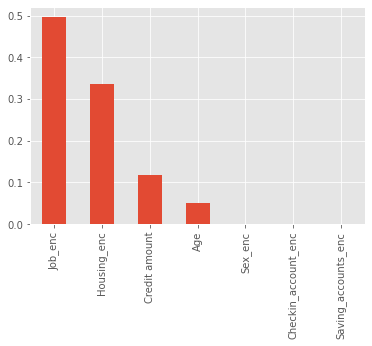

In [240]:
pd.Series(modelo.feature_importances_, 
          index = Cluster_2_tr.drop(columns = ['Target']).columns).sort_values(ascending = False).plot(kind = 'bar');

In [241]:
importancia = pd.DataFrame({'variable':Cluster_2_tr.drop(columns = ['Target']).columns,
                           'importancia':modelo.feature_importances_})

importancia.sort_values(by = 'importancia', ascending = False)

variable  importancia
6              Job_enc     0.496264
3          Housing_enc     0.336541
1        Credit amount     0.116881
0                  Age     0.050313
2              Sex_enc     0.000000
4  Checkin_account_enc     0.000000
5  Saving_accounts_enc     0.000000

Se puede apreciar que las variables que entraron al modelo sólo fueron 4 de las cuales el tipo de trabajo y el alojamiento son las más importantes, seguidas del monto del crédito pasado y la edad. Ya solo falta conocer esa ruta o reglas que nos permiten conocer a los clientes objetivo.

Profundidad del árbol: 5
Número de nodos terminales: 8


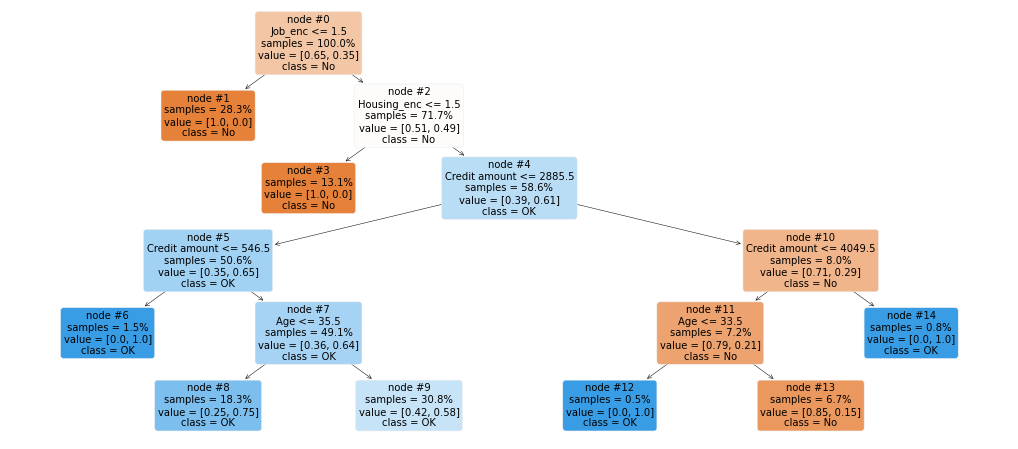

In [247]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize = (18, 8))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = Cluster_2_tr.drop(columns = ['Target']).columns.tolist(),
            class_names   = ['No','OK'],
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            node_ids = True,
            proportion = True,
            precision = 2,
            rounded = True,
            ax            = ax
       )

La ruta que nos interesa es donde está el **nodo 9**, porque ahí están los clientes que tienen una probabilidad mayor de que acepten contratar un crédito para auto. Veamos la regla o ruta de ese nodo:

**Clientes calificados y altamente calificados => con casa propia => crédito anterior entre 546.5 y 2885.5 => mayores de 35.5 años**

Ya solo falta agregar el nodo a la data:

In [245]:
Cluster_2_tr['nodo'] = modelo.apply(X_train)

In [246]:
Cluster_2_tr[Cluster_2_tr.nodo == 9]

Age  Credit amount  Target  Sex_enc  Housing_enc  Checkin_account_enc  \
0     67           1169       1        0            2                    1   
2     53           2835       1        0            2                    0   
6     53           2424       1        0            2                    0   
..   ...            ...     ...      ...          ...                  ...   
382   64           1409       1        1            2                    0   
385   50           2390       0        0            2                    0   
388   38            804       1        0            2                    0   

     Saving_accounts_enc  Job_enc  nodo  
0                      0        2     9  
2                      4        2     9  
6                      0        2     9  
..                   ...      ...   ...  
382                    2        2     9  
385                    0        2     9  
388                    1        2     9  

[120 rows x 9 columns]

Estos clientes tienen una probabilidad de que acepten un crédito para auto del 58%, aproximadamente. Este análisis es de gran utilidad ya que al focalizar a las personas la efectividad de la campaña aumentará, además, es probable que aumente el ROI de la misma, pues no es lo mismo lanzar la campaña a los 389 clientes que componen el cluster 2 que a solo 120. Por un lado aumentará la colocación de ese crédito y por el otro disminuirán los costos asociados de dicha campaña.

Hay que recalcar que este árbol de decisión no se realizó para hacer predicciones sino para encontrar esa regla de negocio que permita maximixar una campaña de marketing. Si el objetivo ubiera sido de predicción entonces la opción ubiera sido optar por un algoritmo más potente y complejo como un Random Forest, XGBoost, LightGBM, etc.

Este proyecto fue un buen ejercicio para mostrar cómo se pueden combinar distintos algoritmos de machine learning como lo fueron un k-means y un arbol de decisión.

In [248]:
import session_info

session_info.show(html = False)

-----
feature_engine      1.4.1
ipykernel           6.15.0
matplotlib          3.5.2
mpl_toolkits        NA
numpy               1.22.3
pandas              1.5.3
plotly              5.9.0
prince              0.7.1
scipy               1.7.3
seaborn             0.11.2
session_info        1.0.0
sklearn             1.1.1
statsmodels         0.13.0
-----
IPython             8.4.0
jupyter_client      7.3.4
jupyter_core        4.10.0
notebook            6.4.12
-----
Python 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.18363-SP0
-----
Session information updated at 2023-10-05 16:17
